<div style="text-align: center; font-size: 30px; font-weight: bold;">
Movement Prediction
<br> -------------- <br>
Riemann SVM Pipeline 
<br> -------------- <br> 
Grid Search
</div>

## Introduction

This notebook aims to find the best hyperparameters for Riemann SVM pipeline for movement prediction. The differents grid search search have been made on the Rainman Supaero hpc cluster. The scripts and results csv can be found in the `src/training/RIEMANN_SVM_MVT_grid_search/` folder. The results are then loaded and analyzed in this notebook.

Some informations about the pipeline can be found in the [RIEMANN_SVM_MVT notebook](./../exploration_pipeline_optimale/pipeline_julien.ipynb).

Some informations about the trainings can be found in the [training Readme.md](./../../src/training/README.md).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

## Grid Search 1 : Epoch onset and duration

### Preprocessing hyperparameters : 
```python
params_dict_lists = { #V1
    'EPOCHS_TMIN': [-1, -0.5, 0], # 3 Epochs movement onset
    'EPOCHS_LENGTH': [-8, -7, -6, -5, -4.5, -4, -3.5, -3], # 8 Epochs movement duration
    'EPOCHS_EMPTY_FROM_MVT_TMIN': [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5], # 10 Epochs with no movement start time from movement onset
    'FMIN': [1], # Bandpass filter frequency min
    'FMAX': [40], # 1 Bandpass filter frequency max
} # 3*8*10*1*1 = 240 combinations
## DONE

params_dict_lists_exclude = None
params_exclude_rules = None
```
-----------------------------

### Pipeline hyperparameters : 
```python
cov = Covariances()
ts = TangentSpace()
ss = StandardScaler()
clf = SVC()
pipeline = Pipeline([('cov', cov), ('ts', ts), ('ss', ss), ('clf', clf)])

pipelines_dict_lists = {
    'pipeline_1': {
    'pipeline': [pipeline],
    'clf__C': [1], # 1
    'clf__gamma': ['scale'], # 1
    'clf__kernel': ['rbf'], # 1
    'cov__estimator': ['oas'], # 1
    },
    #'pipeline_2':{}
}

pipelines_dict_lists_exclude = None
pipelines_exclude_rules = None

```

In [2]:
RESULT_PATH = './../../src/training/RIEMANN_SVM_MVT_grid_search/results/V1/'
NAME_RESULTS = 'hyperparam_preproc_movement_SVM'
SAVE_PATH = './results/'
NAME_SAVE = 'hyperparam_preproc_movement_SVM_aggregated'

# agregate results one file is one hyperparameter setting
files = [f for f in os.listdir(RESULT_PATH) if f.startswith(NAME_RESULTS) and f.endswith('.csv')]
files = [os.path.join(RESULT_PATH, f) for f in files]
dfs = []
for file in files:
    df = pd.read_csv(file)
    dfs.append(df)
result_df = pd.concat(dfs, ignore_index=True)

# Remove same lines
result_df = result_df.drop_duplicates()

# Save aggregated results
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)
result_df.to_csv(os.path.join(SAVE_PATH, NAME_SAVE + '.csv'), index=False)

FileNotFoundError: [WinError 3] Le chemin d’accès spécifié est introuvable: './../../src/training/hyperparameters_movement/results/'

In [ ]:
result_df.describe()

,EPOCHS_TMIN,EPOCHS_LENGTH,EPOCHS_EMPTY_FROM_MVT_TMINS,FMIN,FMAX,RANDOM_STATE,N_SPLIT,NUMBER_OF_SESSIONS,score_A,score_B,score_C,score_X,duration,memory
count,239.000000,239.000000,239.000000,239.0,239.0,239.0,239.0,239.0,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000
mean,-0.502092,2.759414,-5.133891,1.0,40.0,42.0,4.0,89.0,0.698551,0.701754,0.628530,0.694294,861.388535,3974.834434
std,0.408672,1.434738,1.635627,0.0,0.0,0.0,0.0,0.0,0.112897,0.078516,0.059683,0.112833,146.262455,1215.861798
min,-1.000000,0.500000,-8.000000,1.0,40.0,42.0,4.0,89.0,0.379032,0.543055,0.532434,0.375752,732.143442,1456.765625
25%,-1.000000,1.500000,-6.500000,1.0,40.0,42.0,4.0,89.0,0.610753,0.628305,0.568068,0.607783,796.085777,3023.267578
50%,-0.500000,3.000000,-5.000000,1.0,40.0,42.0,4.0,89.0,0.722855,0.708232,0.635759,0.717118,831.731270,3880.375000
75%,0.000000,4.000000,-4.000000,1.0,40.0,42.0,4.0,89.0,0.793885,0.771853,0.685858,0.789777,878.813060,5037.748047
max,0.000000,5.000000,-3.000000,1.0,40.0,42.0,4.0,89.0,0.852704,0.824630,0.723639,0.847548,1744.762087,6431.832031


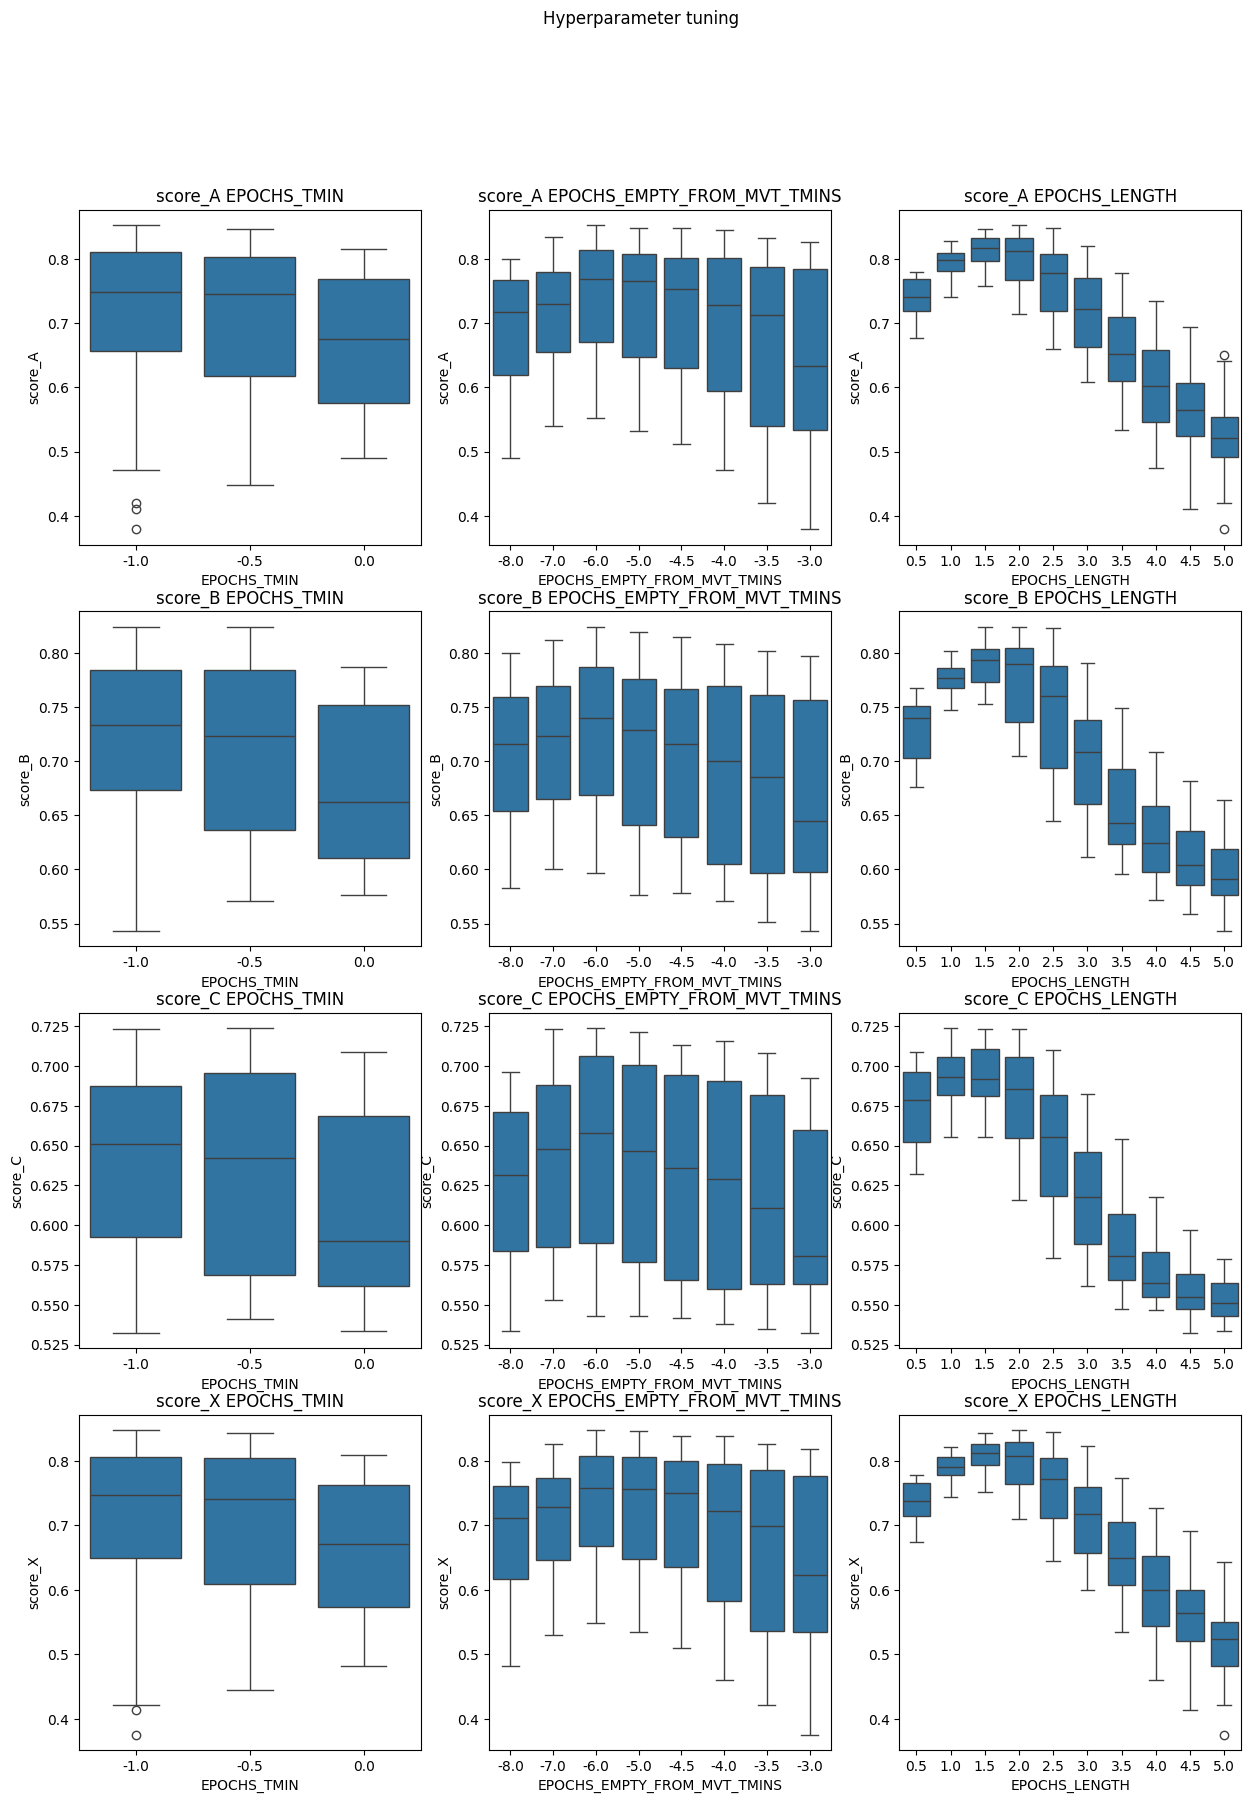

In [ ]:
scores = ['score_A', 'score_B', 'score_C', 'score_X']
parameters = ['EPOCHS_TMIN', 'EPOCHS_EMPTY_FROM_MVT_TMINS', 'EPOCHS_LENGTH']

fig, ax = plt.subplots(4, 3, figsize=(15, 20))
fig.suptitle('Hyperparameter tuning')

for i, score in enumerate(scores):
    for j, param in enumerate(parameters):
        sns.boxplot(x=param, y=score, data=result_df, ax=ax[i, j])
        ax[i, j].set_title(score + ' ' + param)
plt.show()

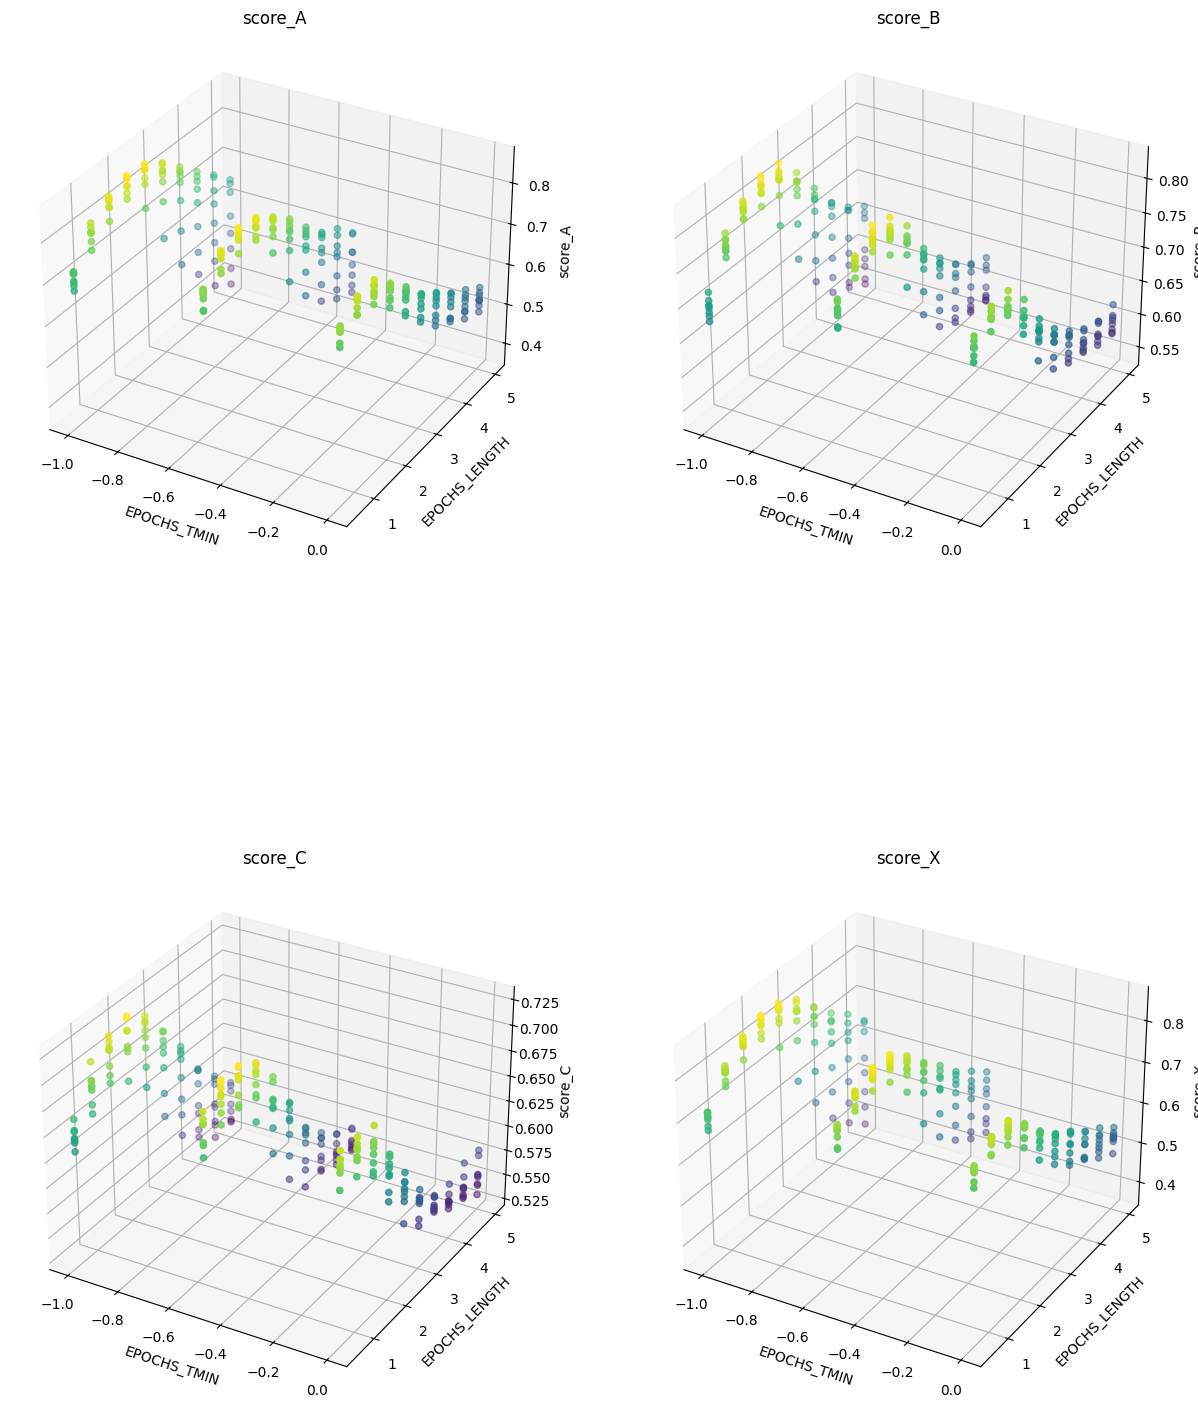

In [ ]:
# 3D plot around each score for EPOCHS_TMIN and EPOCHS_LENGTH
scores = ['score_A', 'score_B', 'score_C', 'score_X']
fig, ax = plt.subplots(2, 2, figsize=(15, 20), subplot_kw={'projection': '3d'})

for i, score in enumerate(scores):
    x = result_df['EPOCHS_TMIN']
    y = result_df['EPOCHS_LENGTH']
    z = result_df[score]
    ax[i // 2, i % 2].scatter(x, y, z, c=z, cmap='viridis')
    ax[i // 2, i % 2].set_xlabel('EPOCHS_TMIN')
    ax[i // 2, i % 2].set_ylabel('EPOCHS_LENGTH')
    ax[i // 2, i % 2].set_zlabel(score)
    ax[i // 2, i % 2].set_title(score)
plt.show()

In [ ]:
# sort by score A
result_df = result_df.sort_values(by='score_A', ascending=False)
result_df.head(10)

,EPOCHS_TMIN,EPOCHS_LENGTH,EPOCHS_EMPTY_FROM_MVT_TMINS,FMIN,FMAX,CLASSIFIER,RANDOM_STATE,N_SPLIT,NUMBER_OF_SESSIONS,score_A,score_B,score_C,score_X,duration,memory
40,-1.0,2.0,-6.0,1,40,SVC,42,4,89,0.852704,0.823982,0.723039,0.847548,768.240042,3165.308594
220,-1.0,2.5,-6.0,1,40,SVC,42,4,89,0.848411,0.823190,0.705357,0.845298,819.782502,3625.679688
25,-1.0,2.0,-4.5,1,40,SVC,42,4,89,0.848358,0.811656,0.709180,0.837881,799.519578,3065.492188
152,-1.0,2.0,-5.0,1,40,SVC,42,4,89,0.848237,0.819424,0.708525,0.845605,837.737786,3108.121094
39,-0.5,1.5,-6.0,1,40,SVC,42,4,89,0.846969,0.824630,0.721819,0.842529,797.270660,2579.511719
93,-1.0,2.5,-5.0,1,40,SVC,42,4,89,0.845637,0.808416,0.703074,0.838801,798.569810,3613.289062
137,-1.0,2.0,-4.0,1,40,SVC,42,4,89,0.844636,0.808883,0.693689,0.838321,841.995350,3052.277344
136,-0.5,1.5,-4.0,1,40,SVC,42,4,89,0.844333,0.806952,0.713632,0.833905,827.839904,2525.480469
151,-0.5,1.5,-5.0,1,40,SVC,42,4,89,0.840625,0.814898,0.710112,0.840384,828.929775,3071.242188
24,-0.5,1.5,-4.5,1,40,SVC,42,4,89,0.839299,0.815050,0.713458,0.834915,745.152336,3177.269531


### Analytics about training (memory, time, etc)

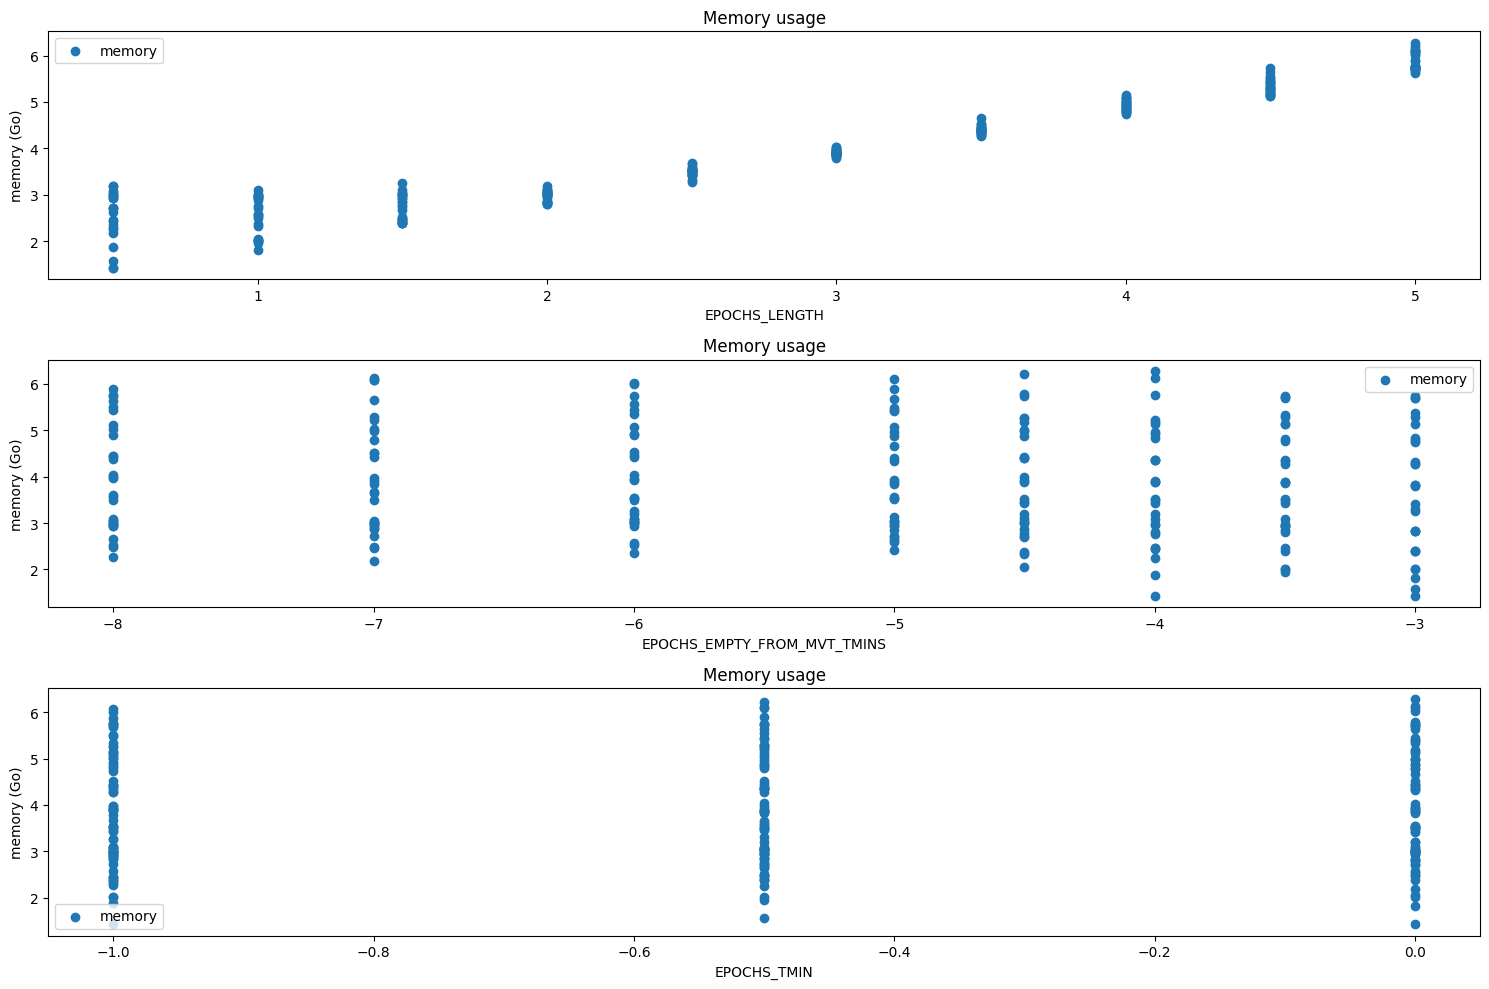

In [ ]:
# display memory usage
variables = ['EPOCHS_LENGTH', 'EPOCHS_EMPTY_FROM_MVT_TMINS', 'EPOCHS_TMIN']

fig, ax = plt.subplots(3, 1, figsize=(15, 10))
for i, var in enumerate(variables):
    ax[i].scatter(result_df[var], result_df['memory']/1024, label='memory', marker='o')
    ax[i].set_xlabel(var)
    ax[i].set_ylabel('memory (Go)')
    ax[i].set_title('Memory usage')
    ax[i].legend()
plt.tight_layout()
plt.show()

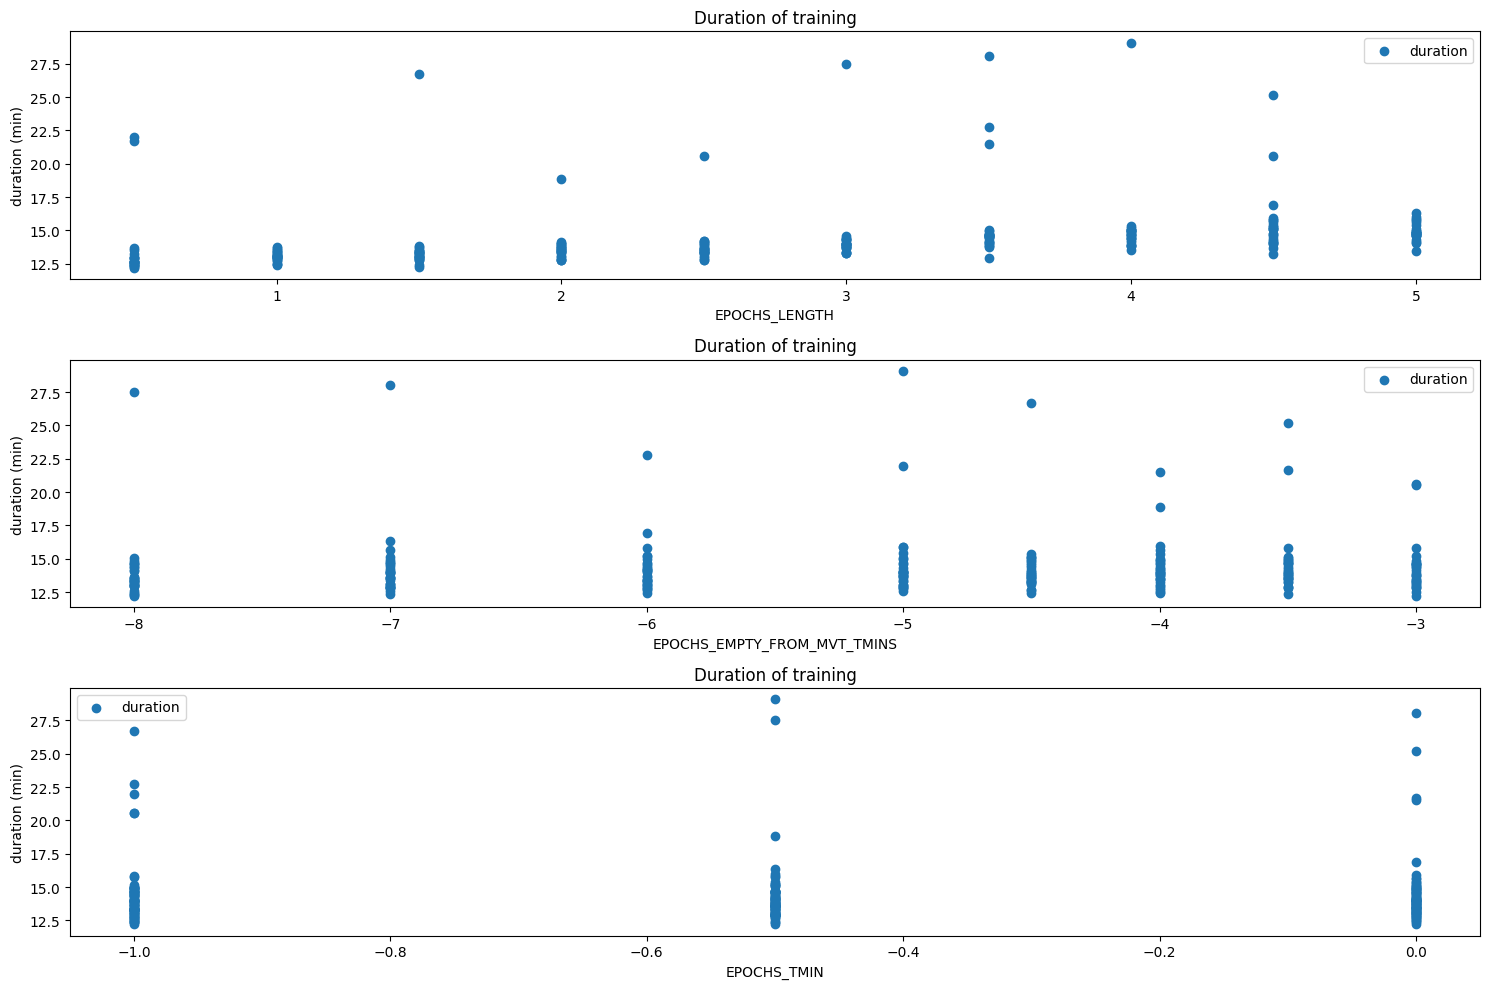

In [ ]:
# display memory usage
variables = ['EPOCHS_LENGTH', 'EPOCHS_EMPTY_FROM_MVT_TMINS', 'EPOCHS_TMIN']

fig, ax = plt.subplots(3, 1, figsize=(15, 10))
for i, var in enumerate(variables):
    ax[i].scatter(result_df[var], result_df['duration']/60, label='duration', marker='o')
    ax[i].set_xlabel(var)
    ax[i].set_ylabel('duration (min)')
    ax[i].set_title('Duration of training')
    ax[i].legend()
plt.tight_layout()
plt.show()

In [ ]:
# sort by duration
result_df['duration_min'] = result_df['duration'] / 60
result_df = result_df.sort_values(by='duration_min', ascending=False)
result_df.head(10)

,EPOCHS_TMIN,EPOCHS_LENGTH,EPOCHS_EMPTY_FROM_MVT_TMINS,FMIN,FMAX,CLASSIFIER,RANDOM_STATE,N_SPLIT,NUMBER_OF_SESSIONS,score_A,score_B,score_C,score_X,duration,memory,duration_min
95,-0.5,4.0,-5.0,1,40,SVC,42,4,89,0.655902,0.648635,0.576663,0.658562,1744.762087,5085.304688,29.079368
109,0.0,3.5,-7.0,1,40,SVC,42,4,89,0.625098,0.639437,0.575610,0.611478,1683.539512,4536.730469,28.058992
116,-0.5,3.0,-8.0,1,40,SVC,42,4,89,0.719453,0.715116,0.631080,0.711615,1650.226759,4067.964844,27.503779
84,-1.0,1.5,-4.5,1,40,SVC,42,4,89,0.832827,0.803712,0.705732,0.820858,1602.564358,3118.027344,26.709406
73,0.0,4.5,-3.5,1,40,SVC,42,4,89,0.526204,0.594366,0.566350,0.522398,1510.882173,5460.914062,25.181370
102,-1.0,3.5,-6.0,1,40,SVC,42,4,89,0.777977,0.749002,0.653894,0.773531,1365.307112,4535.539062,22.755119
90,-1.0,0.5,-5.0,1,40,SVC,42,4,89,0.723173,0.718214,0.653170,0.716836,1318.387552,2480.175781,21.973126
67,0.0,0.5,-3.5,1,40,SVC,42,4,89,0.772571,0.751573,0.695214,0.766540,1300.675248,3052.179688,21.677921
79,0.0,3.5,-4.0,1,40,SVC,42,4,89,0.612604,0.612515,0.560406,0.613504,1290.227106,4471.226562,21.503785
66,-1.0,4.5,-3.0,1,40,SVC,42,4,89,0.409854,0.558737,0.532434,0.413798,1234.370762,5268.312500,20.572846


In [ ]:
# sort by memory
result_df['memory_Go'] = result_df['memory'] / 1024
result_df = result_df.sort_values(by='memory_Go', ascending=False)
result_df.head(10)

,EPOCHS_TMIN,EPOCHS_LENGTH,EPOCHS_EMPTY_FROM_MVT_TMINS,FMIN,FMAX,CLASSIFIER,RANDOM_STATE,N_SPLIT,NUMBER_OF_SESSIONS,score_A,score_B,score_C,score_X,duration,memory,duration_min,memory_Go
141,0.0,5.0,-4.0,1,40,SVC,42,4,89,0.506573,0.590972,0.554345,0.512757,937.847507,6431.832031,15.630792,6.281086
89,-0.5,5.0,-4.5,1,40,SVC,42,4,89,0.519316,0.579637,0.541658,0.510612,872.891970,6365.597656,14.548200,6.216404
171,0.0,5.0,-7.0,1,40,SVC,42,4,89,0.539366,0.600363,0.553309,0.529610,908.028861,6283.441406,15.133814,6.136173
201,-0.5,5.0,-4.0,1,40,SVC,42,4,89,0.492816,0.571053,0.544935,0.480000,959.320268,6265.531250,15.988671,6.118683
156,0.0,5.0,-5.0,1,40,SVC,42,4,89,0.532291,0.576246,0.544438,0.534885,923.917503,6245.101562,15.398625,6.098732
231,-0.5,5.0,-7.0,1,40,SVC,42,4,89,0.597508,0.637209,0.563624,0.577950,980.488682,6230.015625,16.341478,6.084000
52,-1.0,5.0,-7.0,1,40,SVC,42,4,89,0.650330,0.663959,0.576419,0.639427,843.914176,6226.910156,14.065236,6.080967
44,0.0,5.0,-6.0,1,40,SVC,42,4,89,0.552107,0.596585,0.543045,0.548135,847.982444,6175.117188,14.133041,6.030388
164,-1.0,5.0,-6.0,1,40,SVC,42,4,89,0.640313,0.645174,0.567581,0.643675,881.435298,6150.000000,14.690588,6.005859
216,-0.5,5.0,-5.0,1,40,SVC,42,4,89,0.551377,0.592125,0.542845,0.543172,951.481617,6039.992188,15.858027,5.898430


## Grid Search 2 : Epochs onset and duration with more points

### Preprocessing hyperparameters : 
```python
params_dict_lists = { #V2
    'EPOCHS_TMIN': [0, -0.25, -0.5, -0.75, -1, -1.25, -1.5], # 7
    'EPOCHS_LENGTH': [1.5, 1.6, 1.7, 1.8, 1.9, 2, 2.1, 2.2, 2.3, 2.4, 2.5], # 11
    'EPOCHS_EMPTY_FROM_MVT_TMIN': [-4, -4.5, -5, -5.5, -6, -6.5, -7], # 7
    'FMIN': [1], # 1
    'FMAX': [40], # 1
} # 539 iterations, time estimation: ((536//(8*6)) * 11)/60 = 2h (8 nodes, 6 cores each, estimation 11 minutes per iteration)
# DONE

params_dict_lists_exclude = None
params_exclude_rules = None

```
-----------------------------

### Pipeline hyperparameters : 
```python
cov = Covariances()
ts = TangentSpace()
ss = StandardScaler()
clf = SVC()
pipeline = Pipeline([('cov', cov), ('ts', ts), ('ss', ss), ('clf', clf)])

pipelines_dict_lists = {
    'pipeline_1': {
    'pipeline': [pipeline],
    'clf__C': [1], # 1
    'clf__gamma': ['scale'], # 1
    'clf__kernel': ['rbf'], # 1
    'cov__estimator': ['oas'], # 1
    },
    #'pipeline_2':{}
}

pipelines_dict_lists_exclude = None
pipelines_exclude_rules = None
```

In [3]:
RESULT_PATH = './../../src/training/RIEMANN_SVM_MVT_grid_search/results/V2/'
NAME_RESULTS = 'hyperparam_preproc_movement_SVM_V2'
SAVE_PATH = './results/'
NAME_SAVE = 'hyperparam_preproc_movement_SVM_aggregated_V2'

# agregate results one file is one hyperparameter setting
files = [f for f in os.listdir(RESULT_PATH) if f.startswith(NAME_RESULTS) and f.endswith('.csv')]
files = [os.path.join(RESULT_PATH, f) for f in files]
dfs = []
for file in files:
    df = pd.read_csv(file)
    dfs.append(df)
result_df = pd.concat(dfs, ignore_index=True)

# Remove same lines
result_df = result_df.drop_duplicates()

# Save aggregated results
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)
result_df.to_csv(os.path.join(SAVE_PATH, NAME_SAVE + '.csv'), index=False)

In [4]:
result_df.describe()

,EPOCHS_TMIN,EPOCHS_LENGTH,EPOCHS_EMPTY_FROM_MVT_TMINS,FMIN,FMAX,RANDOM_STATE,N_SPLIT,NUMBER_OF_SESSIONS,score_A,score_B,score_C,score_X,duration,memory
count,538.000000,538.000000,538.000000,538.0,538.0,538.0,538.0,538.0,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000
mean,-0.751394,2.000929,-5.502788,1.0,40.0,42.0,4.0,89.0,0.812581,0.787424,0.692210,0.806942,1044.785687,3058.022893
std,0.499882,0.316079,0.999763,0.0,0.0,0.0,0.0,0.0,0.033184,0.031880,0.024871,0.034452,133.119554,308.927413
min,-1.500000,1.500000,-7.000000,1.0,40.0,42.0,4.0,89.0,0.697599,0.686684,0.610932,0.688579,754.517497,2388.109375
25%,-1.250000,1.700000,-6.500000,1.0,40.0,42.0,4.0,89.0,0.793453,0.770325,0.679348,0.788436,914.232982,2830.745117
50%,-0.750000,2.000000,-5.500000,1.0,40.0,42.0,4.0,89.0,0.821916,0.797631,0.697368,0.817230,1102.014462,3043.521484
75%,-0.250000,2.300000,-4.500000,1.0,40.0,42.0,4.0,89.0,0.839400,0.811460,0.711252,0.833673,1132.853429,3298.291992
max,0.000000,2.500000,-4.000000,1.0,40.0,42.0,4.0,89.0,0.858205,0.830475,0.731805,0.853312,1736.679972,3670.140625


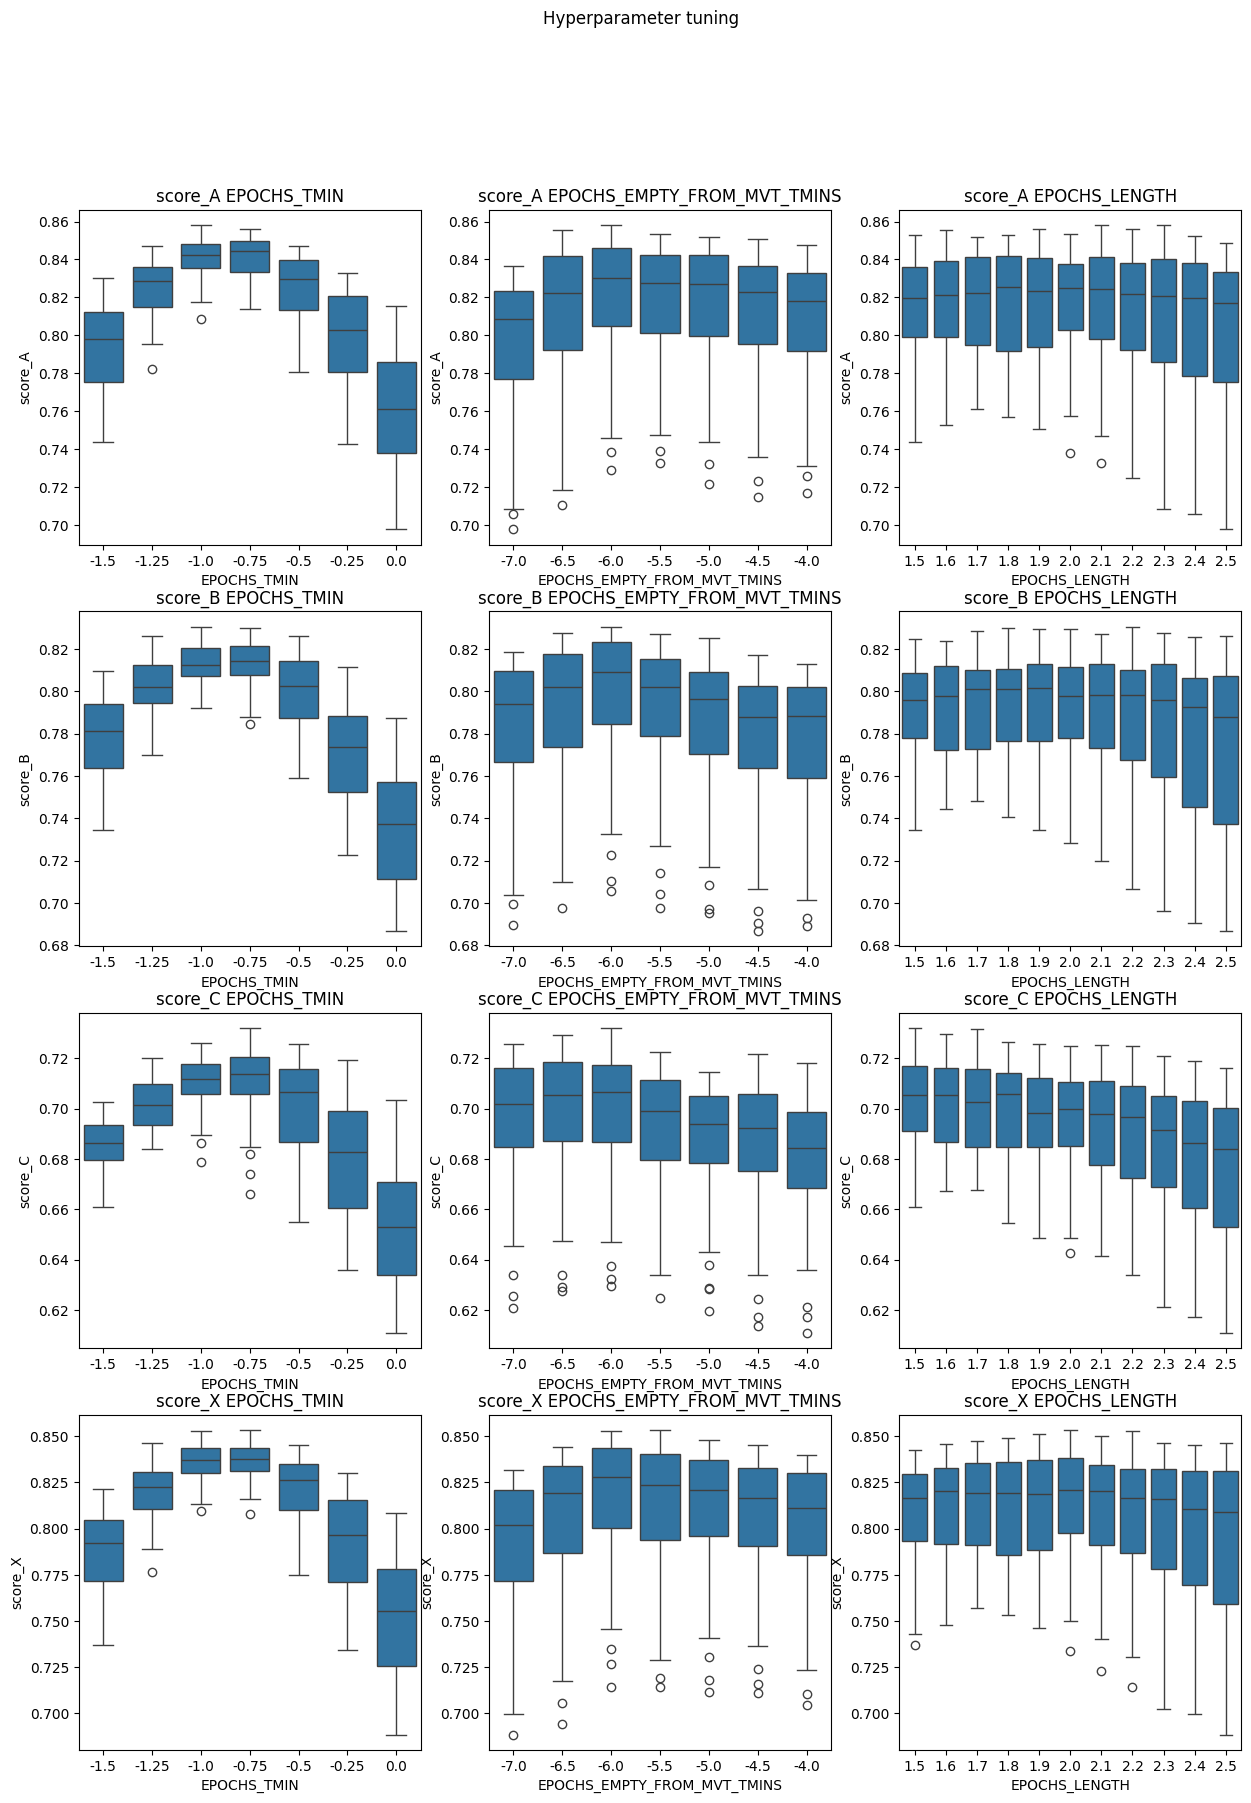

In [5]:
scores = ['score_A', 'score_B', 'score_C', 'score_X']
parameters = ['EPOCHS_TMIN', 'EPOCHS_EMPTY_FROM_MVT_TMINS', 'EPOCHS_LENGTH']

fig, ax = plt.subplots(4, 3, figsize=(15, 20))
fig.suptitle('Hyperparameter tuning')

for i, score in enumerate(scores):
    for j, param in enumerate(parameters):
        sns.boxplot(x=param, y=score, data=result_df, ax=ax[i, j])
        ax[i, j].set_title(score + ' ' + param)
plt.show()

In [6]:
# sort by score A
result_df = result_df.sort_values(by='score_A', ascending=False)
result_df.head(10)

,EPOCHS_TMIN,EPOCHS_LENGTH,EPOCHS_EMPTY_FROM_MVT_TMINS,FMIN,FMAX,CLASSIFIER,RANDOM_STATE,N_SPLIT,NUMBER_OF_SESSIONS,score_A,score_B,score_C,score_X,duration,memory
112,-1.00,2.1,-6.0,1,40,SVC,42,4,89,0.858205,0.827227,0.717973,0.850008,805.331966,3093.089844
516,-1.00,2.3,-6.0,1,40,SVC,42,4,89,0.857955,0.827724,0.716298,0.846273,1132.711892,3388.710938
45,-1.00,2.2,-6.0,1,40,SVC,42,4,89,0.856323,0.830475,0.721212,0.852763,901.241177,3215.625000
178,-0.75,1.9,-6.0,1,40,SVC,42,4,89,0.855998,0.829166,0.725803,0.850985,1081.308213,2965.953125
522,-0.75,1.9,-6.5,1,40,SVC,42,4,89,0.855529,0.827516,0.721685,0.844005,1107.675889,2869.480469
376,-0.75,1.6,-6.0,1,40,SVC,42,4,89,0.855468,0.821874,0.729653,0.844721,1088.645246,2912.597656
172,-1.00,2.3,-5.5,1,40,SVC,42,4,89,0.853637,0.820232,0.717772,0.846593,1128.086556,3324.023438
303,-0.75,2.0,-5.5,1,40,SVC,42,4,89,0.853628,0.823960,0.716573,0.853312,1126.556278,3046.562500
111,-0.75,2.0,-6.0,1,40,SVC,42,4,89,0.853556,0.829329,0.723284,0.848220,826.473378,2892.242188
30,-0.75,1.6,-5.5,1,40,SVC,42,4,89,0.853115,0.822663,0.719433,0.845672,786.847796,2908.406250


In [7]:
# sort by score C
result_df = result_df.sort_values(by='score_C', ascending=False)
result_df.head(10)

,EPOCHS_TMIN,EPOCHS_LENGTH,EPOCHS_EMPTY_FROM_MVT_TMINS,FMIN,FMAX,CLASSIFIER,RANDOM_STATE,N_SPLIT,NUMBER_OF_SESSIONS,score_A,score_B,score_C,score_X,duration,memory
442,-0.75,1.5,-6.0,1,40,SVC,42,4,89,0.852972,0.817826,0.731805,0.841155,1088.033179,2493.402344
310,-0.75,1.7,-6.0,1,40,SVC,42,4,89,0.851809,0.828355,0.731415,0.847417,1092.726076,2900.332031
376,-0.75,1.6,-6.0,1,40,SVC,42,4,89,0.855468,0.821874,0.729653,0.844721,1088.645246,2912.597656
251,-0.75,1.5,-6.5,1,40,SVC,42,4,89,0.842211,0.818241,0.729075,0.834802,1057.235575,2969.410156
185,-0.75,1.6,-6.5,1,40,SVC,42,4,89,0.849996,0.821965,0.726604,0.837703,1065.794502,3006.730469
244,-0.75,1.8,-6.0,1,40,SVC,42,4,89,0.852656,0.829972,0.726307,0.848961,1109.303615,2875.285156
119,-1.00,1.8,-6.5,1,40,SVC,42,4,89,0.842633,0.820036,0.726020,0.837121,802.169804,2717.105469
529,-0.75,1.6,-7.0,1,40,SVC,42,4,89,0.828928,0.812580,0.725803,0.822397,1099.296688,2699.488281
178,-0.75,1.9,-6.0,1,40,SVC,42,4,89,0.855998,0.829166,0.725803,0.850985,1081.308213,2965.953125
398,-1.00,1.9,-7.0,1,40,SVC,42,4,89,0.827256,0.810156,0.725766,0.823866,1132.279777,3114.164062


In [8]:
# sort by score B
result_df = result_df.sort_values(by='score_B', ascending=False)
result_df.head(10)

,EPOCHS_TMIN,EPOCHS_LENGTH,EPOCHS_EMPTY_FROM_MVT_TMINS,FMIN,FMAX,CLASSIFIER,RANDOM_STATE,N_SPLIT,NUMBER_OF_SESSIONS,score_A,score_B,score_C,score_X,duration,memory
45,-1.00,2.2,-6.0,1,40,SVC,42,4,89,0.856323,0.830475,0.721212,0.852763,901.241177,3215.625000
244,-0.75,1.8,-6.0,1,40,SVC,42,4,89,0.852656,0.829972,0.726307,0.848961,1109.303615,2875.285156
111,-0.75,2.0,-6.0,1,40,SVC,42,4,89,0.853556,0.829329,0.723284,0.848220,826.473378,2892.242188
178,-0.75,1.9,-6.0,1,40,SVC,42,4,89,0.855998,0.829166,0.725803,0.850985,1081.308213,2965.953125
310,-0.75,1.7,-6.0,1,40,SVC,42,4,89,0.851809,0.828355,0.731415,0.847417,1092.726076,2900.332031
516,-1.00,2.3,-6.0,1,40,SVC,42,4,89,0.857955,0.827724,0.716298,0.846273,1132.711892,3388.710938
522,-0.75,1.9,-6.5,1,40,SVC,42,4,89,0.855529,0.827516,0.721685,0.844005,1107.675889,2869.480469
456,-0.75,2.0,-6.5,1,40,SVC,42,4,89,0.851554,0.827348,0.718119,0.841105,1118.024607,3072.851562
112,-1.00,2.1,-6.0,1,40,SVC,42,4,89,0.858205,0.827227,0.717973,0.850008,805.331966,3093.089844
435,-0.75,1.8,-5.5,1,40,SVC,42,4,89,0.849679,0.827192,0.708252,0.846022,1090.323991,2948.503906


In [9]:
# sort by mean A,B and C
result_df['mean_score_A_B_C'] = result_df[['score_A', 'score_B', 'score_C']].mean(axis=1)
result_df = result_df.sort_values(by='mean_score_A_B_C', ascending=False)
result_df.head(10)

,EPOCHS_TMIN,EPOCHS_LENGTH,EPOCHS_EMPTY_FROM_MVT_TMINS,FMIN,FMAX,CLASSIFIER,RANDOM_STATE,N_SPLIT,NUMBER_OF_SESSIONS,score_A,score_B,score_C,score_X,duration,memory,mean_score_A_B_C
310,-0.75,1.7,-6.0,1,40,SVC,42,4,89,0.851809,0.828355,0.731415,0.847417,1092.726076,2900.332031,0.803860
178,-0.75,1.9,-6.0,1,40,SVC,42,4,89,0.855998,0.829166,0.725803,0.850985,1081.308213,2965.953125,0.803656
244,-0.75,1.8,-6.0,1,40,SVC,42,4,89,0.852656,0.829972,0.726307,0.848961,1109.303615,2875.285156,0.802979
45,-1.00,2.2,-6.0,1,40,SVC,42,4,89,0.856323,0.830475,0.721212,0.852763,901.241177,3215.625000,0.802670
376,-0.75,1.6,-6.0,1,40,SVC,42,4,89,0.855468,0.821874,0.729653,0.844721,1088.645246,2912.597656,0.802331
111,-0.75,2.0,-6.0,1,40,SVC,42,4,89,0.853556,0.829329,0.723284,0.848220,826.473378,2892.242188,0.802056
522,-0.75,1.9,-6.5,1,40,SVC,42,4,89,0.855529,0.827516,0.721685,0.844005,1107.675889,2869.480469,0.801577
391,-1.00,2.2,-6.5,1,40,SVC,42,4,89,0.851971,0.827024,0.724994,0.844064,1120.972077,3258.347656,0.801330
112,-1.00,2.1,-6.0,1,40,SVC,42,4,89,0.858205,0.827227,0.717973,0.850008,805.331966,3093.089844,0.801135
44,-0.75,2.1,-6.0,1,40,SVC,42,4,89,0.851205,0.827064,0.725040,0.849126,833.136293,3161.933594,0.801103


### Agregating the results for two grids search

In [10]:
data_grid_search_1 = pd.read_csv('./results/hyperparam_preproc_movement_SVM_aggregated.csv')
data_grid_search_2 = pd.read_csv('./results/hyperparam_preproc_movement_SVM_aggregated_V2.csv')

data_grid_search_1['version'] = 'V1'
data_grid_search_2['version'] = 'V2'

data_grid_search = pd.concat([data_grid_search_1, data_grid_search_2], ignore_index=True)

# remove duplicates
data_grid_search = data_grid_search.drop_duplicates()

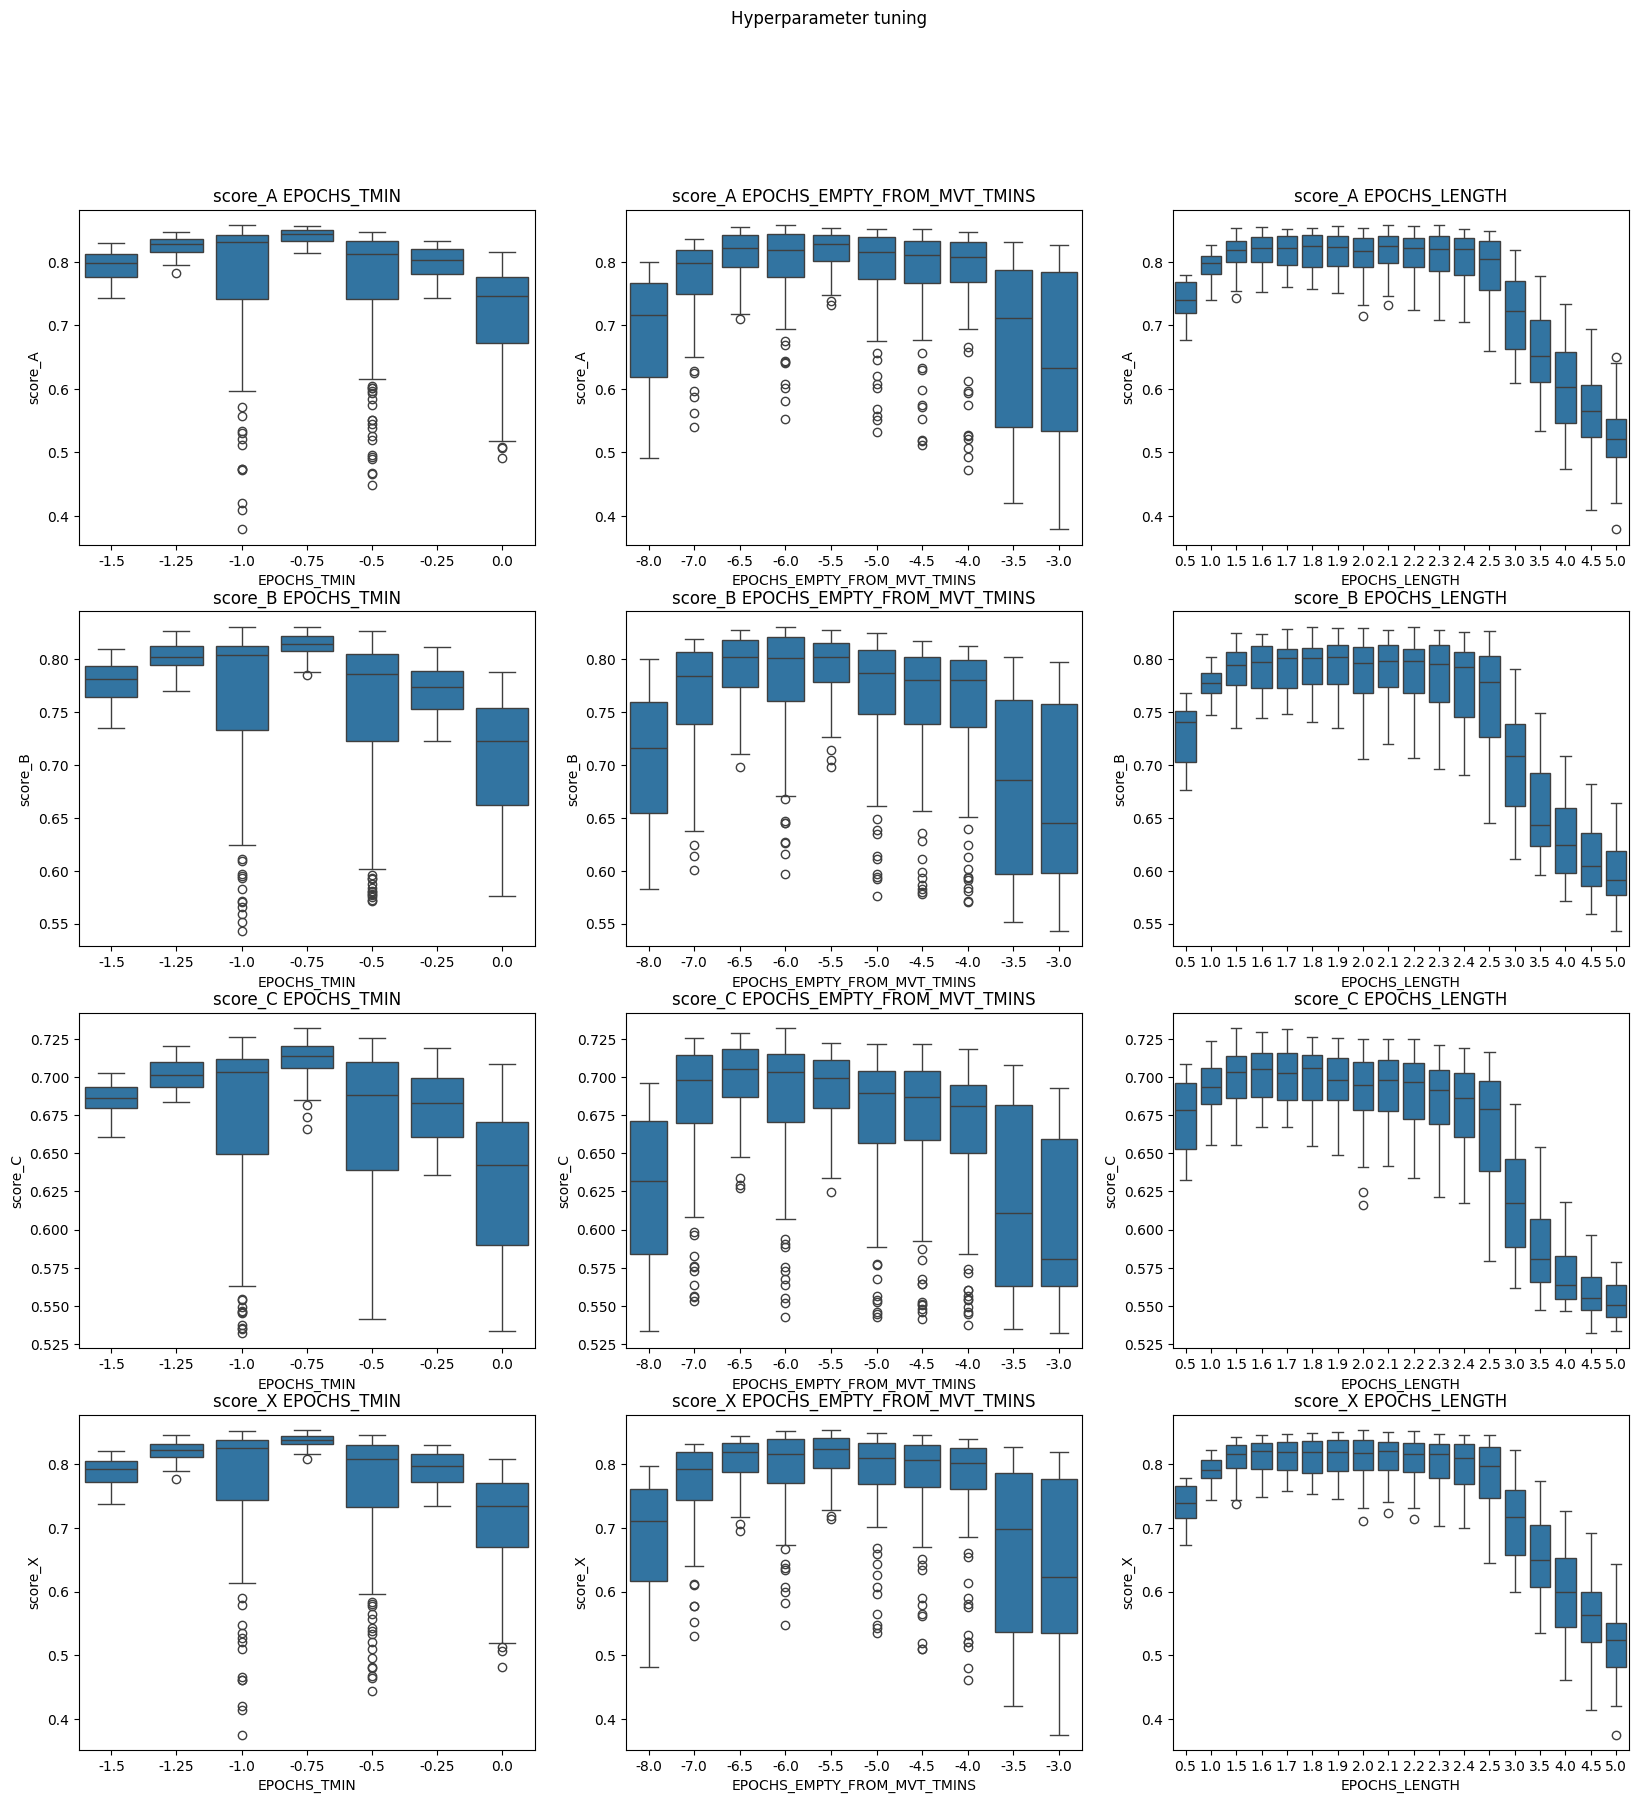

In [12]:
scores = ['score_A', 'score_B', 'score_C', 'score_X']
parameters = ['EPOCHS_TMIN', 'EPOCHS_EMPTY_FROM_MVT_TMINS', 'EPOCHS_LENGTH']

fig, ax = plt.subplots(4, 3, figsize=(20, 20))
fig.suptitle('Hyperparameter tuning')

for i, score in enumerate(scores):
    for j, param in enumerate(parameters):
        sns.boxplot(x=param, y=score, data=data_grid_search, ax=ax[i, j])
        ax[i, j].set_title(score + ' ' + param)
plt.show()

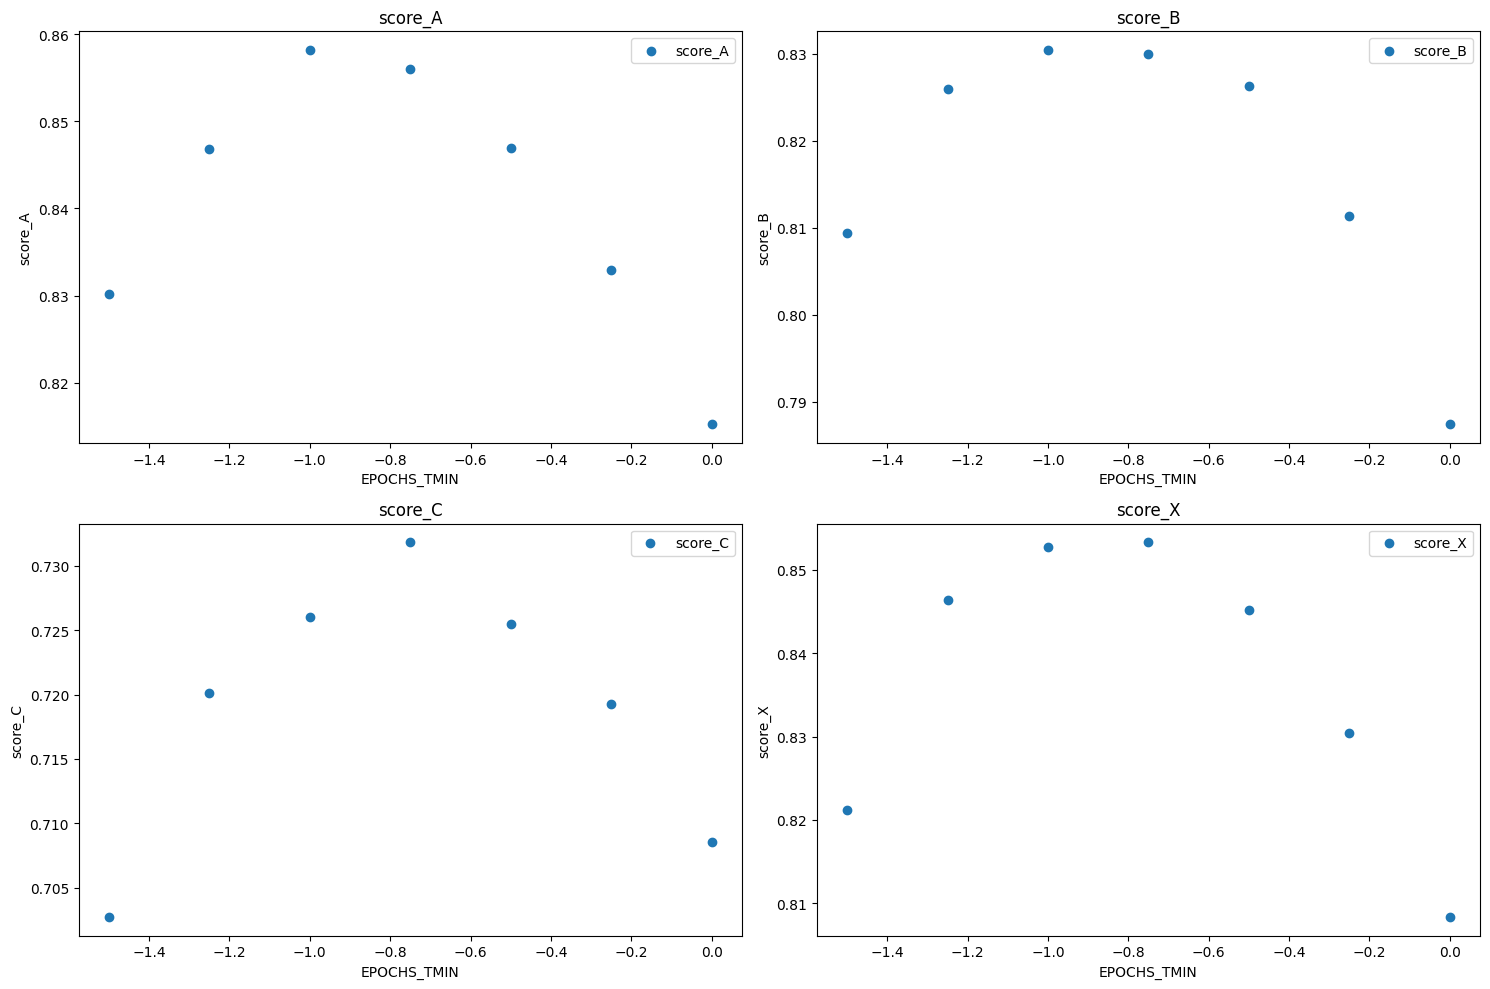

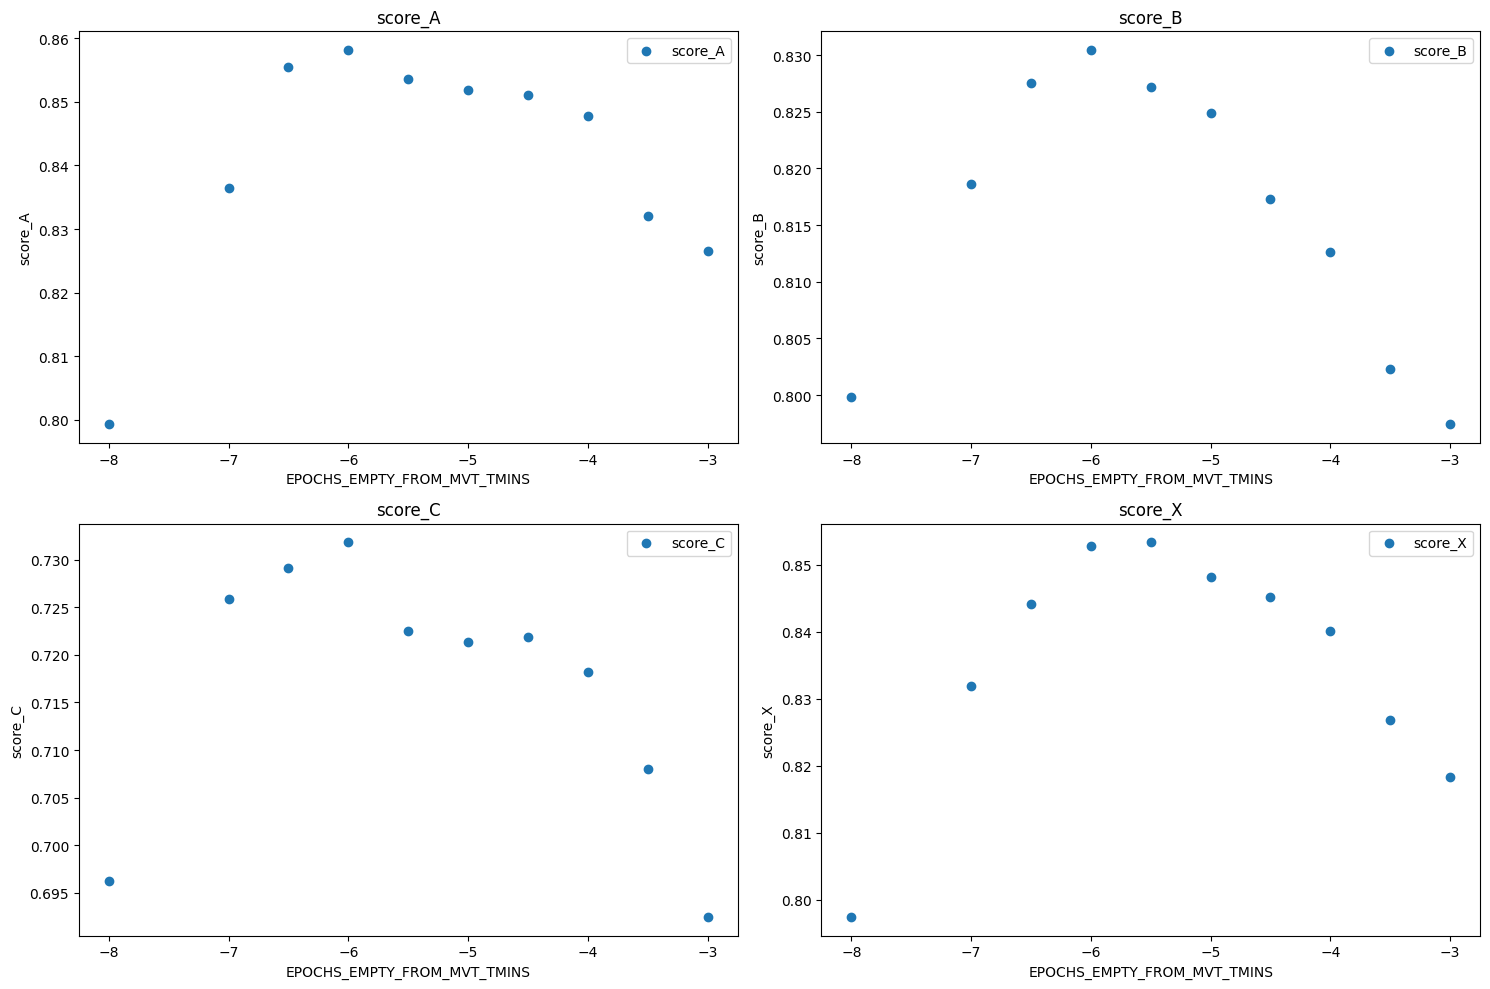

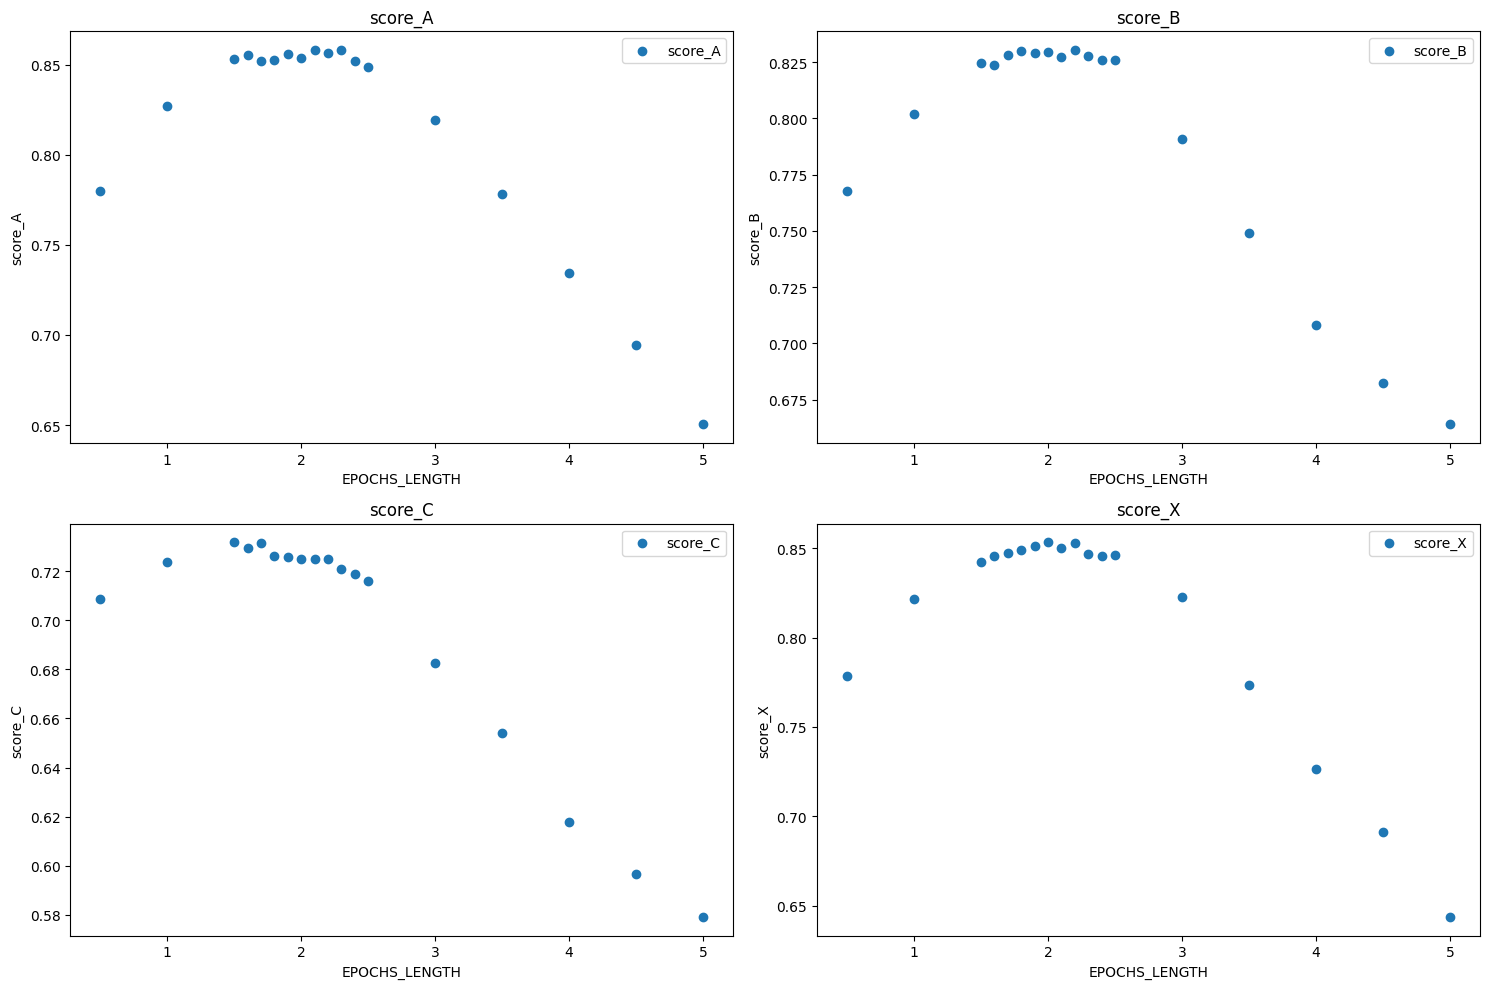

In [13]:
# max for each param and score
param = ['EPOCHS_TMIN', 'EPOCHS_EMPTY_FROM_MVT_TMINS', 'EPOCHS_LENGTH']
for p in param:
    max_score_A = data_grid_search.groupby(p)['score_A'].max()
    max_score_B = data_grid_search.groupby(p)['score_B'].max()
    max_score_C = data_grid_search.groupby(p)['score_C'].max()
    max_score_X = data_grid_search.groupby(p)['score_X'].max()

    max_score_A = max_score_A.reset_index()
    max_score_B = max_score_B.reset_index()
    max_score_C = max_score_C.reset_index()
    max_score_X = max_score_X.reset_index()

    fig, ax = plt.subplots(2, 2, figsize=(15, 10))
    ax[0, 0].scatter(max_score_A[p], max_score_A['score_A'], label='score_A', marker='o')
    ax[0, 0].set_xlabel(p)
    ax[0, 0].set_ylabel('score_A')
    ax[0, 0].set_title('score_A')
    ax[0, 0].legend()

    ax[0, 1].scatter(max_score_B[p], max_score_B['score_B'], label='score_B', marker='o')
    ax[0, 1].set_xlabel(p)
    ax[0, 1].set_ylabel('score_B')
    ax[0, 1].set_title('score_B')
    ax[0, 1].legend()

    ax[1, 0].scatter(max_score_C[p], max_score_C['score_C'], label='score_C', marker='o')
    ax[1, 0].set_xlabel(p)
    ax[1, 0].set_ylabel('score_C')
    ax[1, 0].set_title('score_C')
    ax[1, 0].legend()

    ax[1, 1].scatter(max_score_X[p], max_score_X['score_X'], label='score_X', marker='o')
    ax[1, 1].set_xlabel(p)
    ax[1, 1].set_ylabel('score_X')
    ax[1, 1].set_title('score_X')
    ax[1, 1].legend()
    plt.tight_layout()
    plt.show()

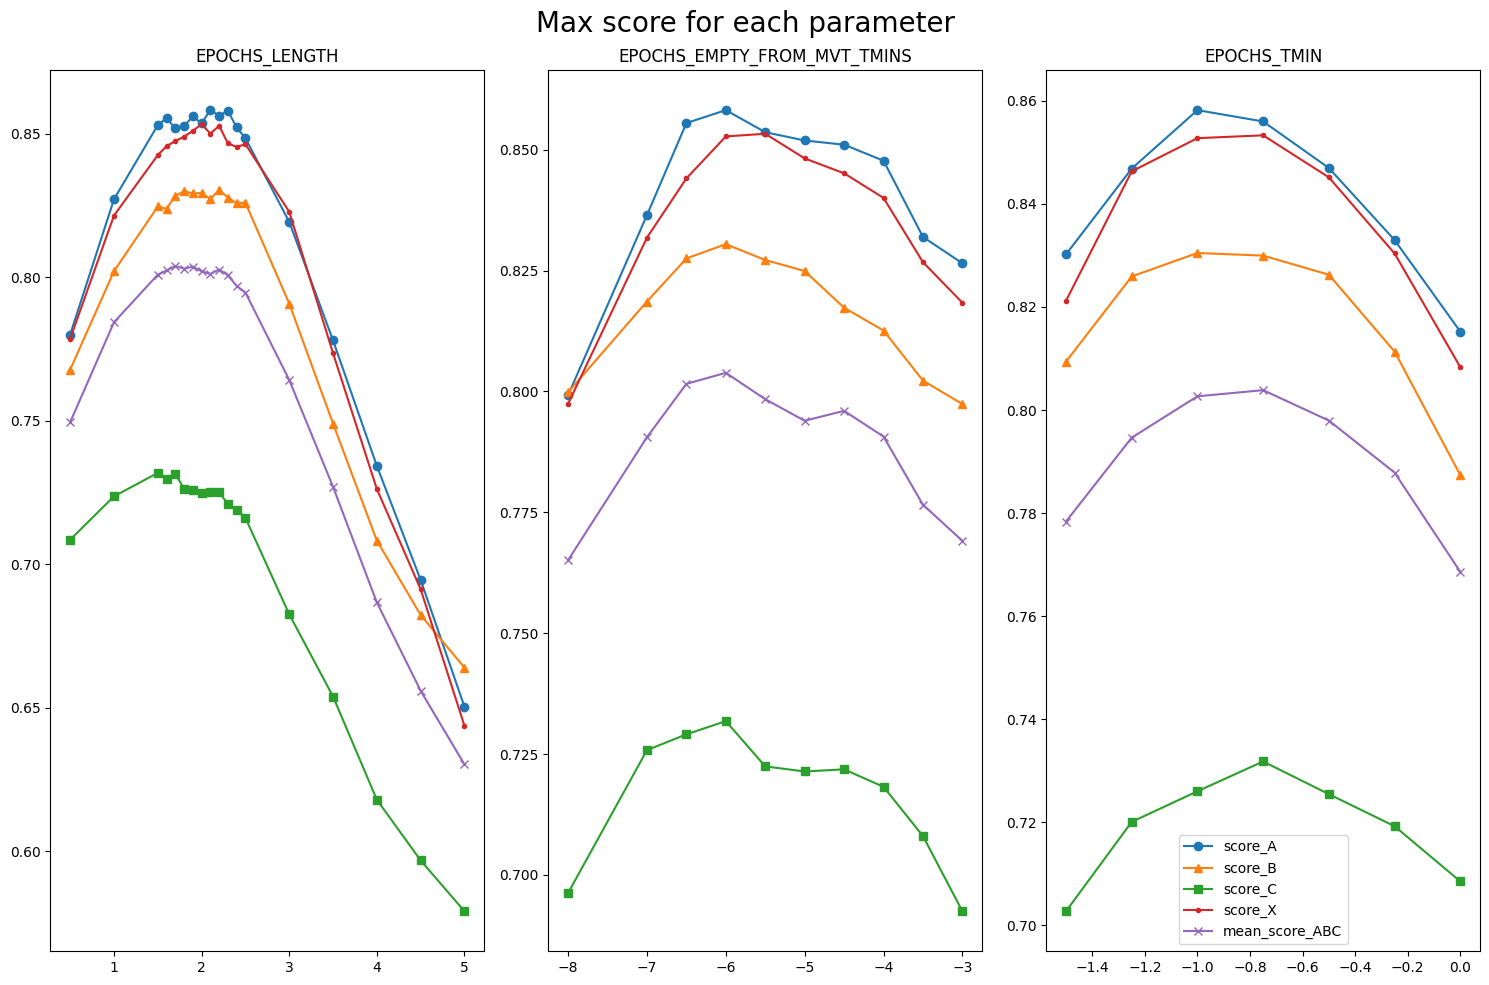

In [36]:
param = ['EPOCHS_LENGTH', 'EPOCHS_EMPTY_FROM_MVT_TMINS', 'EPOCHS_TMIN']
data_grid_search['mean_score_ABC'] = data_grid_search[['score_A', 'score_B', 'score_C']].mean(axis=1)
fig, ax = plt.subplots(1, 3, figsize=(15, 10))
fig.suptitle('Max score for each parameter', fontsize=20)

for p in param:
    max_score_A = data_grid_search.groupby(p)['score_A'].max()
    max_score_B = data_grid_search.groupby(p)['score_B'].max()
    max_score_C = data_grid_search.groupby(p)['score_C'].max()
    max_score_X = data_grid_search.groupby(p)['score_X'].max()
    max_score_ABC = data_grid_search.groupby(p)['mean_score_ABC'].max()

    max_score_A = max_score_A.reset_index()
    max_score_B = max_score_B.reset_index()
    max_score_C = max_score_C.reset_index()
    max_score_X = max_score_X.reset_index()
    max_score_ABC = max_score_ABC.reset_index()

    ax[param.index(p)].plot(max_score_A[p], max_score_A['score_A'], label='score_A', marker='o')
    ax[param.index(p)].plot(max_score_B[p], max_score_B['score_B'], label='score_B', marker='^')
    ax[param.index(p)].plot(max_score_C[p], max_score_C['score_C'], label='score_C', marker='s')
    ax[param.index(p)].plot(max_score_C[p], max_score_X['score_X'], label='score_X', marker='.')
    ax[param.index(p)].plot(max_score_C[p], max_score_ABC['mean_score_ABC'], label='mean_score_ABC', marker='x')
    ax[param.index(p)].set_title(p)


plt.tight_layout()
plt.legend()
plt.show()



### Results grid 2

In [ ]:
# sort by mean A,B and C
data_grid_search['mean_score_A_B_C'] = data_grid_search[['score_A', 'score_B', 'score_C']].mean(axis=1)
data_grid_search = data_grid_search.sort_values(by='mean_score_A_B_C', ascending=False)
data_grid_search.head(10)


,EPOCHS_TMIN,EPOCHS_LENGTH,EPOCHS_EMPTY_FROM_MVT_TMINS,FMIN,FMAX,CLASSIFIER,RANDOM_STATE,N_SPLIT,NUMBER_OF_SESSIONS,score_A,score_B,score_C,score_X,duration,memory,version,mean_score_A_B_C
549,-0.75,1.7,-6.0,1,40,SVC,42,4,89,0.851809,0.828355,0.731415,0.847417,1092.726076,2900.332031,V2,0.803860
417,-0.75,1.9,-6.0,1,40,SVC,42,4,89,0.855998,0.829166,0.725803,0.850985,1081.308213,2965.953125,V2,0.803656
483,-0.75,1.8,-6.0,1,40,SVC,42,4,89,0.852656,0.829972,0.726307,0.848961,1109.303615,2875.285156,V2,0.802979
284,-1.00,2.2,-6.0,1,40,SVC,42,4,89,0.856323,0.830475,0.721212,0.852763,901.241177,3215.625000,V2,0.802670
615,-0.75,1.6,-6.0,1,40,SVC,42,4,89,0.855468,0.821874,0.729653,0.844721,1088.645246,2912.597656,V2,0.802331
350,-0.75,2.0,-6.0,1,40,SVC,42,4,89,0.853556,0.829329,0.723284,0.848220,826.473378,2892.242188,V2,0.802056
761,-0.75,1.9,-6.5,1,40,SVC,42,4,89,0.855529,0.827516,0.721685,0.844005,1107.675889,2869.480469,V2,0.801577
630,-1.00,2.2,-6.5,1,40,SVC,42,4,89,0.851971,0.827024,0.724994,0.844064,1120.972077,3258.347656,V2,0.801330
351,-1.00,2.1,-6.0,1,40,SVC,42,4,89,0.858205,0.827227,0.717973,0.850008,805.331966,3093.089844,V2,0.801135
283,-0.75,2.1,-6.0,1,40,SVC,42,4,89,0.851205,0.827064,0.725040,0.849126,833.136293,3161.933594,V2,0.801103


## Grid search 3: FMIN and FMAX

### Preprocessing hyperparameters : 
```python
params_dict_lists = { #V3
    'EPOCHS_TMIN': [-0.75], # 1
    'EPOCHS_LENGTH': [1.7], # 1
    'EPOCHS_EMPTY_FROM_MVT_TMIN': [-6], # 1
    'FMIN': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], # 10
    'FMAX': [30, 35, 40, 45, 50, 55, 60, 65, 70, 75], # 10
} # 100 iterations, time estimation: ((100//(8*6)) * 11)/60 = 0.4h (8 nodes, 6 cores each, estimation 11 minutes per iteration)
## DONE

params_dict_lists_exclude = None
params_exclude_rules = None

```
-----------------------------

### Pipeline hyperparameters : 
```python
cov = Covariances()
ts = TangentSpace()
ss = StandardScaler()
clf = SVC()
pipeline = Pipeline([('cov', cov), ('ts', ts), ('ss', ss), ('clf', clf)])

pipelines_dict_lists = {
    'pipeline_1': {
    'pipeline': [pipeline],
    'clf__C': [1], # 1
    'clf__gamma': ['scale'], # 1
    'clf__kernel': ['rbf'], # 1
    'cov__estimator': ['oas'], # 1
    },
    #'pipeline_2':{}
}

pipelines_dict_lists_exclude = None
pipelines_exclude_rules = None
```

In [3]:
RESULT_PATH = './../../src/training/hyperparameters_movement/results/'
NAME_RESULTS = 'hyperparam_preproc_movement_SVM_V3'
SAVE_PATH = './results/'
NAME_SAVE = 'hyperparam_preproc_movement_SVM_aggregated_filter'

In [3]:
# agregate results one file is one hyperparameter setting
files = [f for f in os.listdir(RESULT_PATH) if f.startswith(NAME_RESULTS) and f.endswith('.csv')]
files = [os.path.join(RESULT_PATH, f) for f in files]
dfs = []
for file in files:
    df = pd.read_csv(file)
    dfs.append(df)
result_df = pd.concat(dfs, ignore_index=True)

# Remove same lines
result_df = result_df.drop_duplicates()

# Save aggregated results
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)
result_df.to_csv(os.path.join(SAVE_PATH, NAME_SAVE + '.csv'), index=False)

In [5]:
result_df = pd.read_csv(SAVE_PATH + NAME_SAVE + ".csv")

In [4]:
result_df.describe()

,EPOCHS_TMIN,EPOCHS_LENGTH,EPOCHS_EMPTY_FROM_MVT_TMINS,FMIN,FMAX,RANDOM_STATE,N_SPLIT,NUMBER_OF_SESSIONS,score_A,score_B,score_C,score_X,duration,memory
count,99.00,9.900000e+01,99.0,99.000000,99.000000,99.0,99.0,99.0,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000
mean,-0.75,1.700000e+00,-6.0,4.545455,52.727273,42.0,4.0,89.0,0.842573,0.817093,0.724616,0.838870,882.336882,2670.681542
std,0.00,6.695238e-16,0.0,2.865248,14.326241,0.0,0.0,0.0,0.008288,0.012853,0.013869,0.008927,150.257379,53.049050
min,-0.75,1.700000e+00,-6.0,0.000000,30.000000,42.0,4.0,89.0,0.831815,0.799366,0.702279,0.826794,676.814874,2461.652344
25%,-0.75,1.700000e+00,-6.0,2.000000,40.000000,42.0,4.0,89.0,0.835395,0.806248,0.711528,0.831740,796.914409,2627.445312
50%,-0.75,1.700000e+00,-6.0,5.000000,55.000000,42.0,4.0,89.0,0.840979,0.813771,0.728797,0.835231,811.014292,2680.664062
75%,-0.75,1.700000e+00,-6.0,7.000000,65.000000,42.0,4.0,89.0,0.850678,0.829082,0.734330,0.846825,998.112320,2709.148438
max,-0.75,1.700000e+00,-6.0,9.000000,75.000000,42.0,4.0,89.0,0.859797,0.840188,0.757794,0.859303,1664.143433,2781.921875


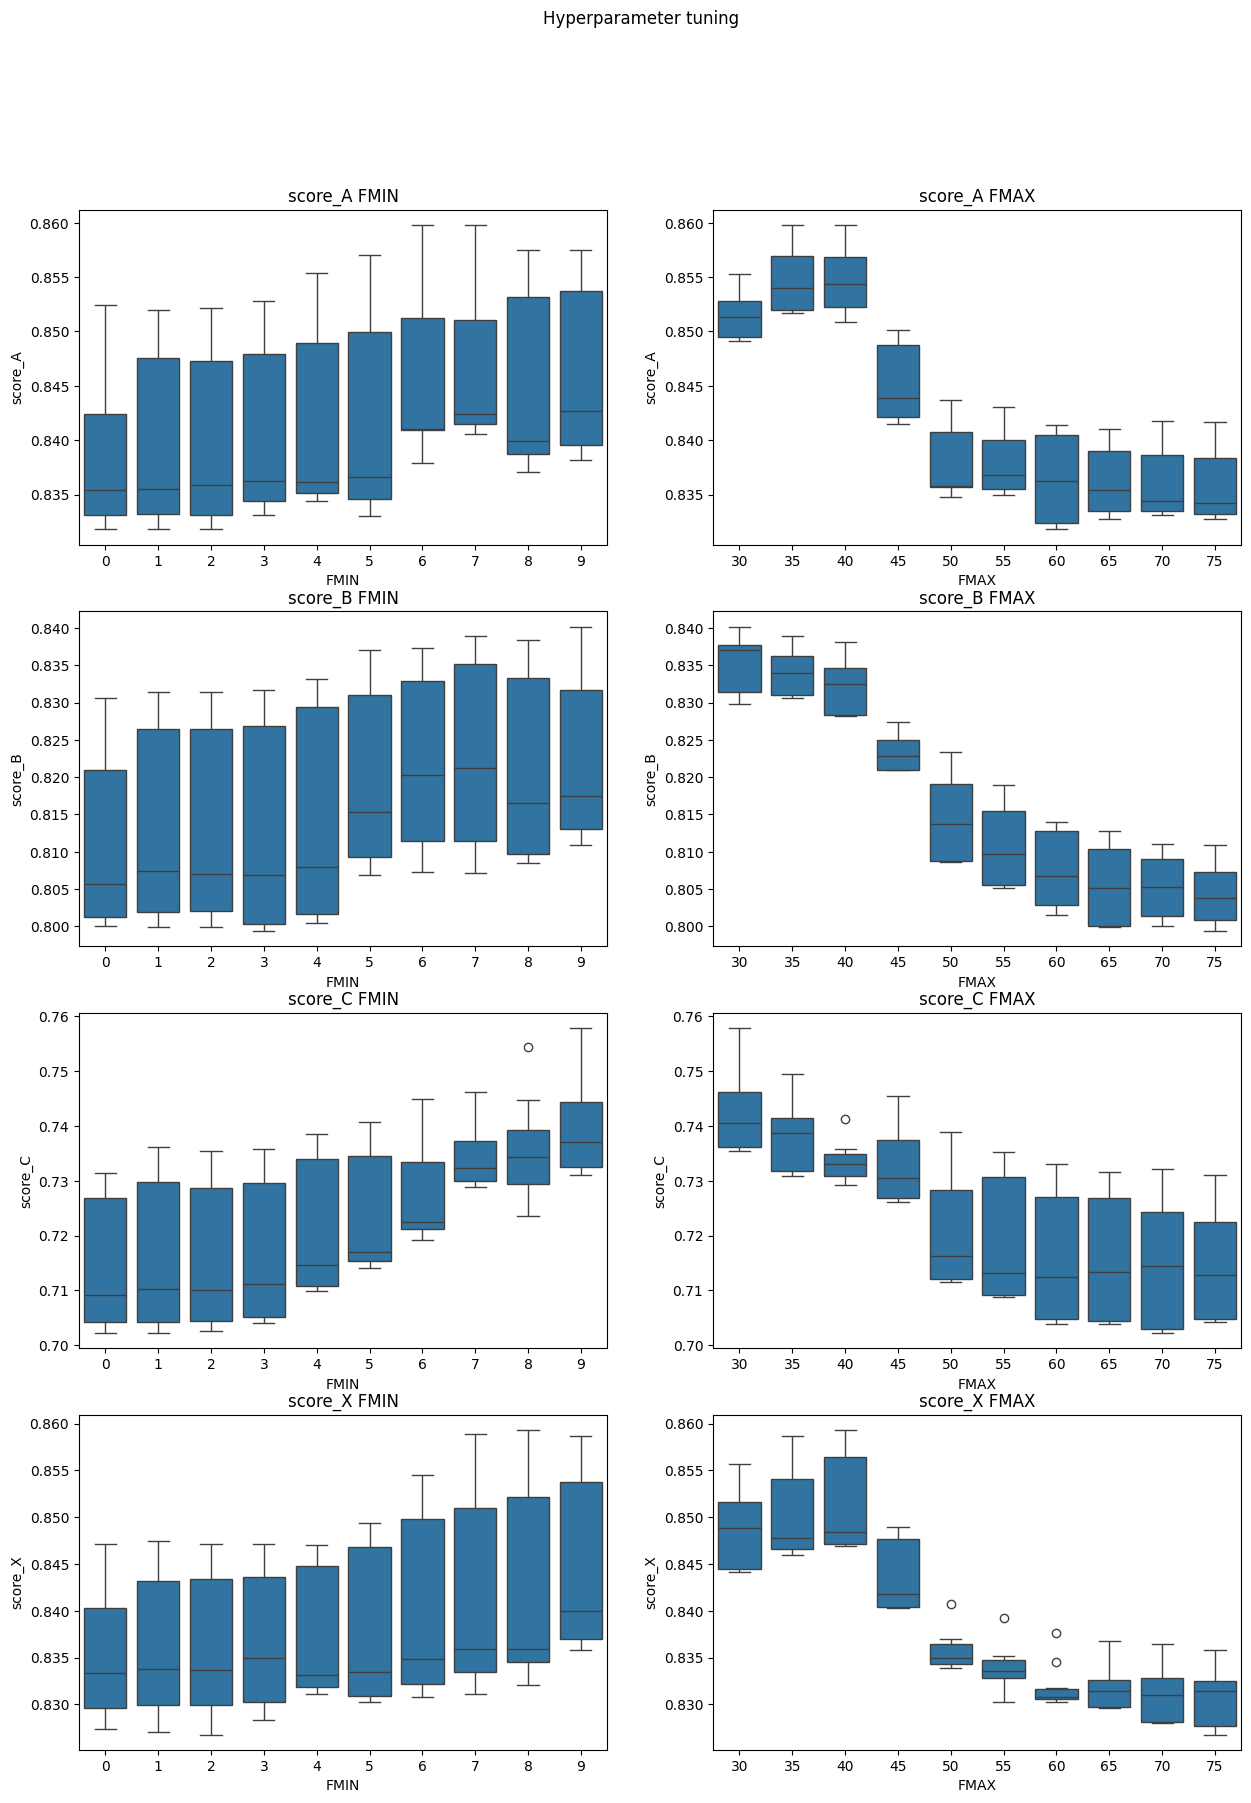

In [6]:
scores = ['score_A', 'score_B', 'score_C', 'score_X']
parameters = ['FMIN', 'FMAX']

fig, ax = plt.subplots(4, 2, figsize=(15, 20))
fig.suptitle('Hyperparameter tuning')

for i, score in enumerate(scores):
    for j, param in enumerate(parameters):
        sns.boxplot(x=param, y=score, data=result_df, ax=ax[i, j])
        ax[i, j].set_title(score + ' ' + param)
plt.show()

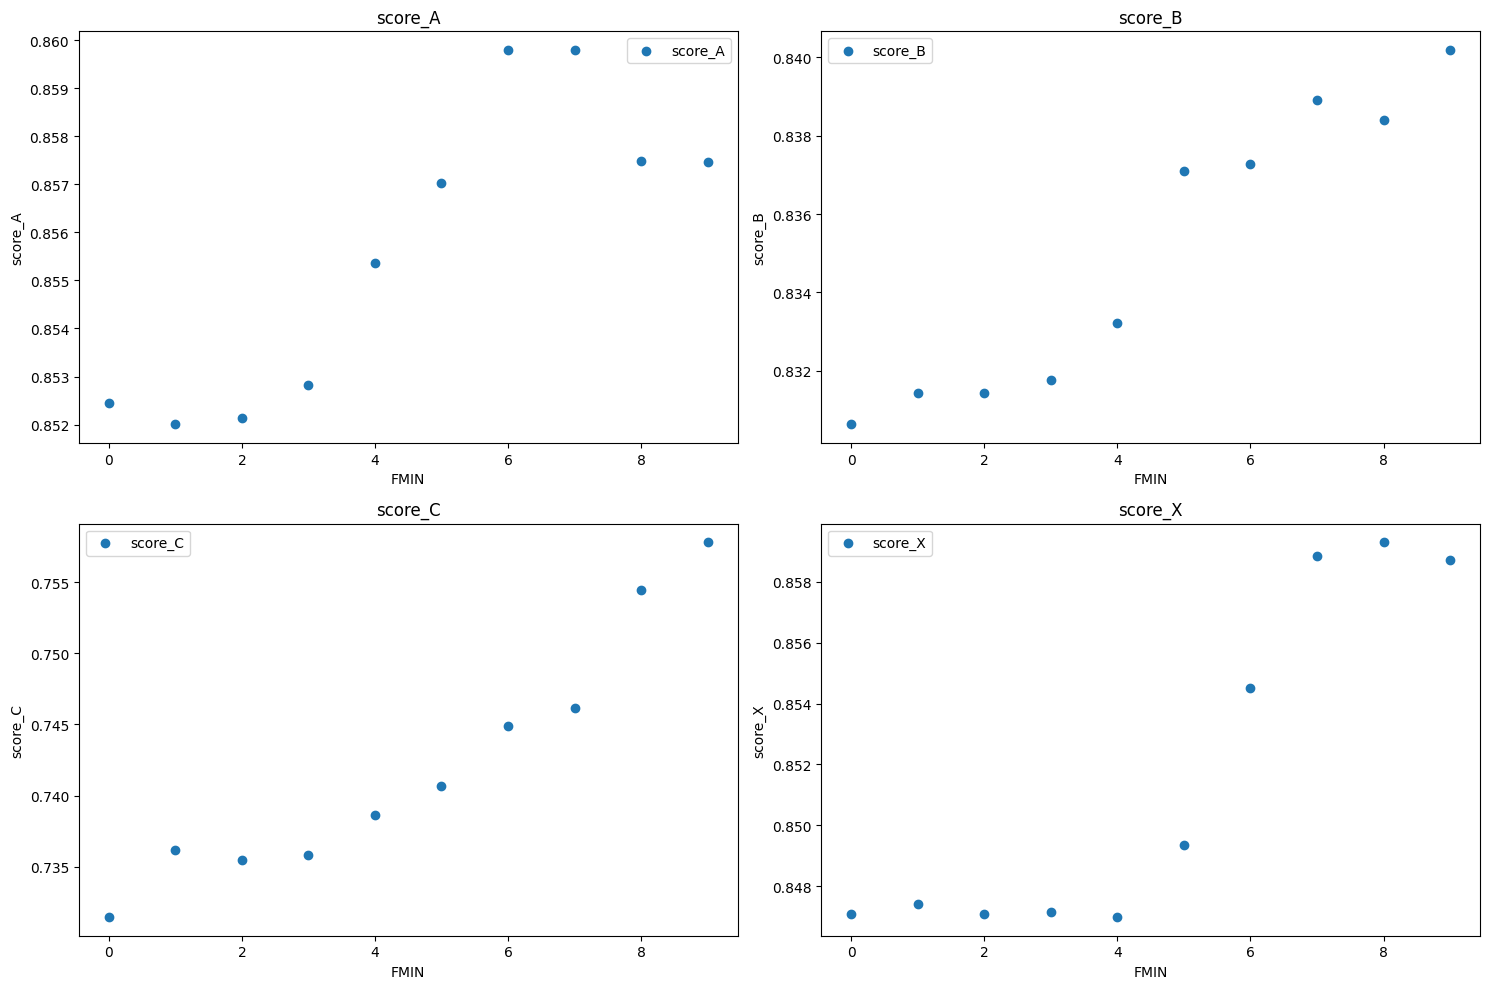

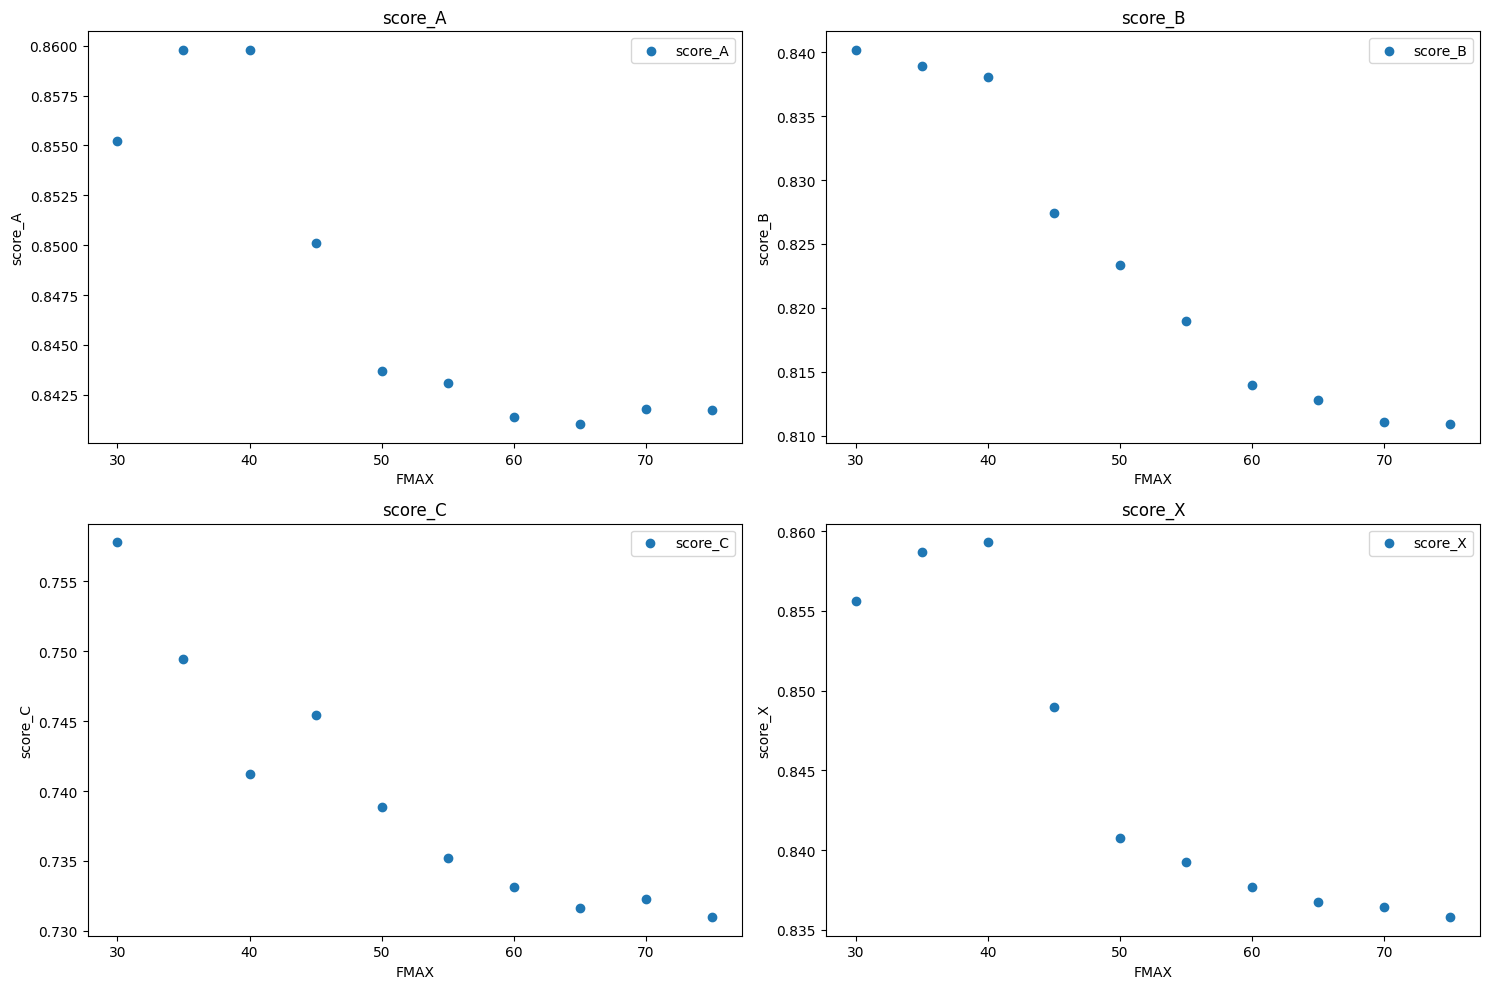

In [7]:
# max for each param and score
param = ['FMIN', 'FMAX']
for p in param:
    max_score_A = result_df.groupby(p)['score_A'].max()
    max_score_B = result_df.groupby(p)['score_B'].max()
    max_score_C = result_df.groupby(p)['score_C'].max()
    max_score_X = result_df.groupby(p)['score_X'].max()

    max_score_A = max_score_A.reset_index()
    max_score_B = max_score_B.reset_index()
    max_score_C = max_score_C.reset_index()
    max_score_X = max_score_X.reset_index()

    fig, ax = plt.subplots(2, 2, figsize=(15, 10))
    ax[0, 0].scatter(max_score_A[p], max_score_A['score_A'], label='score_A', marker='o')
    ax[0, 0].set_xlabel(p)
    ax[0, 0].set_ylabel('score_A')
    ax[0, 0].set_title('score_A')
    ax[0, 0].legend()

    ax[0, 1].scatter(max_score_B[p], max_score_B['score_B'], label='score_B', marker='o')
    ax[0, 1].set_xlabel(p)
    ax[0, 1].set_ylabel('score_B')
    ax[0, 1].set_title('score_B')
    ax[0, 1].legend()

    ax[1, 0].scatter(max_score_C[p], max_score_C['score_C'], label='score_C', marker='o')
    ax[1, 0].set_xlabel(p)
    ax[1, 0].set_ylabel('score_C')
    ax[1, 0].set_title('score_C')
    ax[1, 0].legend()

    ax[1, 1].scatter(max_score_X[p], max_score_X['score_X'], label='score_X', marker='o')
    ax[1, 1].set_xlabel(p)
    ax[1, 1].set_ylabel('score_X')
    ax[1, 1].set_title('score_X')
    ax[1, 1].legend()
    plt.tight_layout()
    plt.show()

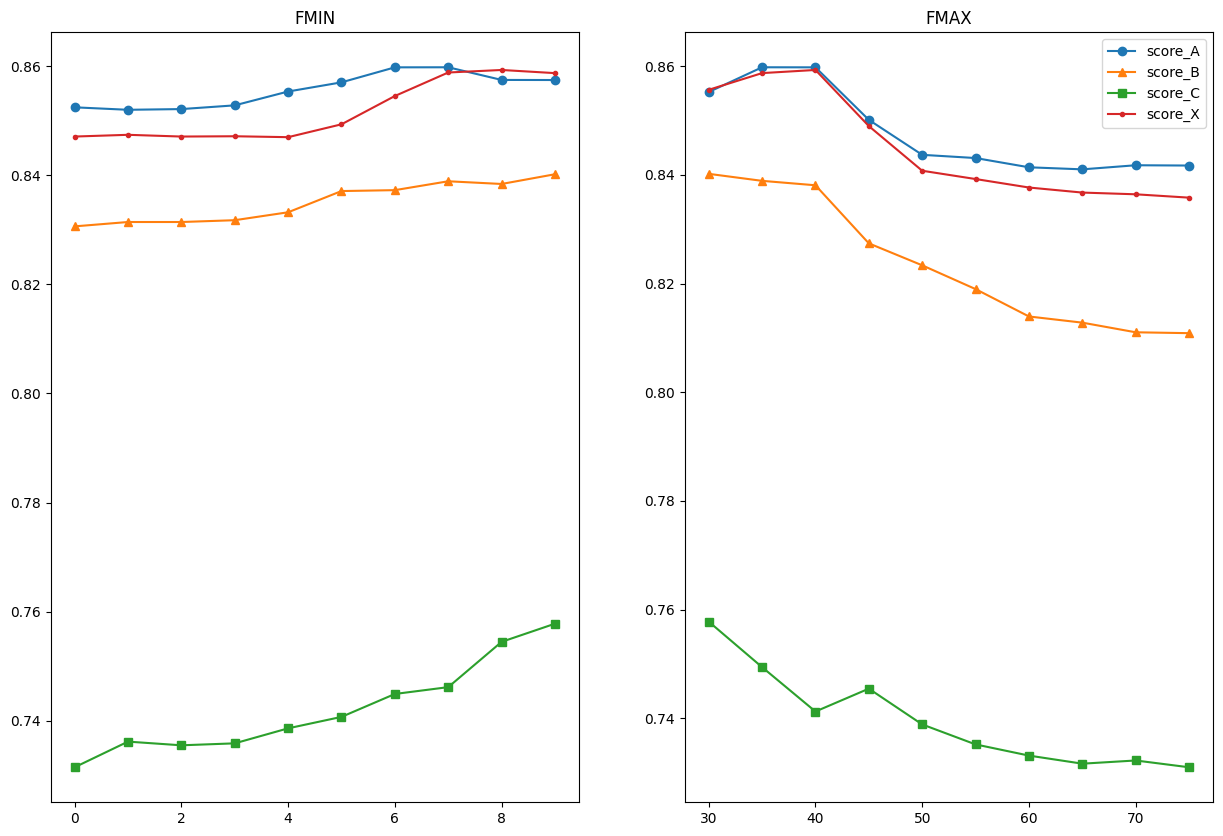

In [22]:
param = ['FMIN', 'FMAX']
fig, ax = plt.subplots(1, 2, figsize=(15, 10))

for p in param:
    max_score_A = result_df.groupby(p)['score_A'].max()
    max_score_B = result_df.groupby(p)['score_B'].max()
    max_score_C = result_df.groupby(p)['score_C'].max()
    max_score_X = result_df.groupby(p)['score_X'].max()

    max_score_A = max_score_A.reset_index()
    max_score_B = max_score_B.reset_index()
    max_score_C = max_score_C.reset_index()
    max_score_X = max_score_X.reset_index()

    ax[param.index(p)].plot(max_score_A[p], max_score_A['score_A'], label='score_A', marker='o')
    ax[param.index(p)].plot(max_score_B[p], max_score_B['score_B'], label='score_B', marker='^')
    ax[param.index(p)].plot(max_score_C[p], max_score_C['score_C'], label='score_C', marker='s')
    ax[param.index(p)].plot(max_score_C[p], max_score_X['score_X'], label='score_X', marker='.')
    ax[param.index(p)].set_title(p)

    
plt.legend()
plt.show()



In [6]:
# sort by score A

result_df = result_df.sort_values(by='score_A', ascending=False)
result_df.head(10)

,EPOCHS_TMIN,EPOCHS_LENGTH,EPOCHS_EMPTY_FROM_MVT_TMINS,FMIN,FMAX,CLASSIFIER,RANDOM_STATE,N_SPLIT,NUMBER_OF_SESSIONS,score_A,score_B,score_C,score_X,duration,memory
2,-0.75,1.7,-6,7,35,SVC,42,4,89,0.859797,0.838899,0.740500,0.853440,786.030905,2641.343750
16,-0.75,1.7,-6,6,40,SVC,42,4,89,0.859786,0.834676,0.732764,0.854529,792.794644,2617.445312
29,-0.75,1.7,-6,7,40,SVC,42,4,89,0.858781,0.838085,0.733203,0.858840,780.278005,2698.507812
15,-0.75,1.7,-6,8,35,SVC,42,4,89,0.857477,0.836143,0.744734,0.857734,788.197136,2708.261719
28,-0.75,1.7,-6,9,35,SVC,42,4,89,0.857460,0.836298,0.749415,0.858726,791.761098,2686.222656
3,-0.75,1.7,-6,5,40,SVC,42,4,89,0.857035,0.833044,0.735728,0.849343,802.321606,2686.617188
42,-0.75,1.7,-6,8,40,SVC,42,4,89,0.856225,0.836950,0.733871,0.859303,816.828262,2677.593750
54,-0.75,1.7,-6,9,40,SVC,42,4,89,0.855883,0.834515,0.741249,0.857110,806.850150,2548.648438
64,-0.75,1.7,-6,4,35,SVC,42,4,89,0.855355,0.832730,0.736837,0.845952,796.947018,2767.132812
1,-0.75,1.7,-6,9,30,SVC,42,4,89,0.855241,0.840188,0.757794,0.855651,1664.143433,2659.332031


In [7]:
# sort by score C

result_df = result_df.sort_values(by='score_C', ascending=False)
result_df.head(10)

,EPOCHS_TMIN,EPOCHS_LENGTH,EPOCHS_EMPTY_FROM_MVT_TMINS,FMIN,FMAX,CLASSIFIER,RANDOM_STATE,N_SPLIT,NUMBER_OF_SESSIONS,score_A,score_B,score_C,score_X,duration,memory
1,-0.75,1.7,-6,9,30,SVC,42,4,89,0.855241,0.840188,0.757794,0.855651,1664.143433,2659.332031
87,-0.75,1.7,-6,8,30,SVC,42,4,89,0.854380,0.838405,0.754464,0.853447,1082.240226,2620.183594
28,-0.75,1.7,-6,9,35,SVC,42,4,89,0.857460,0.836298,0.749415,0.858726,791.761098,2686.222656
75,-0.75,1.7,-6,7,30,SVC,42,4,89,0.851352,0.837765,0.746162,0.851647,1081.756599,2734.210938
79,-0.75,1.7,-6,9,45,SVC,42,4,89,0.849299,0.823502,0.745457,0.848196,1100.331105,2619.808594
63,-0.75,1.7,-6,6,30,SVC,42,4,89,0.852497,0.837272,0.744909,0.850958,785.212160,2624.703125
15,-0.75,1.7,-6,8,35,SVC,42,4,89,0.857477,0.836143,0.744734,0.857734,788.197136,2708.261719
88,-0.75,1.7,-6,6,35,SVC,42,4,89,0.852978,0.836786,0.741765,0.854314,1091.314209,2728.886719
54,-0.75,1.7,-6,9,40,SVC,42,4,89,0.855883,0.834515,0.741249,0.857110,806.850150,2548.648438
76,-0.75,1.7,-6,5,35,SVC,42,4,89,0.854959,0.835161,0.740707,0.848804,1061.002745,2760.929688


### Results grid 3

In [8]:
result_df['score_A_B_C_mean'] = (result_df['score_A'] + result_df['score_B'] + result_df['score_C'])/3
result_df = result_df.sort_values(by='score_A_B_C_mean', ascending=False)
result_df.head(10)

,EPOCHS_TMIN,EPOCHS_LENGTH,EPOCHS_EMPTY_FROM_MVT_TMINS,FMIN,FMAX,CLASSIFIER,RANDOM_STATE,N_SPLIT,NUMBER_OF_SESSIONS,score_A,score_B,score_C,score_X,duration,memory,score_A_B_C_mean
1,-0.75,1.7,-6,9,30,SVC,42,4,89,0.855241,0.840188,0.757794,0.855651,1664.143433,2659.332031,0.817741
87,-0.75,1.7,-6,8,30,SVC,42,4,89,0.854380,0.838405,0.754464,0.853447,1082.240226,2620.183594,0.815750
28,-0.75,1.7,-6,9,35,SVC,42,4,89,0.857460,0.836298,0.749415,0.858726,791.761098,2686.222656,0.814391
2,-0.75,1.7,-6,7,35,SVC,42,4,89,0.859797,0.838899,0.740500,0.853440,786.030905,2641.343750,0.813065
15,-0.75,1.7,-6,8,35,SVC,42,4,89,0.857477,0.836143,0.744734,0.857734,788.197136,2708.261719,0.812785
75,-0.75,1.7,-6,7,30,SVC,42,4,89,0.851352,0.837765,0.746162,0.851647,1081.756599,2734.210938,0.811760
63,-0.75,1.7,-6,6,30,SVC,42,4,89,0.852497,0.837272,0.744909,0.850958,785.212160,2624.703125,0.811559
54,-0.75,1.7,-6,9,40,SVC,42,4,89,0.855883,0.834515,0.741249,0.857110,806.850150,2548.648438,0.810549
88,-0.75,1.7,-6,6,35,SVC,42,4,89,0.852978,0.836786,0.741765,0.854314,1091.314209,2728.886719,0.810509
76,-0.75,1.7,-6,5,35,SVC,42,4,89,0.854959,0.835161,0.740707,0.848804,1061.002745,2760.929688,0.810276


## Grid search 4: FMIN and FMAX with more points

### Preprocessing hyperparameters : 
```python
params_dict_lists = { #V4
    'EPOCHS_TMIN': [-0.75], # 1
    'EPOCHS_LENGTH': [1.7], # 1
    'EPOCHS_EMPTY_FROM_MVT_TMIN': [-6], # 1
    'FMIN': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 
             24, 25, 26, 27, 28, 29, 30, 35, 40], # 32
    'FMAX': [10, 15, 20, 25, 30, 32.5, 35, 37.5, 40, 42.5, 45, 47.5, 50, 52.5, 55, 60, 65, 70, 75], # 19
} # 32*19 = 608 combinations
## PENDING

params_dict_lists_exclude = None

params_exclude_rules = [
    lambda params: params['FMIN'] >= params['FMAX'],
]
```
-----------------------------

### Pipeline hyperparameters : 
```python
cov = Covariances()
ts = TangentSpace()
ss = StandardScaler()
clf = SVC()
pipeline = Pipeline([('cov', cov), ('ts', ts), ('ss', ss), ('clf', clf)])

pipelines_dict_lists = {
    'pipeline_1': {
    'pipeline': [pipeline],
    'clf__C': [1], # 1
    'clf__gamma': ['scale'], # 1
    'clf__kernel': ['rbf'], # 1
    'cov__estimator': ['oas'], # 1
    },
    #'pipeline_2':{}
}

pipelines_dict_lists_exclude = None
pipelines_exclude_rules = None
```

In [24]:
RESULT_PATH = './../../src/training/RIEMANN_SVM_MVT_grid_search/results/V4'
NAME_RESULTS = 'RSVM_MVT_search_preproc_V4'
SAVE_PATH = './results/'
NAME_SAVE = 'hyperparam_preproc_movement_SVM_aggregated_filter_V4'

In [25]:
# agregate results one file is one hyperparameter setting
files = [f for f in os.listdir(RESULT_PATH) if f.startswith(NAME_RESULTS) and f.endswith('.csv')]
files = [os.path.join(RESULT_PATH, f) for f in files]
dfs = []
for file in files:
    df = pd.read_csv(file)
    dfs.append(df)
result_df = pd.concat(dfs, ignore_index=True)

# Remove same lines
result_df = result_df.drop_duplicates()

# Save aggregated results
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)
result_df.to_csv(os.path.join(SAVE_PATH, NAME_SAVE + '.csv'), index=False)

In [26]:
result_df = pd.read_csv(SAVE_PATH + NAME_SAVE + ".csv")

In [27]:
# # agregate results
# result_df_old = pd.read_csv(SAVE_PATH + 'hyperparam_preproc_movement_SVM_aggregated_filter.csv')
# result_df = pd.concat([result_df_old, result_df], ignore_index=True)
# result_df.drop_duplicates(inplace=True)

In [28]:
result_df.describe()

,EPOCHS_EMPTY_FROM_MVT_TMIN,EPOCHS_LENGTH,EPOCHS_TMIN,FMAX,FMIN,score_A,score_B,score_C,score_X,duration_preprocessing,duration_train,memory,NUMBER_OF_SESSIONS,RANDOM_STATE,N_SPLIT,VERSION
count,556.0,5.560000e+02,556.00,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.000000,556.0,556.0,556.0,556.0
mean,-6.0,1.700000e+00,-0.75,45.656475,15.116906,0.806135,0.788315,0.698640,0.808178,513.902948,335.850078,2148.323158,-1.0,42.0,4.0,4.0
std,0.0,2.222446e-16,0.00,16.031944,9.794041,0.057969,0.047867,0.050874,0.057966,23.105619,17.664074,335.073353,0.0,0.0,0.0,0.0
min,-6.0,1.700000e+00,-0.75,10.000000,0.000000,0.595579,0.635748,0.544241,0.600966,471.600618,267.260379,1775.699219,-1.0,42.0,4.0,4.0
25%,-6.0,1.700000e+00,-0.75,35.000000,7.000000,0.790993,0.770062,0.672472,0.791475,499.606534,323.851032,1782.426758,-1.0,42.0,4.0,4.0
50%,-6.0,1.700000e+00,-0.75,45.000000,14.000000,0.832012,0.805511,0.714679,0.835768,508.606613,335.824640,2172.750000,-1.0,42.0,4.0,4.0
75%,-6.0,1.700000e+00,-0.75,55.000000,23.000000,0.842226,0.822248,0.736454,0.844460,522.955707,346.817735,2490.382812,-1.0,42.0,4.0,4.0
max,-6.0,1.700000e+00,-0.75,75.000000,40.000000,0.858419,0.841116,0.768481,0.864006,625.365353,394.433946,2648.746094,-1.0,42.0,4.0,4.0


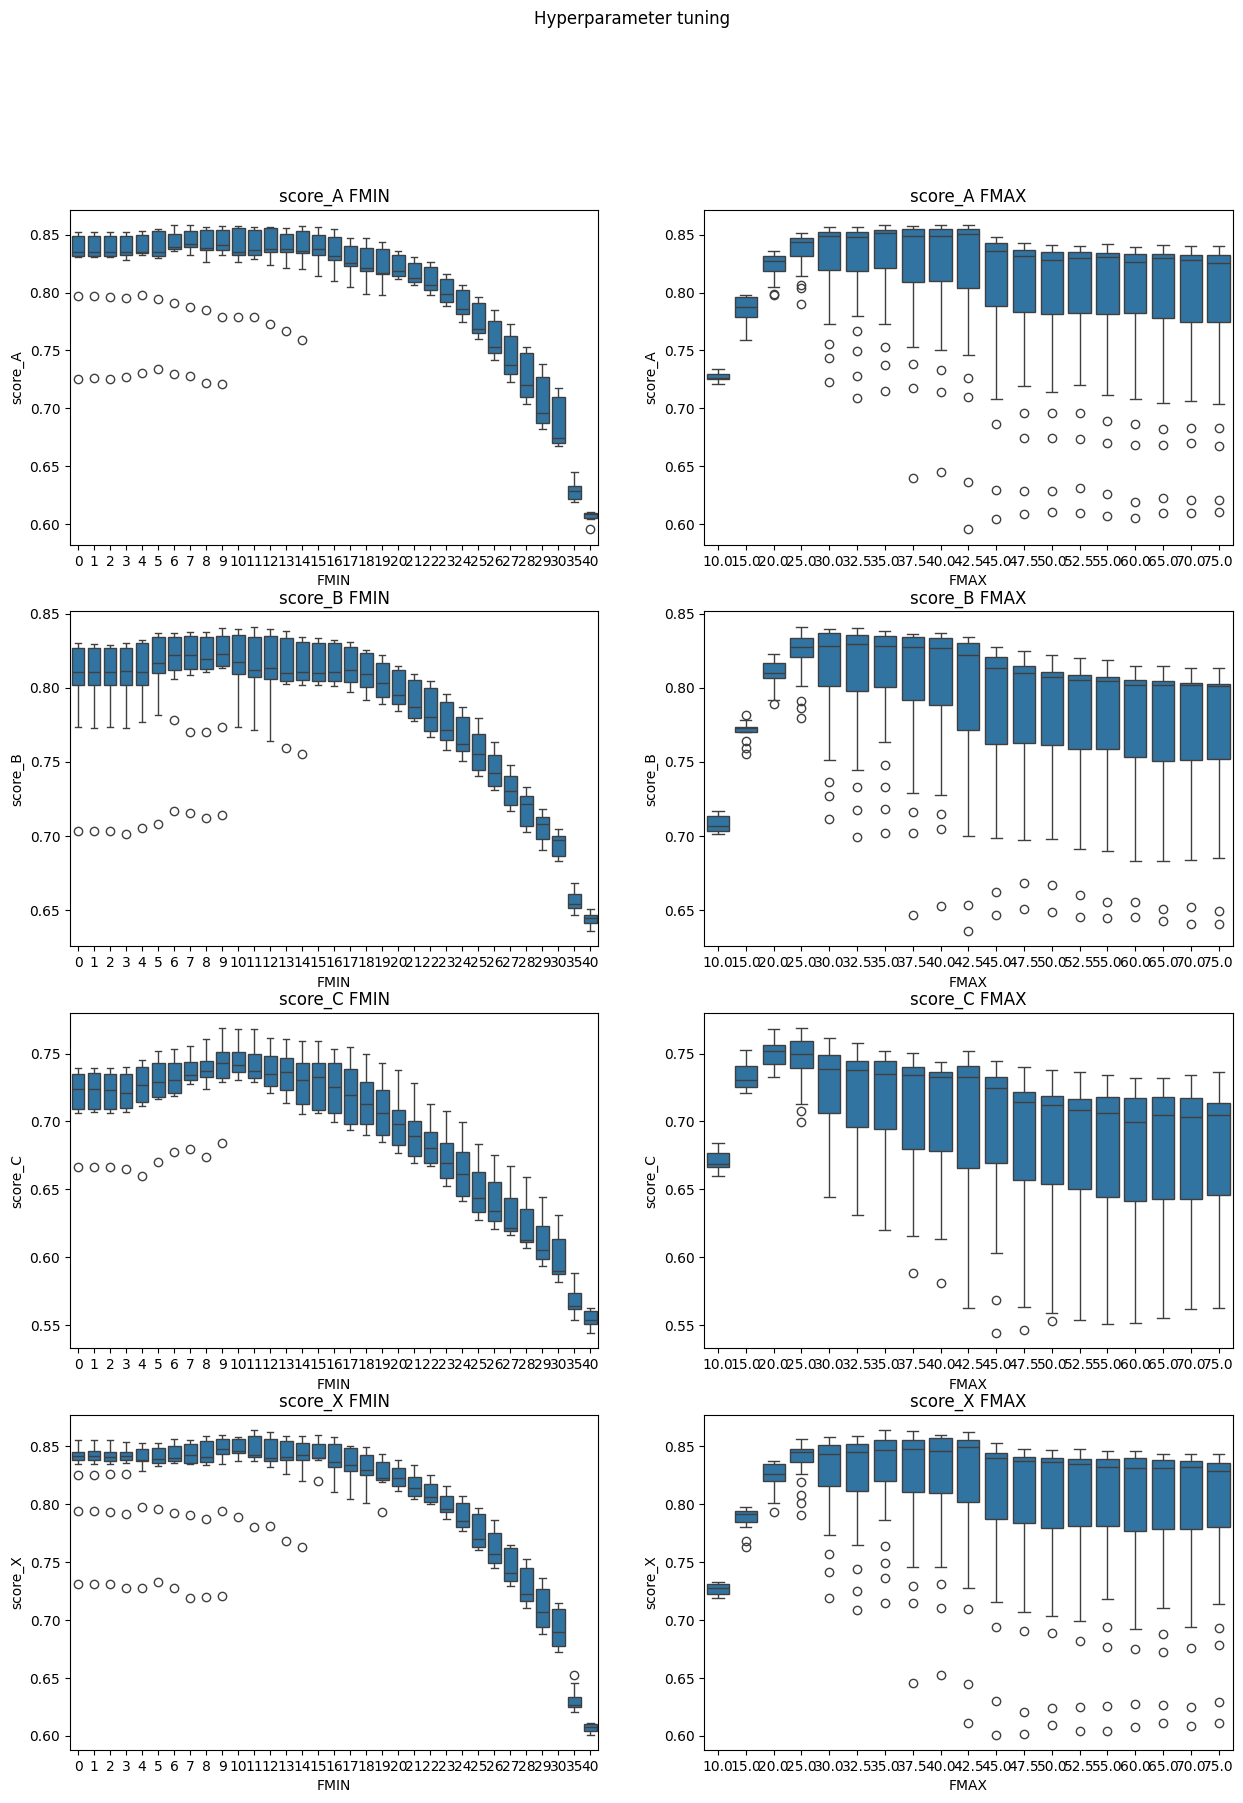

In [29]:
scores = ['score_A', 'score_B', 'score_C', 'score_X']
parameters = ['FMIN', 'FMAX']

fig, ax = plt.subplots(4, 2, figsize=(15, 20))
fig.suptitle('Hyperparameter tuning')

for i, score in enumerate(scores):
    for j, param in enumerate(parameters):
        sns.boxplot(x=param, y=score, data=result_df, ax=ax[i, j])
        ax[i, j].set_title(score + ' ' + param)
plt.show()

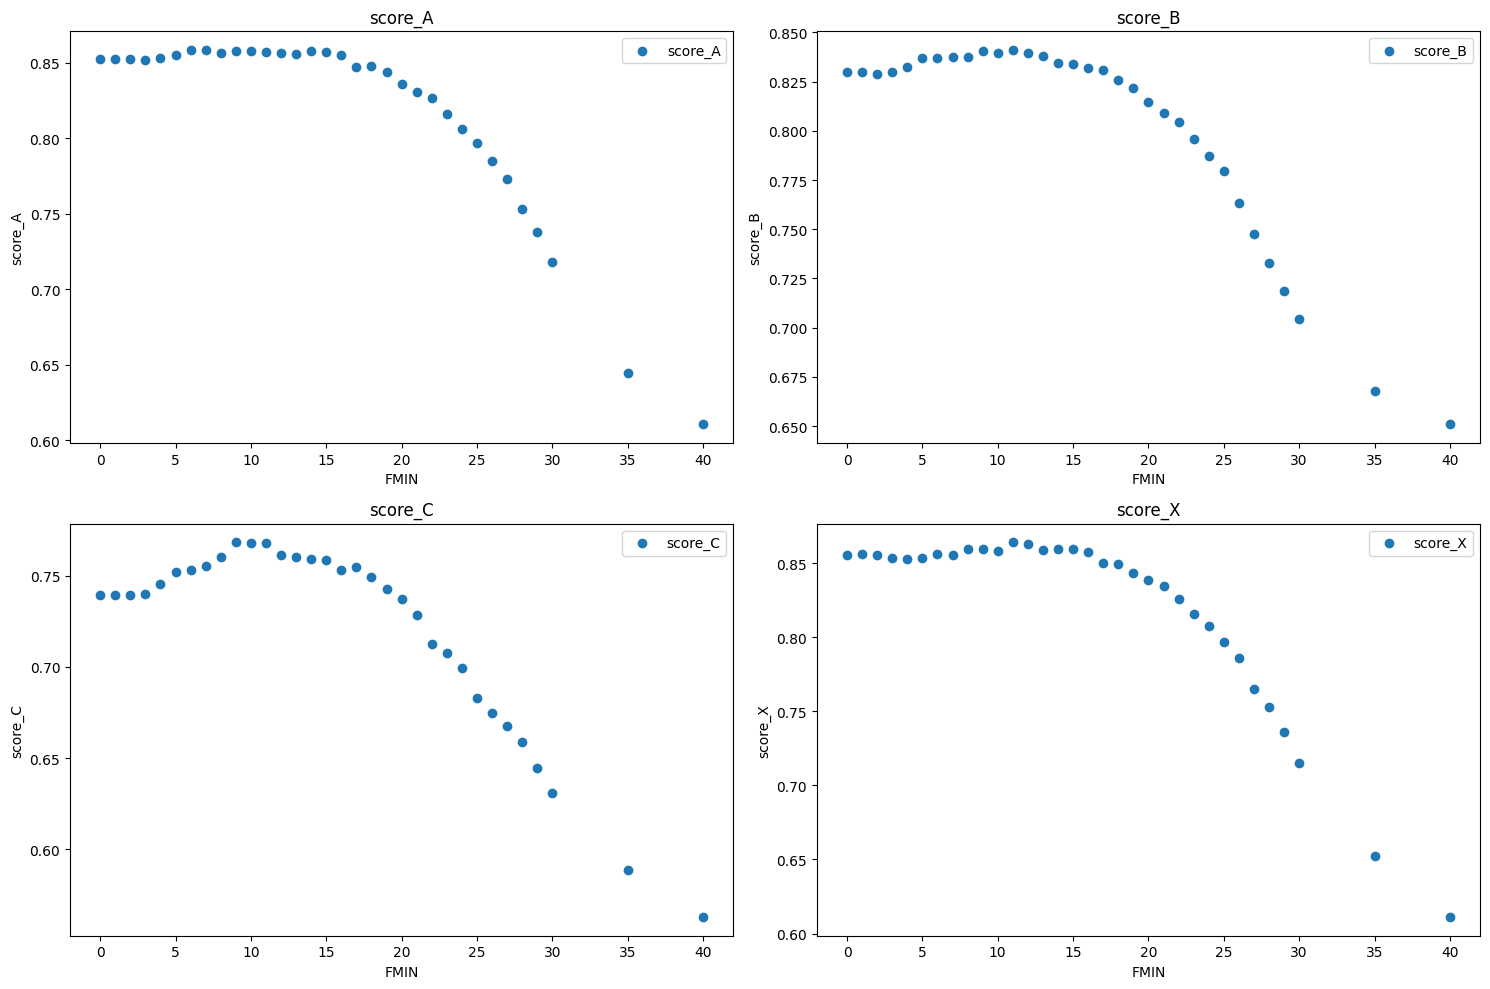

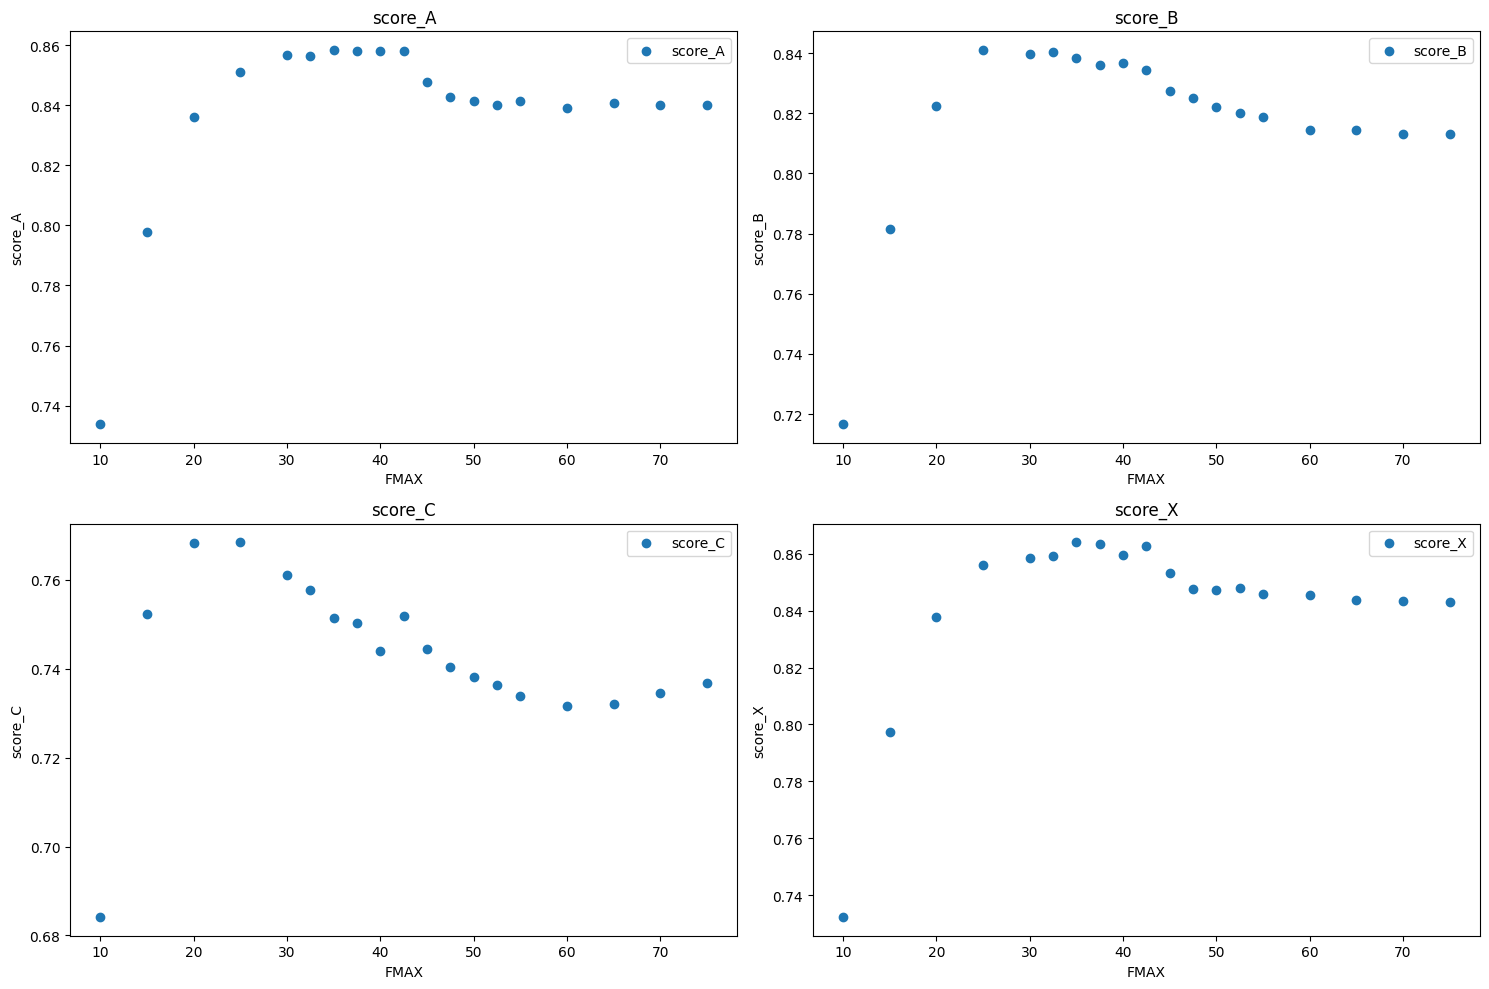

In [30]:
# max for each param and score
param = ['FMIN', 'FMAX']
for p in param:
    max_score_A = result_df.groupby(p)['score_A'].max()
    max_score_B = result_df.groupby(p)['score_B'].max()
    max_score_C = result_df.groupby(p)['score_C'].max()
    max_score_X = result_df.groupby(p)['score_X'].max()

    max_score_A = max_score_A.reset_index()
    max_score_B = max_score_B.reset_index()
    max_score_C = max_score_C.reset_index()
    max_score_X = max_score_X.reset_index()

    fig, ax = plt.subplots(2, 2, figsize=(15, 10))
    ax[0, 0].scatter(max_score_A[p], max_score_A['score_A'], label='score_A', marker='o')
    ax[0, 0].set_xlabel(p)
    ax[0, 0].set_ylabel('score_A')
    ax[0, 0].set_title('score_A')
    ax[0, 0].legend()

    ax[0, 1].scatter(max_score_B[p], max_score_B['score_B'], label='score_B', marker='o')
    ax[0, 1].set_xlabel(p)
    ax[0, 1].set_ylabel('score_B')
    ax[0, 1].set_title('score_B')
    ax[0, 1].legend()

    ax[1, 0].scatter(max_score_C[p], max_score_C['score_C'], label='score_C', marker='o')
    ax[1, 0].set_xlabel(p)
    ax[1, 0].set_ylabel('score_C')
    ax[1, 0].set_title('score_C')
    ax[1, 0].legend()

    ax[1, 1].scatter(max_score_X[p], max_score_X['score_X'], label='score_X', marker='o')
    ax[1, 1].set_xlabel(p)
    ax[1, 1].set_ylabel('score_X')
    ax[1, 1].set_title('score_X')
    ax[1, 1].legend()
    plt.tight_layout()
    plt.show()

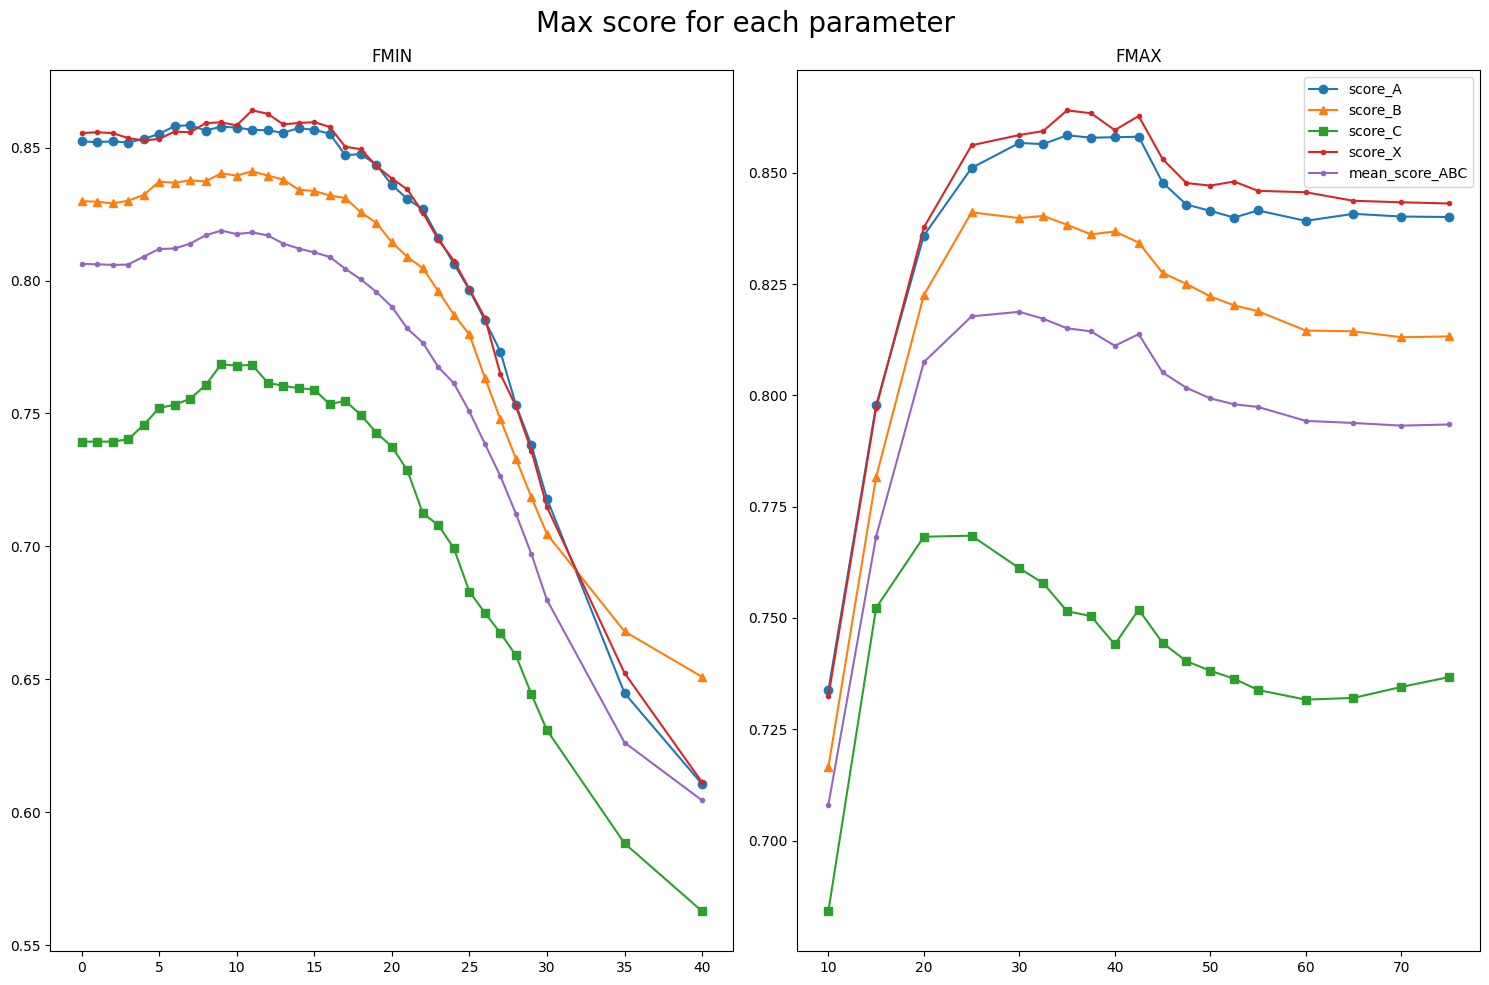

In [35]:
param = ['FMIN', 'FMAX']
result_df['mean_score_ABC'] = (result_df['score_A'] + result_df['score_B'] + result_df['score_C'])/3
fig, ax = plt.subplots(1, 2, figsize=(15, 10))
fig.suptitle('Max score for each parameter', fontsize=20)

for p in param:
    max_score_A = result_df.groupby(p)['score_A'].max()
    max_score_B = result_df.groupby(p)['score_B'].max()
    max_score_C = result_df.groupby(p)['score_C'].max()
    max_score_X = result_df.groupby(p)['score_X'].max()
    max_score_ABC = result_df.groupby(p)['mean_score_ABC'].max()
    
    max_score_A = max_score_A.reset_index()
    max_score_B = max_score_B.reset_index()
    max_score_C = max_score_C.reset_index()
    max_score_X = max_score_X.reset_index()
    max_score_ABC = max_score_ABC.reset_index()

    ax[param.index(p)].plot(max_score_A[p], max_score_A['score_A'], label='score_A', marker='o')
    ax[param.index(p)].plot(max_score_B[p], max_score_B['score_B'], label='score_B', marker='^')
    ax[param.index(p)].plot(max_score_C[p], max_score_C['score_C'], label='score_C', marker='s')
    ax[param.index(p)].plot(max_score_C[p], max_score_X['score_X'], label='score_X', marker='.')
    ax[param.index(p)].plot(max_score_C[p], max_score_ABC['mean_score_ABC'], label='mean_score_ABC', marker='.')
    ax[param.index(p)].set_title(p)

plt.tight_layout() 
plt.legend()
plt.show()



In [32]:
# sort by score A

result_df = result_df.sort_values(by='score_A', ascending=False)
result_df.head(10)

,EPOCHS_EMPTY_FROM_MVT_TMIN,EPOCHS_LENGTH,EPOCHS_TMIN,FMAX,FMIN,pipeline,cov__estimator,score_A,score_B,score_C,...,VERSION,PATH_RESULTS,NAME_RESULTS,PATH_DATA_PROCESSED,FOLDER_RESULTS_ITERATIONS,NAME_RESULTS_ITERATIONS,LOG_FOLDER,SAVE_EACH_ITERATION,REMOVE_ITERATIONS,REMOVE_DATA_PROCESSED
157,-6,1.7,-0.75,35.0,7,"Pipeline(steps=[('cov', Covariances(estimator=...",oas,0.858419,0.837652,0.745514,...,4,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True
29,-6,1.7,-0.75,42.5,6,"Pipeline(steps=[('cov', Covariances(estimator=...",oas,0.858087,0.834319,0.740999,...,4,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True
25,-6,1.7,-0.75,40.0,6,"Pipeline(steps=[('cov', Covariances(estimator=...",oas,0.857973,0.833983,0.736201,...,4,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True
239,-6,1.7,-0.75,42.5,9,"Pipeline(steps=[('cov', Covariances(estimator=...",oas,0.857879,0.832162,0.749615,...,4,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True
231,-6,1.7,-0.75,37.5,9,"Pipeline(steps=[('cov', Covariances(estimator=...",oas,0.857867,0.834815,0.750424,...,4,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True
21,-6,1.7,-0.75,37.5,6,"Pipeline(steps=[('cov', Covariances(estimator=...",oas,0.857679,0.835147,0.741753,...,4,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True
95,-6,1.7,-0.75,40.0,7,"Pipeline(steps=[('cov', Covariances(estimator=...",oas,0.857622,0.836815,0.736455,...,4,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True
309,-6,1.7,-0.75,42.5,10,"Pipeline(steps=[('cov', Covariances(estimator=...",oas,0.857532,0.831824,0.751890,...,4,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True
366,-6,1.7,-0.75,35.0,10,"Pipeline(steps=[('cov', Covariances(estimator=...",oas,0.857410,0.837141,0.749453,...,4,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True
30,-6,1.7,-0.75,42.5,14,"Pipeline(steps=[('cov', Covariances(estimator=...",oas,0.857332,0.827007,0.744780,...,4,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True


In [39]:
# sort by score B
# display all columns
pd.set_option('display.max_columns', None)

result_df = result_df.sort_values(by='score_B', ascending=False)
result_df.head(10)

,EPOCHS_EMPTY_FROM_MVT_TMIN,EPOCHS_LENGTH,EPOCHS_TMIN,FMAX,FMIN,pipeline,cov__estimator,score_A,score_B,score_C,score_X,duration_preprocessing,duration_train,memory,FILE_PATH,NUMBER_OF_SESSIONS,RANDOM_STATE,N_SPLIT,BINARY_CLASSIFICATION,VERSION,PATH_RESULTS,NAME_RESULTS,PATH_DATA_PROCESSED,FOLDER_RESULTS_ITERATIONS,NAME_RESULTS_ITERATIONS,LOG_FOLDER,SAVE_EACH_ITERATION,REMOVE_ITERATIONS,REMOVE_DATA_PROCESSED
7,-6,1.7,-0.75,25.0,11,"Pipeline(steps=[('cov', Covariances(estimator=...",oas,0.851087,0.841116,0.759311,0.855573,529.314919,322.242246,2371.648438,./../../../data/raw/Data_npy/,-1,42,4,True,4,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True
362,-6,1.7,-0.75,32.5,9,"Pipeline(steps=[('cov', Covariances(estimator=...",oas,0.853499,0.840302,0.757816,0.858076,483.937810,321.946245,2262.410156,./../../../data/raw/Data_npy/,-1,42,4,True,4,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True
496,-6,1.7,-0.75,30.0,9,"Pipeline(steps=[('cov', Covariances(estimator=...",oas,0.855315,0.839804,0.761170,0.856552,504.977638,313.033469,2172.750000,./../../../data/raw/Data_npy/,-1,42,4,True,4,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True
500,-6,1.7,-0.75,32.5,11,"Pipeline(steps=[('cov', Covariances(estimator=...",oas,0.853689,0.839636,0.754769,0.859362,492.760995,310.266478,2172.750000,./../../../data/raw/Data_npy/,-1,42,4,True,4,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True
80,-6,1.7,-0.75,30.0,11,"Pipeline(steps=[('cov', Covariances(estimator=...",oas,0.856687,0.839632,0.757944,0.858463,531.014192,321.138590,2584.617188,./../../../data/raw/Data_npy/,-1,42,4,True,4,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True
431,-6,1.7,-0.75,32.5,10,"Pipeline(steps=[('cov', Covariances(estimator=...",oas,0.855609,0.839468,0.754597,0.855919,607.293883,318.861791,1783.718750,./../../../data/raw/Data_npy/,-1,42,4,True,4,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True
150,-6,1.7,-0.75,30.0,12,"Pipeline(steps=[('cov', Covariances(estimator=...",oas,0.856502,0.839460,0.754969,0.855946,516.749683,316.873442,2512.367188,./../../../data/raw/Data_npy/,-1,42,4,True,4,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True
14,-6,1.7,-0.75,32.5,12,"Pipeline(steps=[('cov', Covariances(estimator=...",oas,0.855798,0.839309,0.749077,0.856906,500.850038,320.025067,2381.925781,./../../../data/raw/Data_npy/,-1,42,4,True,4,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True
435,-6,1.7,-0.75,35.0,11,"Pipeline(steps=[('cov', Covariances(estimator=...",oas,0.855099,0.838312,0.749002,0.864006,556.703583,316.443423,2434.300781,./../../../data/raw/Data_npy/,-1,42,4,True,4,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True
84,-6,1.7,-0.75,32.5,13,"Pipeline(steps=[('cov', Covariances(estimator=...",oas,0.849392,0.837981,0.744704,0.855331,501.519068,341.647486,1776.765625,./../../../data/raw/Data_npy/,-1,42,4,True,4,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True


In [40]:
# sort by score C

result_df = result_df.sort_values(by='score_C', ascending=False)
result_df.head(10)

,EPOCHS_EMPTY_FROM_MVT_TMIN,EPOCHS_LENGTH,EPOCHS_TMIN,FMAX,FMIN,pipeline,cov__estimator,score_A,score_B,score_C,score_X,duration_preprocessing,duration_train,memory,FILE_PATH,NUMBER_OF_SESSIONS,RANDOM_STATE,N_SPLIT,BINARY_CLASSIFICATION,VERSION,PATH_RESULTS,NAME_RESULTS,PATH_DATA_PROCESSED,FOLDER_RESULTS_ITERATIONS,NAME_RESULTS_ITERATIONS,LOG_FOLDER,SAVE_EACH_ITERATION,REMOVE_ITERATIONS,REMOVE_DATA_PROCESSED
424,-6,1.7,-0.75,25.0,9,"Pipeline(steps=[('cov', Covariances(estimator=...",oas,0.848792,0.835972,0.768481,0.852776,502.986998,311.912393,2565.679688,./../../../data/raw/Data_npy/,-1,42,4,True,4,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True
284,-6,1.7,-0.75,20.0,11,"Pipeline(steps=[('cov', Covariances(estimator=...",oas,0.828585,0.817360,0.768242,0.837067,513.566383,349.974257,1780.277344,./../../../data/raw/Data_npy/,-1,42,4,True,4,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True
214,-6,1.7,-0.75,20.0,10,"Pipeline(steps=[('cov', Covariances(estimator=...",oas,0.826412,0.818515,0.767977,0.837717,500.335883,335.346017,1780.265625,./../../../data/raw/Data_npy/,-1,42,4,True,4,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True
144,-6,1.7,-0.75,20.0,9,"Pipeline(steps=[('cov', Covariances(estimator=...",oas,0.832055,0.822508,0.767823,0.834570,601.815560,341.063059,1780.222656,./../../../data/raw/Data_npy/,-1,42,4,True,4,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True
493,-6,1.7,-0.75,25.0,10,"Pipeline(steps=[('cov', Covariances(estimator=...",oas,0.847438,0.837306,0.764320,0.856166,482.988009,322.598562,2611.851562,./../../../data/raw/Data_npy/,-1,42,4,True,4,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True
77,-6,1.7,-0.75,25.0,12,"Pipeline(steps=[('cov', Covariances(estimator=...",oas,0.849631,0.835464,0.761569,0.853139,529.130218,335.558477,1872.429688,./../../../data/raw/Data_npy/,-1,42,4,True,4,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True
496,-6,1.7,-0.75,30.0,9,"Pipeline(steps=[('cov', Covariances(estimator=...",oas,0.855315,0.839804,0.761170,0.856552,504.977638,313.033469,2172.750000,./../../../data/raw/Data_npy/,-1,42,4,True,4,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True
355,-6,1.7,-0.75,25.0,8,"Pipeline(steps=[('cov', Covariances(estimator=...",oas,0.845996,0.833657,0.760640,0.847740,480.710850,317.795985,2097.011719,./../../../data/raw/Data_npy/,-1,42,4,True,4,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True
147,-6,1.7,-0.75,25.0,13,"Pipeline(steps=[('cov', Covariances(estimator=...",oas,0.848201,0.833147,0.760354,0.845716,488.703691,319.872948,2636.843750,./../../../data/raw/Data_npy/,-1,42,4,True,4,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True
74,-6,1.7,-0.75,20.0,8,"Pipeline(steps=[('cov', Covariances(estimator=...",oas,0.826526,0.819518,0.760301,0.833777,533.803408,337.693191,1780.218750,./../../../data/raw/Data_npy/,-1,42,4,True,4,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True


### Results grid 4

In [41]:
# score mean A, B and C

result_df['score_A_B_C_mean'] = (result_df['score_A'] + result_df['score_B'] + result_df['score_C'])/3
result_df = result_df.sort_values(by='score_A_B_C_mean', ascending=False)
result_df.head(10)

,EPOCHS_EMPTY_FROM_MVT_TMIN,EPOCHS_LENGTH,EPOCHS_TMIN,FMAX,FMIN,pipeline,cov__estimator,score_A,score_B,score_C,score_X,duration_preprocessing,duration_train,memory,FILE_PATH,NUMBER_OF_SESSIONS,RANDOM_STATE,N_SPLIT,BINARY_CLASSIFICATION,VERSION,PATH_RESULTS,NAME_RESULTS,PATH_DATA_PROCESSED,FOLDER_RESULTS_ITERATIONS,NAME_RESULTS_ITERATIONS,LOG_FOLDER,SAVE_EACH_ITERATION,REMOVE_ITERATIONS,REMOVE_DATA_PROCESSED,score_A_B_C_mean
496,-6,1.7,-0.75,30.0,9,"Pipeline(steps=[('cov', Covariances(estimator=...",oas,0.855315,0.839804,0.761170,0.856552,504.977638,313.033469,2172.750000,./../../../data/raw/Data_npy/,-1,42,4,True,4,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True,0.818763
80,-6,1.7,-0.75,30.0,11,"Pipeline(steps=[('cov', Covariances(estimator=...",oas,0.856687,0.839632,0.757944,0.858463,531.014192,321.138590,2584.617188,./../../../data/raw/Data_npy/,-1,42,4,True,4,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True,0.818088
424,-6,1.7,-0.75,25.0,9,"Pipeline(steps=[('cov', Covariances(estimator=...",oas,0.848792,0.835972,0.768481,0.852776,502.986998,311.912393,2565.679688,./../../../data/raw/Data_npy/,-1,42,4,True,4,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True,0.817749
10,-6,1.7,-0.75,30.0,10,"Pipeline(steps=[('cov', Covariances(estimator=...",oas,0.856122,0.837971,0.758356,0.855655,545.174816,326.849850,1783.441406,./../../../data/raw/Data_npy/,-1,42,4,True,4,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True,0.817483
362,-6,1.7,-0.75,32.5,9,"Pipeline(steps=[('cov', Covariances(estimator=...",oas,0.853499,0.840302,0.757816,0.858076,483.937810,321.946245,2262.410156,./../../../data/raw/Data_npy/,-1,42,4,True,4,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True,0.817206
7,-6,1.7,-0.75,25.0,11,"Pipeline(steps=[('cov', Covariances(estimator=...",oas,0.851087,0.841116,0.759311,0.855573,529.314919,322.242246,2371.648438,./../../../data/raw/Data_npy/,-1,42,4,True,4,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True,0.817171
427,-6,1.7,-0.75,30.0,8,"Pipeline(steps=[('cov', Covariances(estimator=...",oas,0.855086,0.837141,0.758811,0.855511,543.882339,308.882150,1961.386719,./../../../data/raw/Data_npy/,-1,42,4,True,4,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True,0.817013
150,-6,1.7,-0.75,30.0,12,"Pipeline(steps=[('cov', Covariances(estimator=...",oas,0.856502,0.839460,0.754969,0.855946,516.749683,316.873442,2512.367188,./../../../data/raw/Data_npy/,-1,42,4,True,4,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True,0.816977
431,-6,1.7,-0.75,32.5,10,"Pipeline(steps=[('cov', Covariances(estimator=...",oas,0.855609,0.839468,0.754597,0.855919,607.293883,318.861791,1783.718750,./../../../data/raw/Data_npy/,-1,42,4,True,4,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True,0.816558
493,-6,1.7,-0.75,25.0,10,"Pipeline(steps=[('cov', Covariances(estimator=...",oas,0.847438,0.837306,0.764320,0.856166,482.988009,322.598562,2611.851562,./../../../data/raw/Data_npy/,-1,42,4,True,4,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True,0.816355


## Grid search 5: Hyperparameters pipeline SVC

### Preprocessing hyperparameters : 
```python
params_dict_lists = { #V5
    'EPOCHS_TMIN': [-0.75], # 1
    'EPOCHS_LENGTH': [1.7], # 1
    'EPOCHS_EMPTY_FROM_MVT_TMIN': [-6], # 1
    'FMIN': [9], # 1
    'FMAX': [30], # 1
} # 32*19 = 608 combinations
## DONE

params_dict_lists_exclude = None

params_exclude_rules = None
```
-----------------------------

### Pipeline hyperparameters : 
```python
cov = Covariances()
ts = TangentSpace()
ss = StandardScaler()
clf = SVC()
pipeline = Pipeline([('cov', cov), ('ts', ts), ('ss', ss), ('clf', clf)])

pipelines_dict_lists = {
    'pipeline_1': {
    'pipeline': [pipeline],
    'clf__C': [0.01, 0.1, 0.2, 0.5, 0.7, 1, 2, 3, 4, 5, 6, 8, 10, 20, 50, 100, 1000], # 17
    'clf__gamma': [0.01, 0.1, 0.2, 0.5, 0.7, 1, 2, 3, 4, 5, 6, 8, 10, 20, 50, 100, 1000, 'scale'], # 18
    'clf__kernel': ['rbf', 'linear', 'poly', 'sigmoid'], # 4
    'cov__estimator': ['oas', 'lwf', 'scm'], # 3
    'ts__metric': ['riemann', 'logeuclid', 'euclid'], # 3
    'ss__with_mean': [True, False], # 2
    },
    #'pipeline_2':{}
} # 17*18*4*3*3*2 = 22032 combinations -> 8 nodes, 6cores/node, 7344/48 = 459

pipelines_dict_lists_exclude = None
pipelines_exclude_rules = None
```

In [2]:
RESULT_PATH = './../../src/training/RIEMANN_SVM_MVT_grid_search/results/V5'
NAME_RESULTS = 'RSVM_MVT_search_preproc_V5'
SAVE_PATH = './results/'
NAME_SAVE = 'hyperparam_preproc_movement_SVM_aggregated_filter_V5'

In [3]:
# agregate results one file is one hyperparameter setting
files = [f for f in os.listdir(RESULT_PATH) if f.startswith(NAME_RESULTS) and f.endswith('.csv')]
files = [os.path.join(RESULT_PATH, f) for f in files]
dfs = []
for file in files:
    df = pd.read_csv(file)
    dfs.append(df)
result_df = pd.concat(dfs, ignore_index=True)

# Remove same lines
result_df = result_df.drop_duplicates()

# Save aggregated results
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)
result_df.to_csv(os.path.join(SAVE_PATH, NAME_SAVE + '.csv'), index=False)

In [4]:
result_df = pd.read_csv(SAVE_PATH + NAME_SAVE + ".csv")

In [5]:
# # agregate results
# result_df_old = pd.read_csv(SAVE_PATH + 'hyperparam_preproc_movement_SVM_aggregated_filter_V5.csv')
# result_df = pd.concat([result_df_old, result_df], ignore_index=True)
# result_df.drop_duplicates(inplace=True)

In [6]:
result_df.describe()

,EPOCHS_EMPTY_FROM_MVT_TMIN,EPOCHS_LENGTH,EPOCHS_TMIN,FMAX,FMIN,clf__C,score_A,score_B,score_C,score_X,duration_preprocessing,duration_train,memory,NUMBER_OF_SESSIONS,RANDOM_STATE,N_SPLIT,VERSION
count,5886.0,5.886000e+03,5886.00,5886.0,5886.0,5886.000000,5886.000000,5886.000000,5886.000000,5886.000000,5886.000000,5886.000000,5886.000000,5886.000000,5886.0,5886.0,5886.0
mean,-6.0,1.700000e+00,-0.75,30.0,9.0,78.526193,0.657231,0.662133,0.607997,0.659653,436.450843,216.992774,1759.665363,-0.293578,42.0,4.0,5.0
std,0.0,4.441269e-16,0.00,0.0,0.0,245.815836,0.126951,0.115441,0.082236,0.128078,99.061280,83.152151,401.029744,2.696821,0.0,0.0,0.0
min,-6.0,1.700000e+00,-0.75,30.0,9.0,0.010000,0.500000,0.493590,0.457237,0.491360,56.658707,19.168884,321.234375,-1.000000,42.0,4.0,5.0
25%,-6.0,1.700000e+00,-0.75,30.0,9.0,0.700000,0.542278,0.562377,0.537173,0.548607,455.299003,166.644981,1769.640625,-1.000000,42.0,4.0,5.0
50%,-6.0,1.700000e+00,-0.75,30.0,9.0,4.000000,0.637190,0.699754,0.594521,0.636258,455.299003,217.957872,1775.150391,-1.000000,42.0,4.0,5.0
75%,-6.0,1.700000e+00,-0.75,30.0,9.0,10.000000,0.761978,0.754110,0.684368,0.765405,469.376955,287.807374,1795.557617,-1.000000,42.0,4.0,5.0
max,-6.0,1.700000e+00,-0.75,30.0,9.0,1000.000000,0.883485,0.891026,0.758538,0.895264,469.376955,383.446066,2305.367188,10.000000,42.0,4.0,5.0


In [7]:
result_df.columns

Index(['EPOCHS_EMPTY_FROM_MVT_TMIN', 'EPOCHS_LENGTH', 'EPOCHS_TMIN', 'FMAX',
       'FMIN', 'pipeline', 'clf__C', 'clf__gamma', 'clf__kernel',
       'cov__estimator', 'score_A', 'score_B', 'score_C', 'score_X',
       'duration_preprocessing', 'duration_train', 'memory', 'FILE_PATH',
       'NUMBER_OF_SESSIONS', 'RANDOM_STATE', 'N_SPLIT',
       'BINARY_CLASSIFICATION', 'VERSION', 'PATH_RESULTS', 'NAME_RESULTS',
       'PATH_DATA_PROCESSED', 'FOLDER_RESULTS_ITERATIONS',
       'NAME_RESULTS_ITERATIONS', 'LOG_FOLDER', 'SAVE_EACH_ITERATION',
       'REMOVE_ITERATIONS', 'REMOVE_DATA_PROCESSED', 'ss__with_mean',
       'ts__metric'],
      dtype='object')

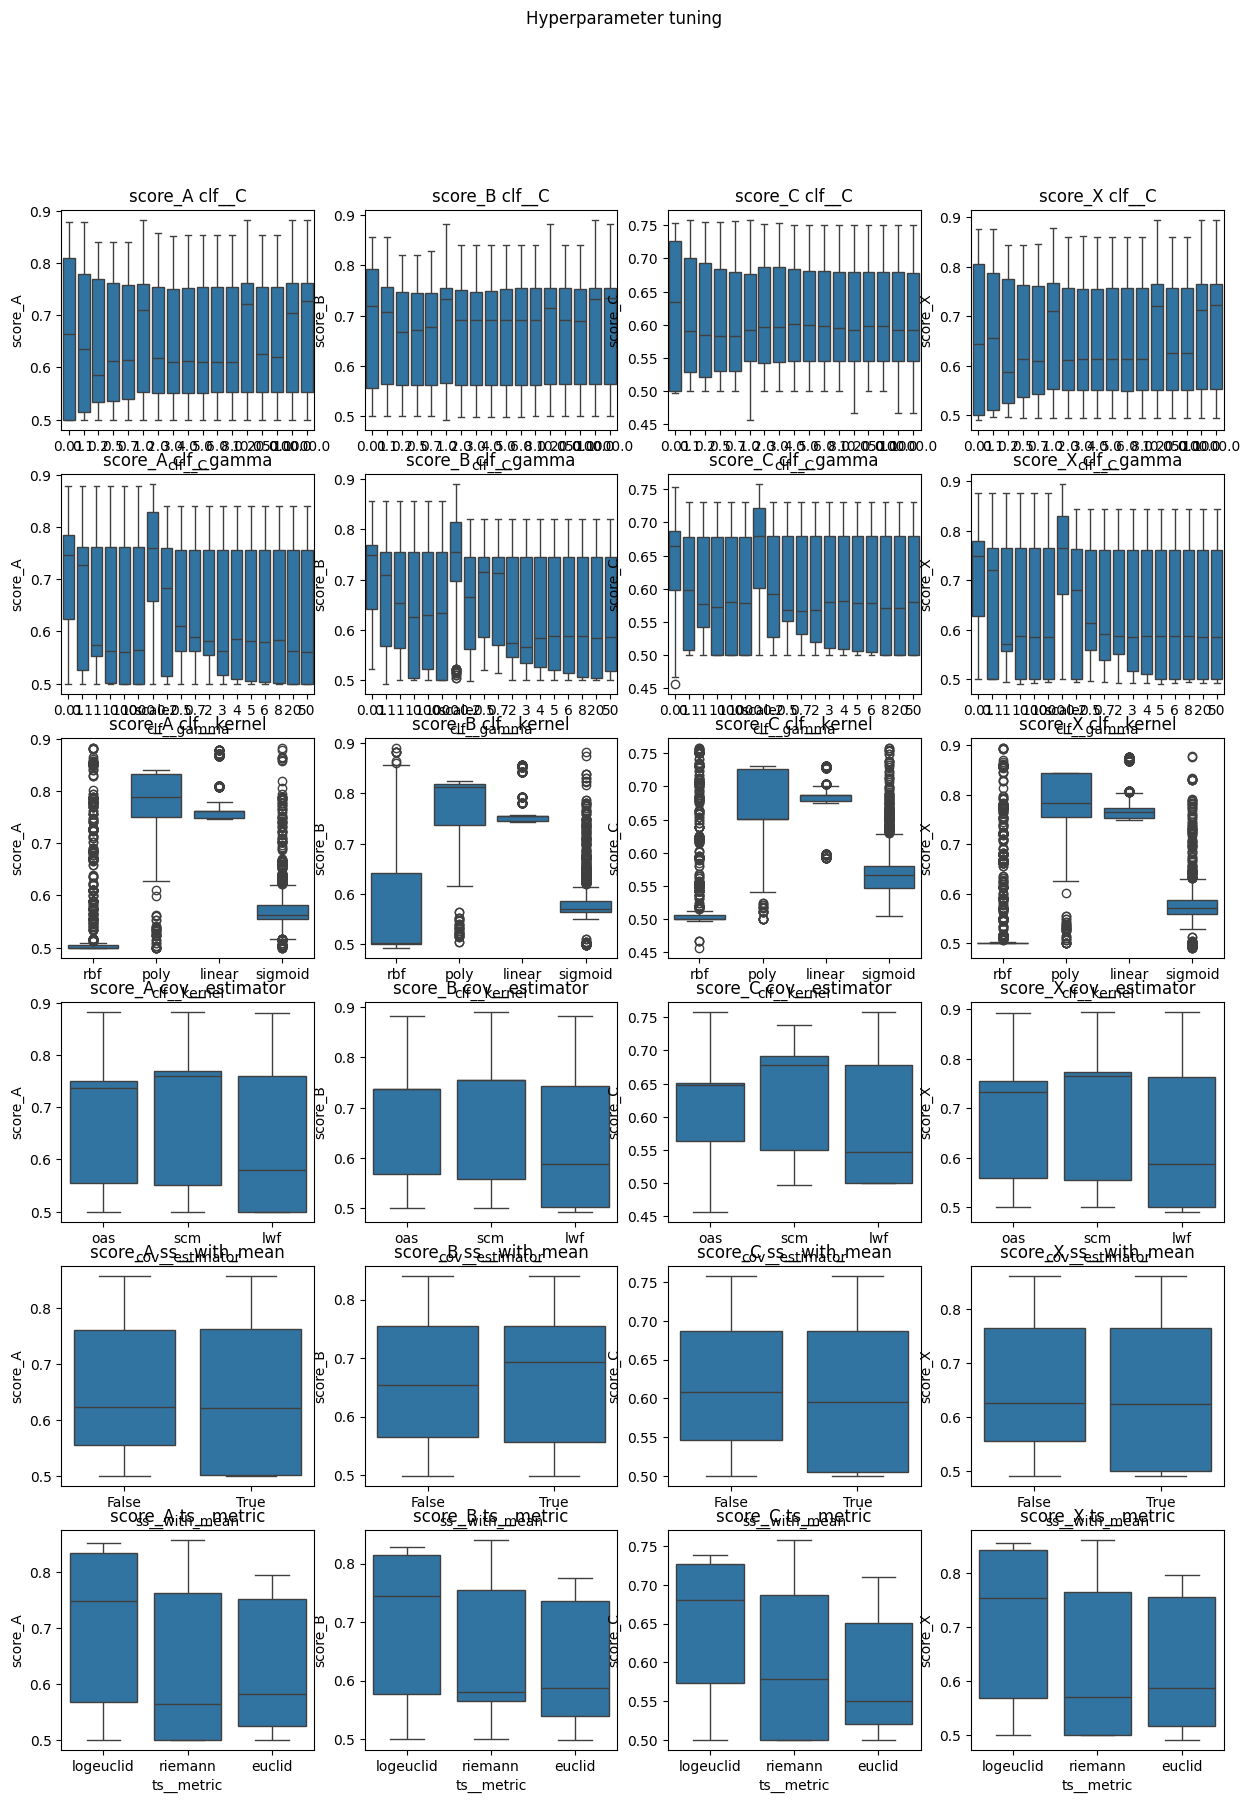

In [8]:
scores = ['score_A', 'score_B', 'score_C', 'score_X']
parameters = ['clf__C', 'clf__gamma', 'clf__kernel', 'cov__estimator',  'ss__with_mean', 'ts__metric']

fig, ax = plt.subplots(6, 4, figsize=(15, 20))
fig.suptitle('Hyperparameter tuning')

for i, score in enumerate(scores):
    for j, param in enumerate(parameters):
        sns.boxplot(x=param, y=score, data=result_df, ax=ax[j, i])
        ax[j, i].set_title(score + ' ' + param)
plt.show()

In [9]:
# Display all columns
pd.set_option('display.max_columns', None)
result_df

,EPOCHS_EMPTY_FROM_MVT_TMIN,EPOCHS_LENGTH,EPOCHS_TMIN,FMAX,FMIN,pipeline,clf__C,clf__gamma,clf__kernel,cov__estimator,score_A,score_B,score_C,score_X,duration_preprocessing,duration_train,memory,FILE_PATH,NUMBER_OF_SESSIONS,RANDOM_STATE,N_SPLIT,BINARY_CLASSIFICATION,VERSION,PATH_RESULTS,NAME_RESULTS,PATH_DATA_PROCESSED,FOLDER_RESULTS_ITERATIONS,NAME_RESULTS_ITERATIONS,LOG_FOLDER,SAVE_EACH_ITERATION,REMOVE_ITERATIONS,REMOVE_DATA_PROCESSED,ss__with_mean,ts__metric
0,-6,1.7,-0.75,30,9,"Pipeline(steps=[('cov', Covariances(estimator=...",0.01,0.01,rbf,oas,0.500000,0.602564,0.500000,0.500000,59.832656,24.139302,323.605469,./../../../data/raw/Data_npy/,10,42,4,True,5,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True,NaN,NaN
1,-6,1.7,-0.75,30,9,"Pipeline(steps=[('cov', Covariances()), ('ts',...",0.01,0.01,poly,scm,0.789332,0.812500,0.558114,0.769470,59.832656,20.335692,321.300781,./../../../data/raw/Data_npy/,10,42,4,True,5,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True,NaN,NaN
2,-6,1.7,-0.75,30,9,"Pipeline(steps=[('cov', Covariances(estimator=...",0.01,0.1,linear,lwf,0.867934,0.842949,0.597588,0.868156,59.832656,25.308517,324.304688,./../../../data/raw/Data_npy/,10,42,4,True,5,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True,NaN,NaN
3,-6,1.7,-0.75,30,9,"Pipeline(steps=[('cov', Covariances(estimator=...",0.01,1,rbf,oas,0.500000,0.519231,0.500000,0.500000,59.832656,24.020084,323.613281,./../../../data/raw/Data_npy/,10,42,4,True,5,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True,NaN,NaN
4,-6,1.7,-0.75,30,9,"Pipeline(steps=[('cov', Covariances()), ('ts',...",0.01,1,poly,scm,0.789332,0.812500,0.558114,0.769470,59.832656,20.335879,321.234375,./../../../data/raw/Data_npy/,10,42,4,True,5,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5881,-6,1.7,-0.75,30,9,"Pipeline(steps=[('cov', Covariances(estimator=...",1000.00,100,linear,oas,0.871271,0.852564,0.596491,0.872100,60.470950,23.547586,336.082031,./../../../data/raw/Data_npy/,10,42,4,True,5,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True,NaN,NaN
5882,-6,1.7,-0.75,30,9,"Pipeline(steps=[('cov', Covariances()), ('ts',...",1000.00,100,sigmoid,scm,0.556080,0.649038,0.618264,0.589131,60.470950,19.898450,332.753906,./../../../data/raw/Data_npy/,10,42,4,True,5,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True,NaN,NaN
5883,-6,1.7,-0.75,30,9,"Pipeline(steps=[('cov', Covariances(estimator=...",1000.00,1000,poly,lwf,0.791130,0.818910,0.552632,0.786874,60.470950,24.073344,661.792969,./../../../data/raw/Data_npy/,10,42,4,True,5,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True,NaN,NaN
5884,-6,1.7,-0.75,30,9,"Pipeline(steps=[('cov', Covariances(estimator=...",1000.00,scale,linear,oas,0.871271,0.852564,0.596491,0.872100,60.470950,22.993544,346.957031,./../../../data/raw/Data_npy/,10,42,4,True,5,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True,NaN,NaN


In [10]:
max_score_A = result_df.groupby('ts__metric')['score_A'].max()

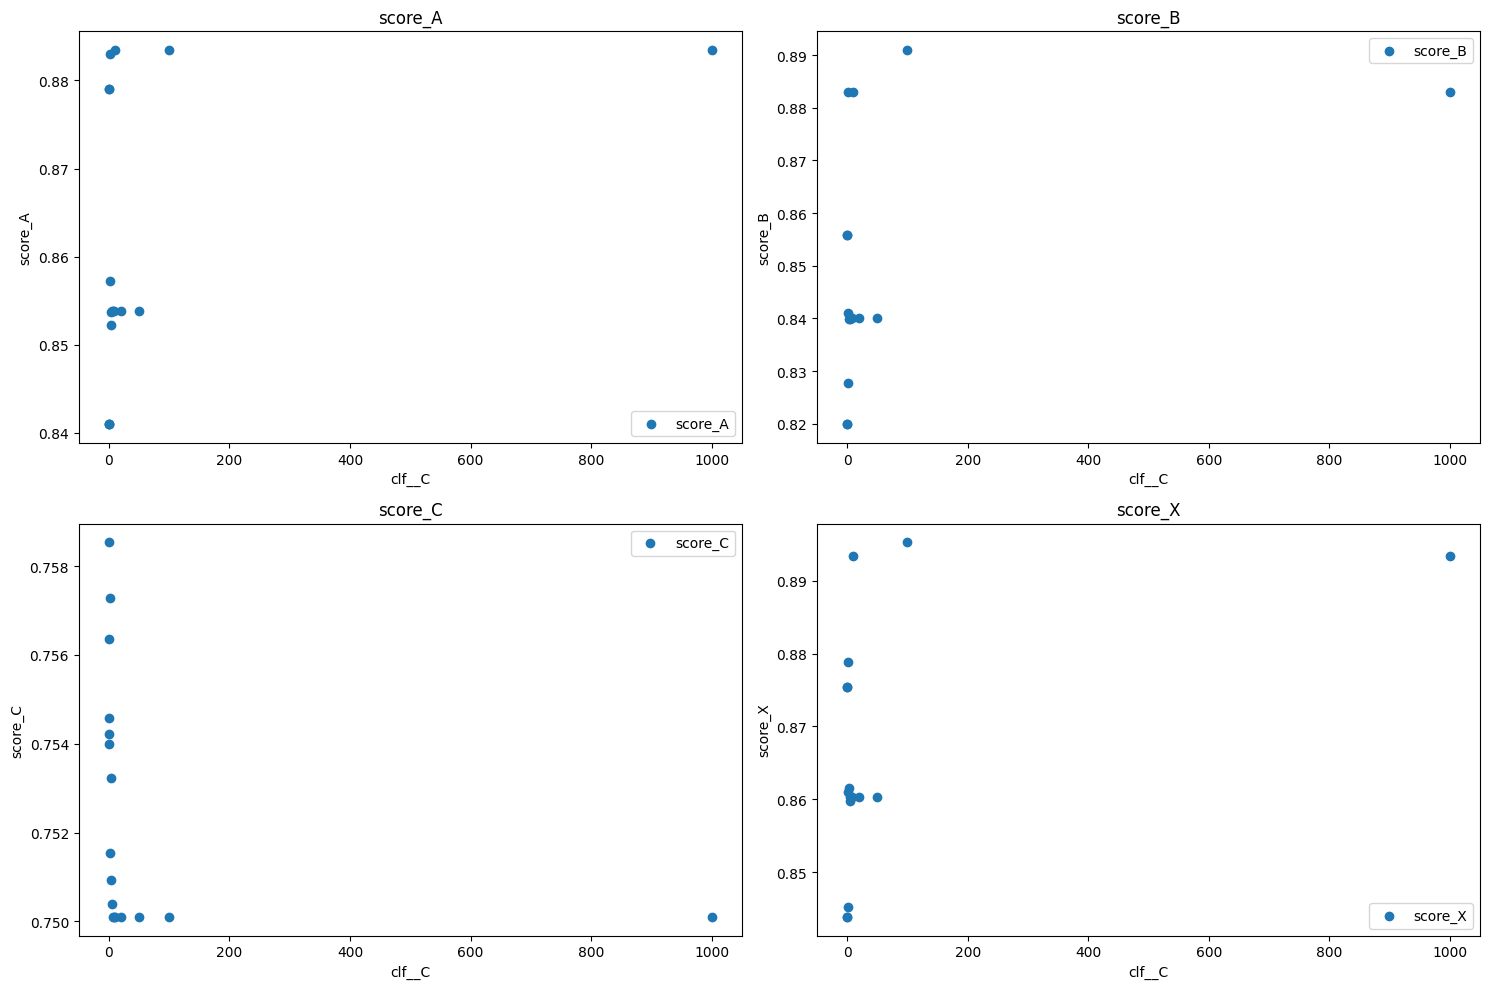

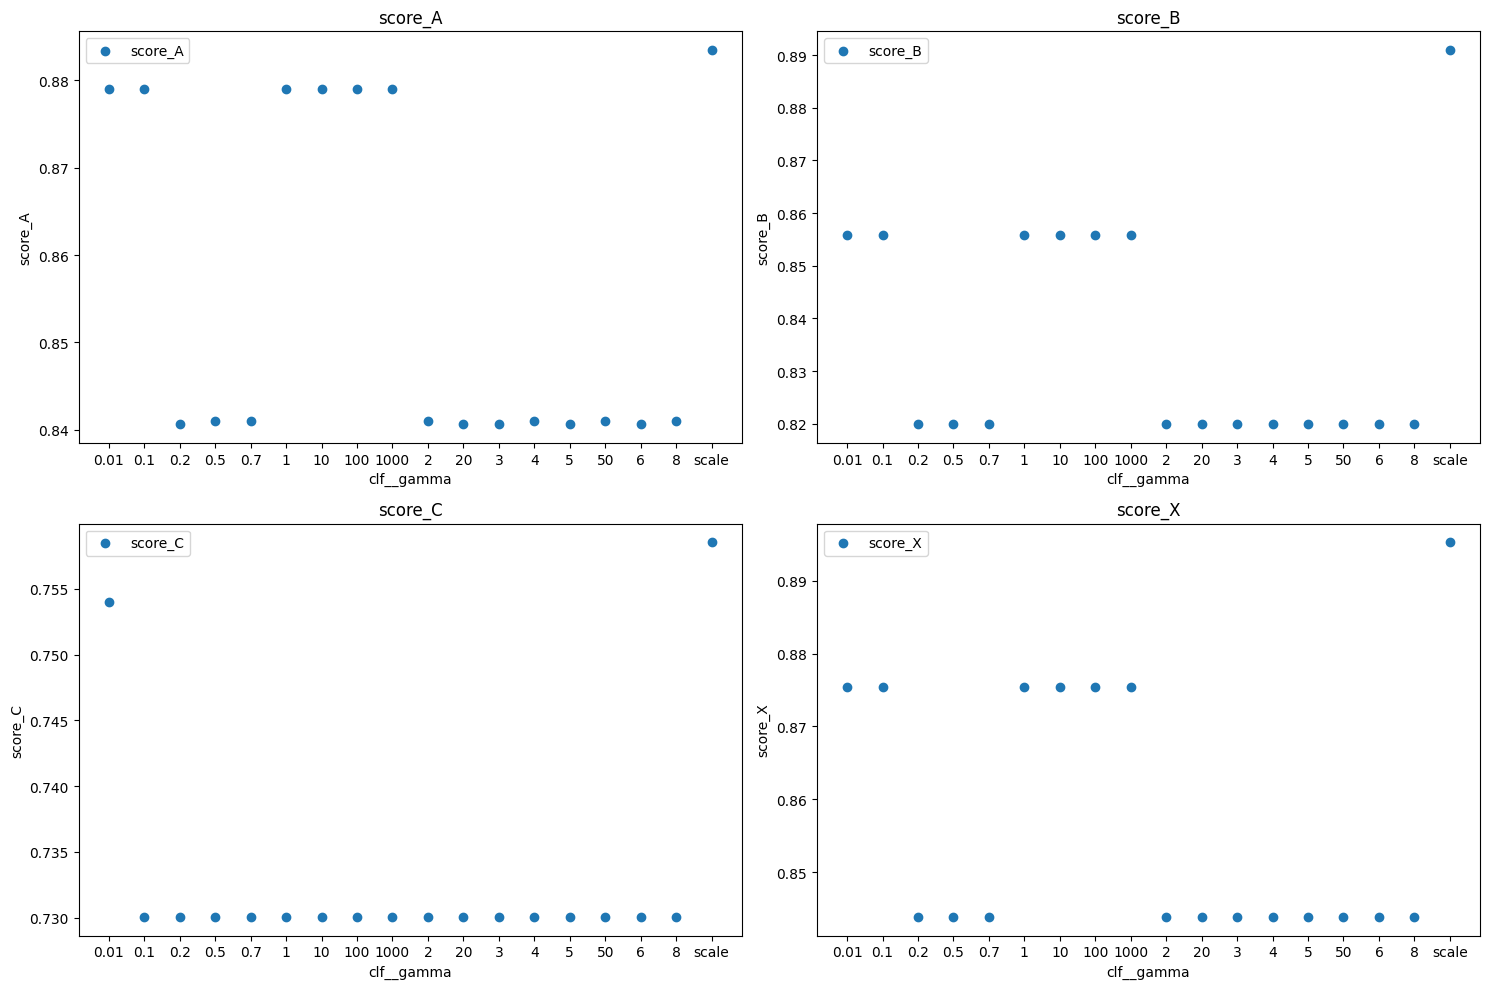

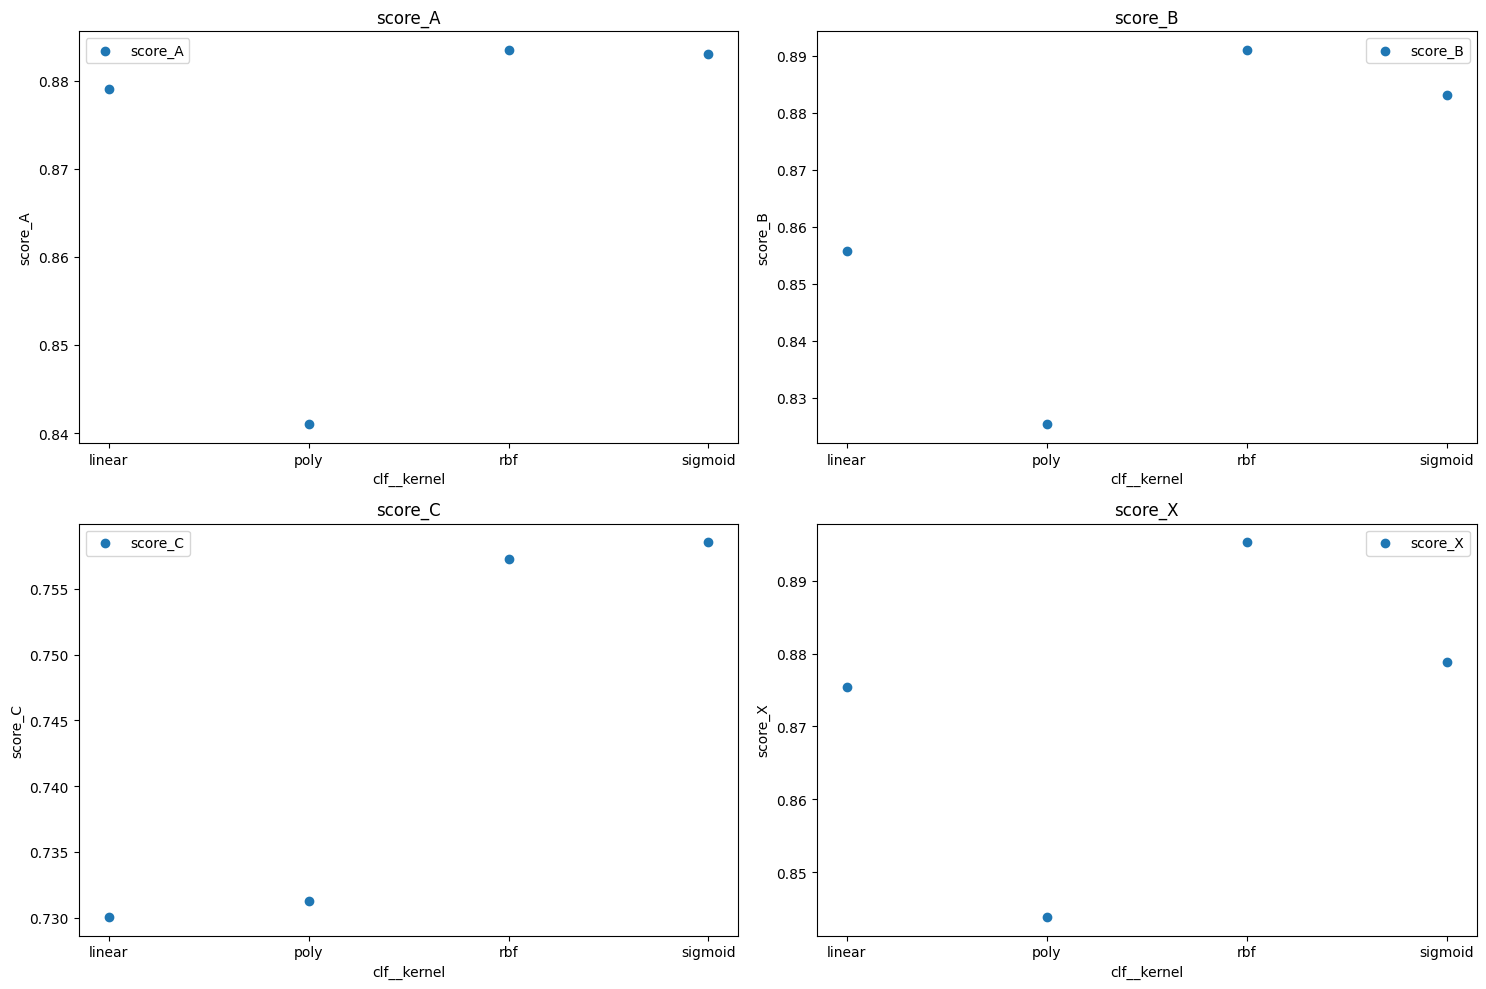

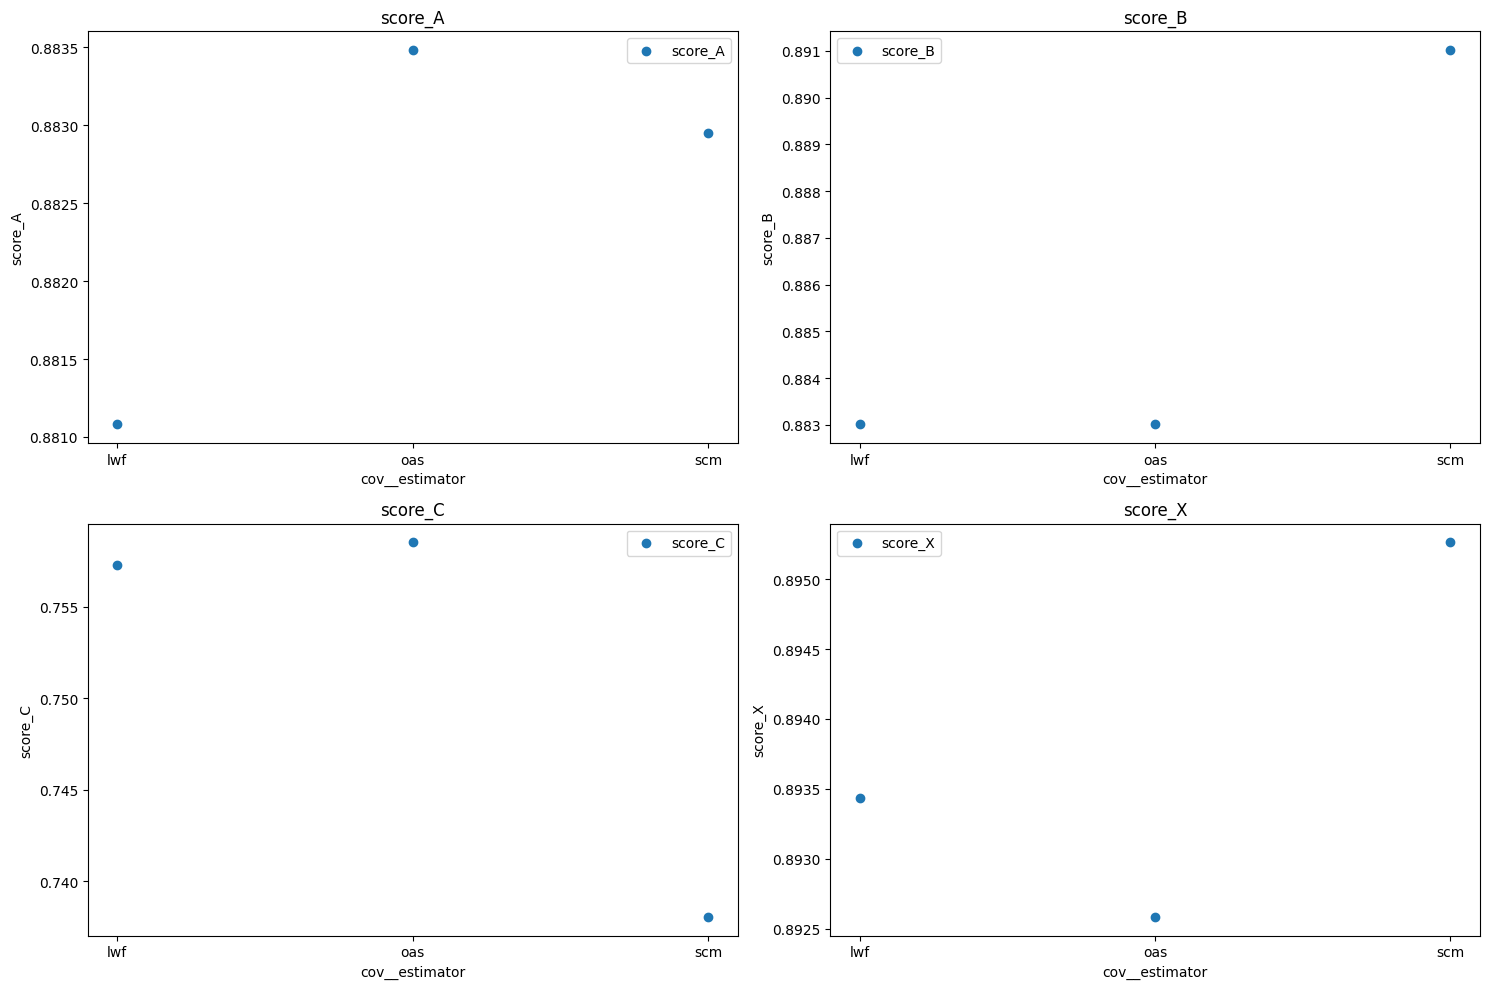

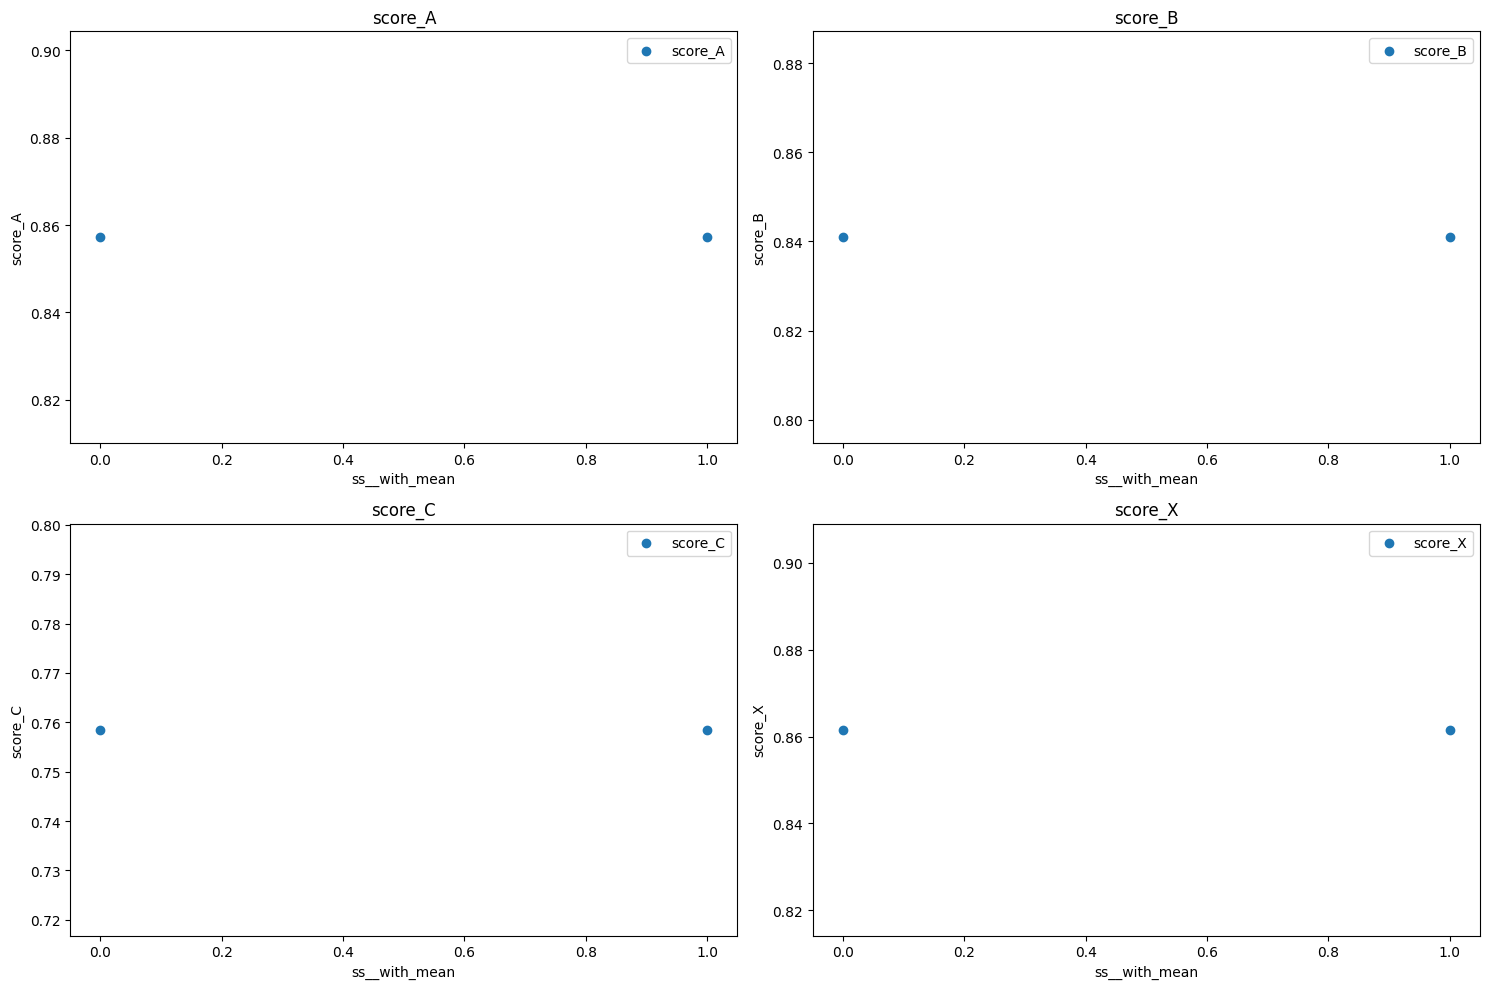

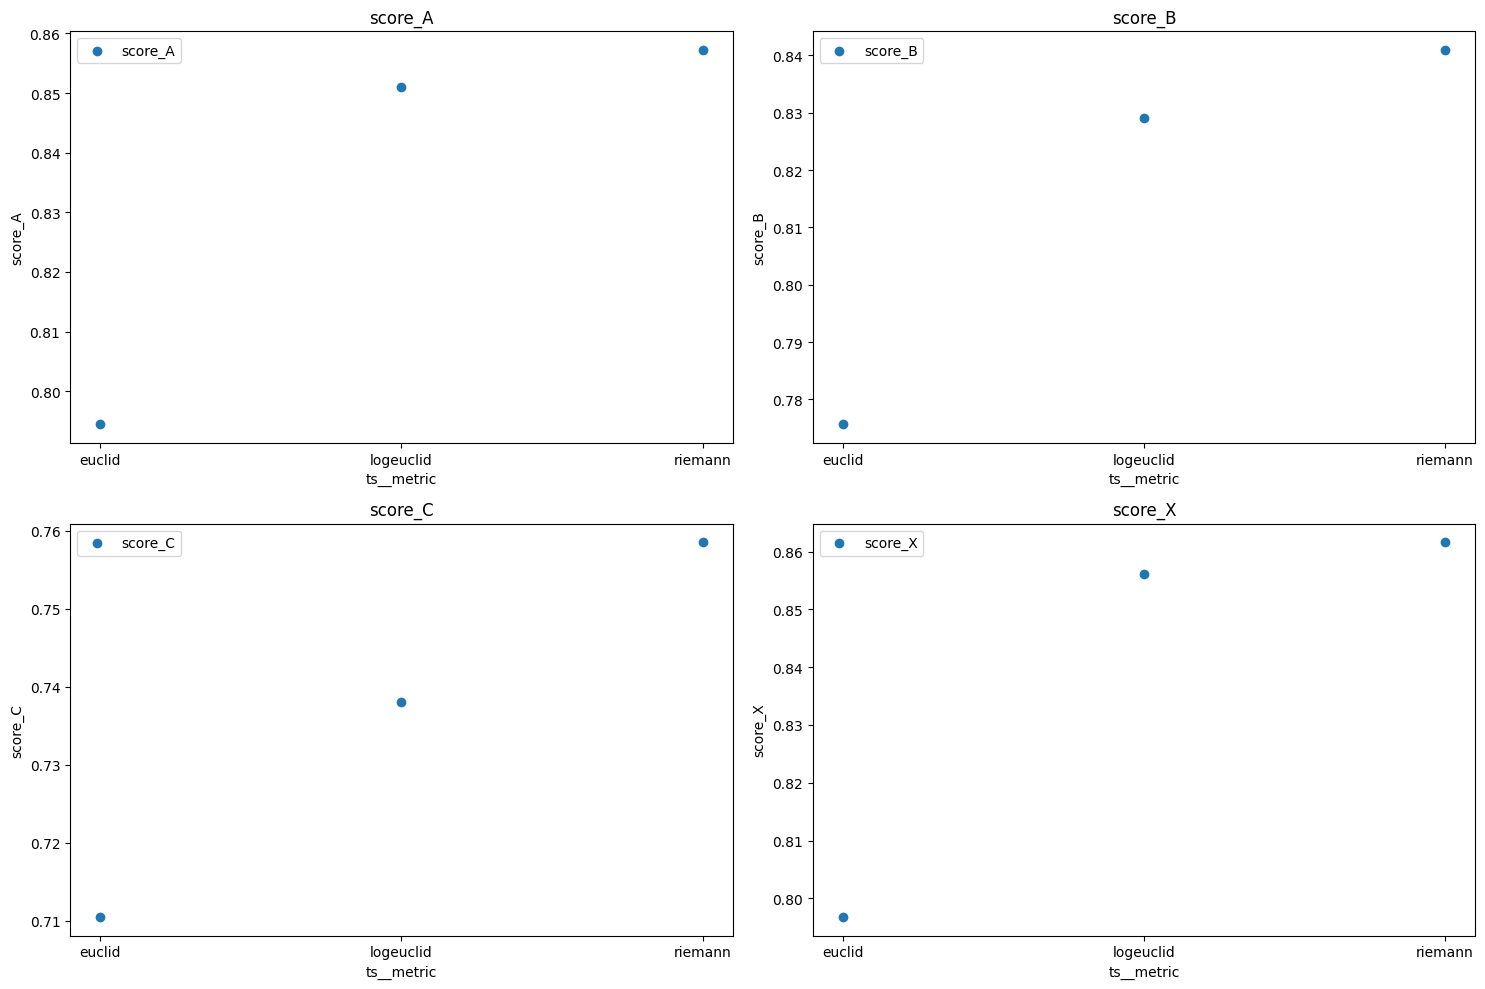

In [11]:
# max for each param and score
parameters = ['clf__C', 'clf__gamma', 'clf__kernel', 'cov__estimator',  'ss__with_mean', 'ts__metric']
for p in parameters:
    max_score_A = result_df.groupby(p)['score_A'].max()
    max_score_B = result_df.groupby(p)['score_B'].max()
    max_score_C = result_df.groupby(p)['score_C'].max()
    max_score_X = result_df.groupby(p)['score_X'].max()

    max_score_A = max_score_A.reset_index()
    max_score_B = max_score_B.reset_index()
    max_score_C = max_score_C.reset_index()
    max_score_X = max_score_X.reset_index()

    fig, ax = plt.subplots(2, 2, figsize=(15, 10))
    ax[0, 0].scatter(max_score_A[p], max_score_A['score_A'], label='score_A', marker='o')
    ax[0, 0].set_xlabel(p)
    ax[0, 0].set_ylabel('score_A')
    ax[0, 0].set_title('score_A')
    ax[0, 0].legend()

    ax[0, 1].scatter(max_score_B[p], max_score_B['score_B'], label='score_B', marker='o')
    ax[0, 1].set_xlabel(p)
    ax[0, 1].set_ylabel('score_B')
    ax[0, 1].set_title('score_B')
    ax[0, 1].legend()

    ax[1, 0].scatter(max_score_C[p], max_score_C['score_C'], label='score_C', marker='o')
    ax[1, 0].set_xlabel(p)
    ax[1, 0].set_ylabel('score_C')
    ax[1, 0].set_title('score_C')
    ax[1, 0].legend()

    ax[1, 1].scatter(max_score_X[p], max_score_X['score_X'], label='score_X', marker='o')
    ax[1, 1].set_xlabel(p)
    ax[1, 1].set_ylabel('score_X')
    ax[1, 1].set_title('score_X')
    ax[1, 1].legend()
    plt.tight_layout()
    plt.show()

In [12]:
# sort by score A

result_df = result_df.sort_values(by='score_A', ascending=False)
result_df.head(10)

,EPOCHS_EMPTY_FROM_MVT_TMIN,EPOCHS_LENGTH,EPOCHS_TMIN,FMAX,FMIN,pipeline,clf__C,clf__gamma,clf__kernel,cov__estimator,score_A,score_B,score_C,score_X,duration_preprocessing,duration_train,memory,FILE_PATH,NUMBER_OF_SESSIONS,RANDOM_STATE,N_SPLIT,BINARY_CLASSIFICATION,VERSION,PATH_RESULTS,NAME_RESULTS,PATH_DATA_PROCESSED,FOLDER_RESULTS_ITERATIONS,NAME_RESULTS_ITERATIONS,LOG_FOLDER,SAVE_EACH_ITERATION,REMOVE_ITERATIONS,REMOVE_DATA_PROCESSED,ss__with_mean,ts__metric
2983,-6,1.7,-0.75,30,9,"Pipeline(steps=[('cov', Covariances(estimator=...",10.0,scale,rbf,oas,0.883485,0.883013,0.594298,0.892584,60.453149,23.834695,336.804688,./../../../data/raw/Data_npy/,10,42,4,True,5,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True,NaN,NaN
3004,-6,1.7,-0.75,30,9,"Pipeline(steps=[('cov', Covariances(estimator=...",1000.0,scale,rbf,oas,0.883485,0.883013,0.594298,0.892584,60.453149,22.737206,661.816406,./../../../data/raw/Data_npy/,10,42,4,True,5,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True,NaN,NaN
51,-6,1.7,-0.75,30,9,"Pipeline(steps=[('cov', Covariances(estimator=...",100.0,scale,rbf,oas,0.883485,0.883013,0.594298,0.892584,59.832656,23.225403,661.816406,./../../../data/raw/Data_npy/,10,42,4,True,5,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True,NaN,NaN
2911,-6,1.7,-0.75,30,9,"Pipeline(steps=[('cov', Covariances()), ('ts',...",1.0,scale,sigmoid,scm,0.882952,0.875000,0.588816,0.875594,57.573977,20.057190,332.808594,./../../../data/raw/Data_npy/,10,42,4,True,5,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True,NaN,NaN
2868,-6,1.7,-0.75,30,9,"Pipeline(steps=[('cov', Covariances()), ('ts',...",100.0,scale,rbf,scm,0.881170,0.891026,0.584430,0.895264,56.658707,19.406544,657.910156,./../../../data/raw/Data_npy/,10,42,4,True,5,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True,NaN,NaN
3046,-6,1.7,-0.75,30,9,"Pipeline(steps=[('cov', Covariances(estimator=...",10.0,scale,rbf,lwf,0.881081,0.883013,0.589912,0.893438,60.440308,25.390310,333.902344,./../../../data/raw/Data_npy/,10,42,4,True,5,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True,NaN,NaN
3067,-6,1.7,-0.75,30,9,"Pipeline(steps=[('cov', Covariances(estimator=...",1000.0,scale,rbf,lwf,0.881081,0.883013,0.589912,0.893438,60.440308,24.740705,337.113281,./../../../data/raw/Data_npy/,10,42,4,True,5,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True,NaN,NaN
2848,-6,1.7,-0.75,30,9,"Pipeline(steps=[('cov', Covariances(estimator=...",1.0,scale,sigmoid,lwf,0.879805,0.883013,0.597588,0.878906,56.658707,25.337998,331.781250,./../../../data/raw/Data_npy/,10,42,4,True,5,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True,NaN,NaN
3042,-6,1.7,-0.75,30,9,"Pipeline(steps=[('cov', Covariances()), ('ts',...",10.0,10,linear,scm,0.879043,0.855769,0.592105,0.875442,60.440308,20.087645,327.429688,./../../../data/raw/Data_npy/,10,42,4,True,5,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True,NaN,NaN
3063,-6,1.7,-0.75,30,9,"Pipeline(steps=[('cov', Covariances()), ('ts',...",1000.0,10,linear,scm,0.879043,0.855769,0.592105,0.875442,60.440308,20.100785,331.875000,./../../../data/raw/Data_npy/,10,42,4,True,5,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True,NaN,NaN


In [13]:
# sort by score B

result_df = result_df.sort_values(by='score_B', ascending=False)
result_df.head(10)

,EPOCHS_EMPTY_FROM_MVT_TMIN,EPOCHS_LENGTH,EPOCHS_TMIN,FMAX,FMIN,pipeline,clf__C,clf__gamma,clf__kernel,cov__estimator,score_A,score_B,score_C,score_X,duration_preprocessing,duration_train,memory,FILE_PATH,NUMBER_OF_SESSIONS,RANDOM_STATE,N_SPLIT,BINARY_CLASSIFICATION,VERSION,PATH_RESULTS,NAME_RESULTS,PATH_DATA_PROCESSED,FOLDER_RESULTS_ITERATIONS,NAME_RESULTS_ITERATIONS,LOG_FOLDER,SAVE_EACH_ITERATION,REMOVE_ITERATIONS,REMOVE_DATA_PROCESSED,ss__with_mean,ts__metric
2868,-6,1.7,-0.75,30,9,"Pipeline(steps=[('cov', Covariances()), ('ts',...",100.0,scale,rbf,scm,0.881170,0.891026,0.584430,0.895264,56.658707,19.406544,657.910156,./../../../data/raw/Data_npy/,10,42,4,True,5,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True,NaN,NaN
2983,-6,1.7,-0.75,30,9,"Pipeline(steps=[('cov', Covariances(estimator=...",10.0,scale,rbf,oas,0.883485,0.883013,0.594298,0.892584,60.453149,23.834695,336.804688,./../../../data/raw/Data_npy/,10,42,4,True,5,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True,NaN,NaN
51,-6,1.7,-0.75,30,9,"Pipeline(steps=[('cov', Covariances(estimator=...",100.0,scale,rbf,oas,0.883485,0.883013,0.594298,0.892584,59.832656,23.225403,661.816406,./../../../data/raw/Data_npy/,10,42,4,True,5,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True,NaN,NaN
3046,-6,1.7,-0.75,30,9,"Pipeline(steps=[('cov', Covariances(estimator=...",10.0,scale,rbf,lwf,0.881081,0.883013,0.589912,0.893438,60.440308,25.390310,333.902344,./../../../data/raw/Data_npy/,10,42,4,True,5,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True,NaN,NaN
3067,-6,1.7,-0.75,30,9,"Pipeline(steps=[('cov', Covariances(estimator=...",1000.0,scale,rbf,lwf,0.881081,0.883013,0.589912,0.893438,60.440308,24.740705,337.113281,./../../../data/raw/Data_npy/,10,42,4,True,5,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True,NaN,NaN
2848,-6,1.7,-0.75,30,9,"Pipeline(steps=[('cov', Covariances(estimator=...",1.0,scale,sigmoid,lwf,0.879805,0.883013,0.597588,0.878906,56.658707,25.337998,331.781250,./../../../data/raw/Data_npy/,10,42,4,True,5,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True,NaN,NaN
3004,-6,1.7,-0.75,30,9,"Pipeline(steps=[('cov', Covariances(estimator=...",1000.0,scale,rbf,oas,0.883485,0.883013,0.594298,0.892584,60.453149,22.737206,661.816406,./../../../data/raw/Data_npy/,10,42,4,True,5,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True,NaN,NaN
2911,-6,1.7,-0.75,30,9,"Pipeline(steps=[('cov', Covariances()), ('ts',...",1.0,scale,sigmoid,scm,0.882952,0.875000,0.588816,0.875594,57.573977,20.057190,332.808594,./../../../data/raw/Data_npy/,10,42,4,True,5,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True,NaN,NaN
2847,-6,1.7,-0.75,30,9,"Pipeline(steps=[('cov', Covariances()), ('ts',...",1.0,scale,rbf,scm,0.861461,0.863782,0.595395,0.867115,56.658707,20.181513,331.519531,./../../../data/raw/Data_npy/,10,42,4,True,5,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True,NaN,NaN
30,-6,1.7,-0.75,30,9,"Pipeline(steps=[('cov', Covariances(estimator=...",1.0,scale,rbf,oas,0.864468,0.860577,0.600877,0.869474,59.832656,23.793680,331.894531,./../../../data/raw/Data_npy/,10,42,4,True,5,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True,NaN,NaN


In [14]:
# sort by score C

result_df = result_df.sort_values(by='score_C', ascending=False)
result_df.head(10)

,EPOCHS_EMPTY_FROM_MVT_TMIN,EPOCHS_LENGTH,EPOCHS_TMIN,FMAX,FMIN,pipeline,clf__C,clf__gamma,clf__kernel,cov__estimator,score_A,score_B,score_C,score_X,duration_preprocessing,duration_train,memory,FILE_PATH,NUMBER_OF_SESSIONS,RANDOM_STATE,N_SPLIT,BINARY_CLASSIFICATION,VERSION,PATH_RESULTS,NAME_RESULTS,PATH_DATA_PROCESSED,FOLDER_RESULTS_ITERATIONS,NAME_RESULTS_ITERATIONS,LOG_FOLDER,SAVE_EACH_ITERATION,REMOVE_ITERATIONS,REMOVE_DATA_PROCESSED,ss__with_mean,ts__metric
3390,-6,1.7,-0.75,30,9,"Pipeline(steps=[('cov', Covariances(estimator=...",0.1,scale,sigmoid,oas,0.777978,0.764325,0.758538,0.780617,455.299003,342.050882,1785.175781,./../../../data/raw/Data_npy/,-1,42,4,True,5,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True,True,riemann
385,-6,1.7,-0.75,30,9,"Pipeline(steps=[('cov', Covariances(estimator=...",0.1,scale,sigmoid,oas,0.777978,0.764325,0.758538,0.780617,469.376955,337.169314,2280.144531,./../../../data/raw/Data_npy/,-1,42,4,True,5,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True,False,riemann
1027,-6,1.7,-0.75,30,9,"Pipeline(steps=[('cov', Covariances(estimator=...",1.0,scale,rbf,lwf,0.855609,0.838474,0.757294,0.855305,469.376955,348.656787,1783.960938,./../../../data/raw/Data_npy/,-1,42,4,True,5,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True,False,riemann
4032,-6,1.7,-0.75,30,9,"Pipeline(steps=[('cov', Covariances(estimator=...",1.0,scale,rbf,lwf,0.855609,0.838474,0.757294,0.855305,455.299003,340.629133,2280.417969,./../../../data/raw/Data_npy/,-1,42,4,True,5,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True,True,riemann
865,-6,1.7,-0.75,30,9,"Pipeline(steps=[('cov', Covariances(estimator=...",0.7,scale,rbf,lwf,0.840509,0.827651,0.756368,0.845280,469.376955,352.339777,1785.417969,./../../../data/raw/Data_npy/,-1,42,4,True,5,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True,False,riemann
3870,-6,1.7,-0.75,30,9,"Pipeline(steps=[('cov', Covariances(estimator=...",0.7,scale,rbf,lwf,0.840509,0.827651,0.756368,0.845280,455.299003,342.523043,2280.417969,./../../../data/raw/Data_npy/,-1,42,4,True,5,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True,True,riemann
3552,-6,1.7,-0.75,30,9,"Pipeline(steps=[('cov', Covariances(estimator=...",0.2,scale,sigmoid,oas,0.783892,0.780611,0.754583,0.783074,455.299003,329.657989,1785.535156,./../../../data/raw/Data_npy/,-1,42,4,True,5,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True,True,riemann
547,-6,1.7,-0.75,30,9,"Pipeline(steps=[('cov', Covariances(estimator=...",0.2,scale,sigmoid,oas,0.783892,0.780611,0.754583,0.783074,469.376955,334.903641,1783.261719,./../../../data/raw/Data_npy/,-1,42,4,True,5,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True,False,riemann
3708,-6,1.7,-0.75,30,9,"Pipeline(steps=[('cov', Covariances(estimator=...",0.5,scale,rbf,lwf,0.829307,0.811168,0.754228,0.827172,455.299003,339.373880,2280.402344,./../../../data/raw/Data_npy/,-1,42,4,True,5,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True,True,riemann
703,-6,1.7,-0.75,30,9,"Pipeline(steps=[('cov', Covariances(estimator=...",0.5,scale,rbf,lwf,0.829307,0.811168,0.754228,0.827172,469.376955,356.341236,1784.890625,./../../../data/raw/Data_npy/,-1,42,4,True,5,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True,False,riemann


### Results grid 5

In [15]:
# score mean A, B and C

result_df['score_A_B_C_mean'] = (result_df['score_A'] + result_df['score_B'] + result_df['score_C'])/3
result_df = result_df.sort_values(by='score_A_B_C_mean', ascending=False)
result_df.head(10)

,EPOCHS_EMPTY_FROM_MVT_TMIN,EPOCHS_LENGTH,EPOCHS_TMIN,FMAX,FMIN,pipeline,clf__C,clf__gamma,clf__kernel,cov__estimator,score_A,score_B,score_C,score_X,duration_preprocessing,duration_train,memory,FILE_PATH,NUMBER_OF_SESSIONS,RANDOM_STATE,N_SPLIT,BINARY_CLASSIFICATION,VERSION,PATH_RESULTS,NAME_RESULTS,PATH_DATA_PROCESSED,FOLDER_RESULTS_ITERATIONS,NAME_RESULTS_ITERATIONS,LOG_FOLDER,SAVE_EACH_ITERATION,REMOVE_ITERATIONS,REMOVE_DATA_PROCESSED,ss__with_mean,ts__metric,score_A_B_C_mean
1027,-6,1.7,-0.75,30,9,"Pipeline(steps=[('cov', Covariances(estimator=...",1.0,scale,rbf,lwf,0.855609,0.838474,0.757294,0.855305,469.376955,348.656787,1783.960938,./../../../data/raw/Data_npy/,-1,42,4,True,5,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True,False,riemann,0.817126
4032,-6,1.7,-0.75,30,9,"Pipeline(steps=[('cov', Covariances(estimator=...",1.0,scale,rbf,lwf,0.855609,0.838474,0.757294,0.855305,455.299003,340.629133,2280.417969,./../../../data/raw/Data_npy/,-1,42,4,True,5,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True,True,riemann,0.817126
4194,-6,1.7,-0.75,30,9,"Pipeline(steps=[('cov', Covariances(estimator=...",2.0,scale,rbf,lwf,0.857257,0.840981,0.751541,0.861025,455.299003,355.790865,1783.925781,./../../../data/raw/Data_npy/,-1,42,4,True,5,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True,True,riemann,0.816593
1189,-6,1.7,-0.75,30,9,"Pipeline(steps=[('cov', Covariances(estimator=...",2.0,scale,rbf,lwf,0.857257,0.840981,0.751541,0.861025,469.376955,356.045563,1784.917969,./../../../data/raw/Data_npy/,-1,42,4,True,5,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True,False,riemann,0.816593
4356,-6,1.7,-0.75,30,9,"Pipeline(steps=[('cov', Covariances(estimator=...",3.0,scale,rbf,lwf,0.852270,0.839985,0.753239,0.861596,455.299003,348.378887,2280.433594,./../../../data/raw/Data_npy/,-1,42,4,True,5,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True,True,riemann,0.815165
1351,-6,1.7,-0.75,30,9,"Pipeline(steps=[('cov', Covariances(estimator=...",3.0,scale,rbf,lwf,0.852270,0.839985,0.753239,0.861596,469.376955,357.520991,1784.109375,./../../../data/raw/Data_npy/,-1,42,4,True,5,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True,False,riemann,0.815165
4518,-6,1.7,-0.75,30,9,"Pipeline(steps=[('cov', Covariances(estimator=...",4.0,scale,rbf,lwf,0.853743,0.839823,0.750926,0.859720,455.299003,354.516829,1788.761719,./../../../data/raw/Data_npy/,-1,42,4,True,5,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True,True,riemann,0.814831
1513,-6,1.7,-0.75,30,9,"Pipeline(steps=[('cov', Covariances(estimator=...",4.0,scale,rbf,lwf,0.853743,0.839823,0.750926,0.859720,469.376955,355.832218,1785.207031,./../../../data/raw/Data_npy/,-1,42,4,True,5,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True,False,riemann,0.814831
1675,-6,1.7,-0.75,30,9,"Pipeline(steps=[('cov', Covariances(estimator=...",5.0,scale,rbf,lwf,0.853779,0.840156,0.750402,0.860349,469.376955,357.035400,1784.843750,./../../../data/raw/Data_npy/,-1,42,4,True,5,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True,False,riemann,0.814779
4680,-6,1.7,-0.75,30,9,"Pipeline(steps=[('cov', Covariances(estimator=...",5.0,scale,rbf,lwf,0.853779,0.840156,0.750402,0.860349,455.299003,340.839590,2280.449219,./../../../data/raw/Data_npy/,-1,42,4,True,5,./results/,RSVM_MVT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_search_preproc_iter,./logs/,True,True,True,True,riemann,0.814779


## Grid search 6: Other classifiers

### Preprocessing hyperparameters : 
```python
params_dict_lists = { #V5
    'EPOCHS_TMIN': [-0.75], # 1
    'EPOCHS_LENGTH': [1.7], # 1
    'EPOCHS_EMPTY_FROM_MVT_TMIN': [-6], # 1
    'FMIN': [9], # 1
    'FMAX': [30], # 1
} # 32*19 = 608 combinations
## DONE

params_dict_lists_exclude = None

params_exclude_rules = None
```
-----------------------------

### Pipeline hyperparameters : 
```python
cov = Covariances()
ts = TangentSpace()
ss = StandardScaler()
svm = SVC()
lr = LogisticRegression()
rf = RandomForestClassifier()
ab = AdaBoostClassifier()

pipeline_svm = Pipeline([('cov', cov), ('ts', ts), ('ss', ss), ('clf', svm)])
pipeline_lr = Pipeline([('cov', cov), ('ts', ts), ('ss', ss), ('clf', lr)])
pipeline_rf = Pipeline([('cov', cov), ('ts', ts), ('ss', ss), ('clf', rf)])
pipeline_ab = Pipeline([('cov', cov), ('ts', ts), ('ss', ss), ('clf', ab)])

pipelines_dict_lists = {
    'pipeline_1': {
    'pipeline': [pipeline_svm],
    'cov__estimator': ['oas'], # 1
    },
    'pipeline_2':{
    'pipeline': [pipeline_lr],
    'cov__estimator': ['oas'], # 1
    },
    'pipeline_3':{
    'pipeline': [pipeline_rf],
    'cov__estimator': ['oas'], # 1
    },
    'pipeline_4':{
    'pipeline': [pipeline_ab],
    'cov__estimator': ['oas'], # 1
    }
}

pipelines_dict_lists_exclude = None
pipelines_exclude_rules = None
```

In [2]:
RESULT_PATH = './../../src/training/RIEMANN_SVM_MVT_grid_search/results/V6'
NAME_RESULTS = 'RSVM_MVT_search_preproc_V6'
SAVE_PATH = './results/'
NAME_SAVE = 'hyperparam_preproc_movement_SVM_aggregated_filter_V6'

In [4]:
# agregate results one file is one hyperparameter setting
files = [f for f in os.listdir(RESULT_PATH) if f.startswith(NAME_RESULTS) and f.endswith('.csv')]
files = [os.path.join(RESULT_PATH, f) for f in files]
dfs = []
for file in files:
    df = pd.read_csv(file)
    dfs.append(df)
result_df = pd.concat(dfs, ignore_index=True)

# Remove same lines
result_df = result_df.drop_duplicates()

# Save aggregated results
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)
result_df.to_csv(os.path.join(SAVE_PATH, NAME_SAVE + '.csv'), index=False)

In [5]:
result_df = pd.read_csv(SAVE_PATH + NAME_SAVE + ".csv")

In [6]:
result_df.describe()

,EPOCHS_EMPTY_FROM_MVT_TMIN,EPOCHS_LENGTH,EPOCHS_TMIN,FMAX,FMIN,score_A,score_B,score_C,score_X,duration_preprocessing,duration_train,memory,NUMBER_OF_SESSIONS,RANDOM_STATE,N_SPLIT,VERSION
count,4.0,4.0,4.00,4.0,4.0,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.0,4.0,4.0,4.0
mean,-6.0,1.7,-0.75,30.0,9.0,0.802790,0.785801,0.720807,0.804092,437.239291,294.555814,1901.963867,-1.0,42.0,4.0,6.0
std,0.0,0.0,0.00,0.0,0.0,0.039002,0.040932,0.031663,0.039792,26.812623,74.994543,5.570406,0.0,0.0,0.0,0.0
min,-6.0,1.7,-0.75,30.0,9.0,0.769006,0.744491,0.690972,0.770175,413.743347,230.470893,1896.917969,-1.0,42.0,4.0,6.0
25%,-6.0,1.7,-0.75,30.0,9.0,0.775604,0.761184,0.698366,0.774871,419.931841,251.174527,1898.816406,-1.0,42.0,4.0,6.0
50%,-6.0,1.7,-0.75,30.0,9.0,0.793420,0.779455,0.715544,0.794820,430.485400,273.220941,1900.574219,-1.0,42.0,4.0,6.0
75%,-6.0,1.7,-0.75,30.0,9.0,0.820606,0.804072,0.737986,0.824040,447.792850,316.602229,1903.721680,-1.0,42.0,4.0,6.0
max,-6.0,1.7,-0.75,30.0,9.0,0.855315,0.839804,0.761170,0.856552,474.243018,401.310483,1909.789062,-1.0,42.0,4.0,6.0


In [28]:
result_df['model'] = result_df['pipeline'].apply(lambda x: x.split("clf', ")[1].split('(')[0])

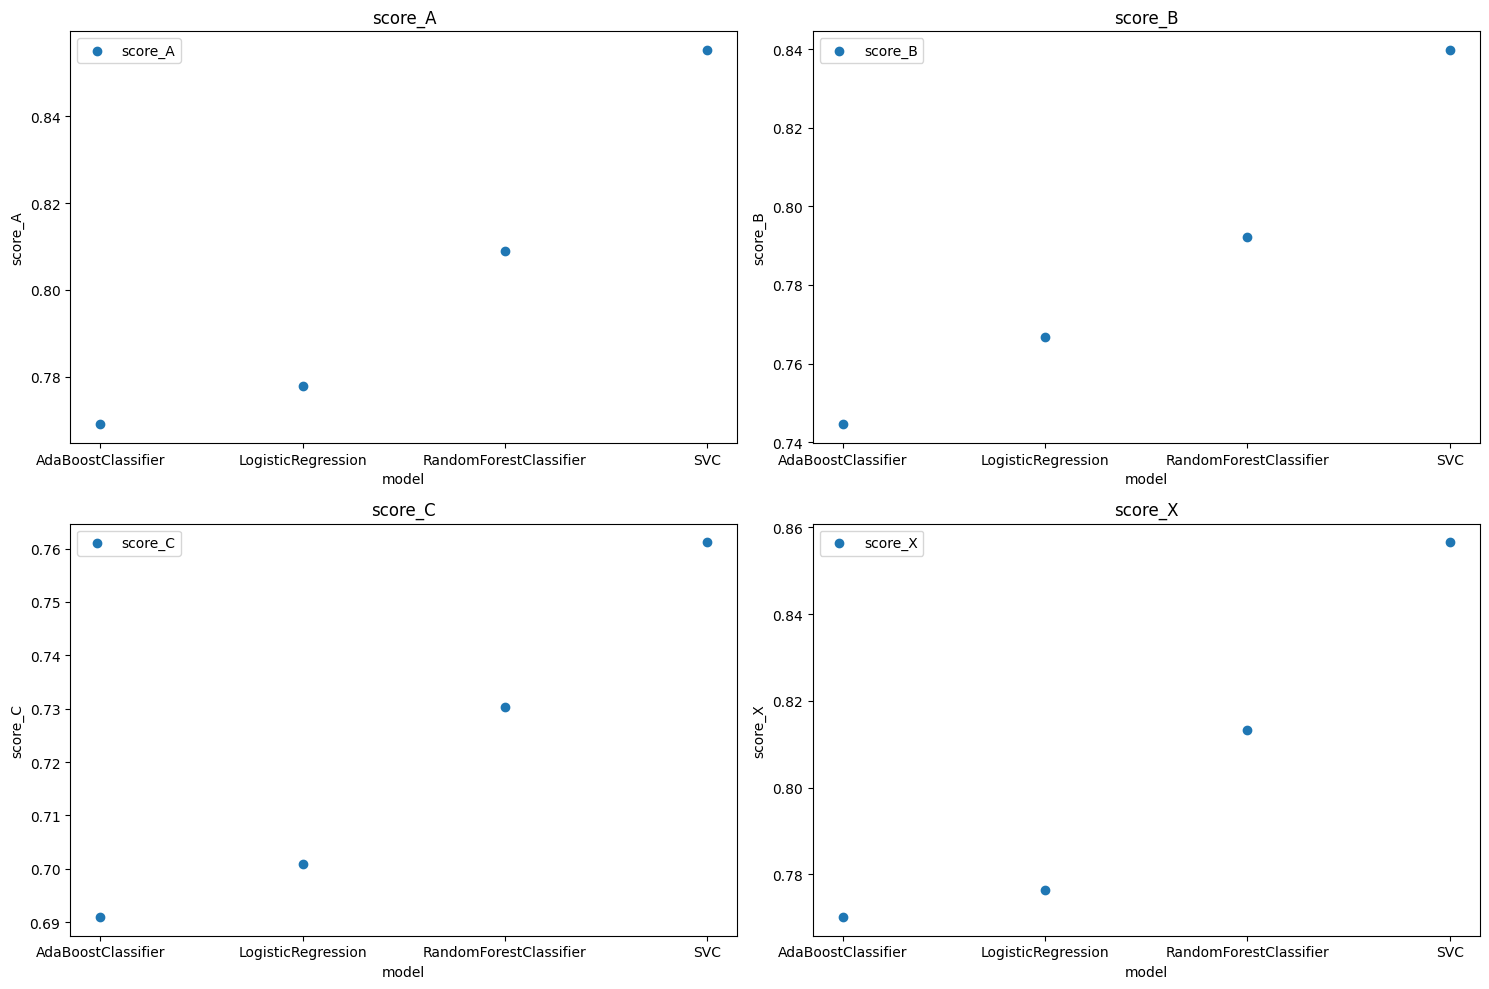

In [29]:
# max for each param and score
param = ['model']
for p in param:
    max_score_A = result_df.groupby(p)['score_A'].max()
    max_score_B = result_df.groupby(p)['score_B'].max()
    max_score_C = result_df.groupby(p)['score_C'].max()
    max_score_X = result_df.groupby(p)['score_X'].max()

    max_score_A = max_score_A.reset_index()
    max_score_B = max_score_B.reset_index()
    max_score_C = max_score_C.reset_index()
    max_score_X = max_score_X.reset_index()


    fig, ax = plt.subplots(2, 2, figsize=(15, 10))
    ax[0, 0].scatter(max_score_A[p], max_score_A['score_A'], label='score_A', marker='o')
    ax[0, 0].set_xlabel(p)
    ax[0, 0].set_ylabel('score_A')
    ax[0, 0].set_title('score_A')
    ax[0, 0].legend()

    ax[0, 1].scatter(max_score_B[p], max_score_B['score_B'], label='score_B', marker='o')

    ax[0, 1].set_xlabel(p)
    ax[0, 1].set_ylabel('score_B')
    ax[0, 1].set_title('score_B')
    ax[0, 1].legend()

    ax[1, 0].scatter(max_score_C[p], max_score_C['score_C'], label='score_C', marker='o')
    ax[1, 0].set_xlabel(p)
    ax[1, 0].set_ylabel('score_C')
    ax[1, 0].set_title('score_C')
    ax[1, 0].legend()

    ax[1, 1].scatter(max_score_X[p], max_score_X['score_X'], label='score_X', marker='o')
    ax[1, 1].set_xlabel(p)
    ax[1, 1].set_ylabel('score_X')
    ax[1, 1].set_title('score_X')
    ax[1, 1].legend()
    plt.tight_layout()
    plt.show()